# Mercari Price Suggestion Challenge

Mercari is Japan's biggest community powered shopping app, where Sellers sell their products on their platform and they themselves put the price of the products.The competition is about suggesting the right product price given the details of a product and the user description about that product.

Mercari has a problem with product prices that sellers are putting. clothing products pricing is highly influenced by seasonal trends and their brand names, while electronics products pricing varies based on specifications. therefore the company likes to recommend the price of a product itself, so the company and sellers both would get most profits out of products.

The competition is about suggesting the right product price given the details of a product and the user description about that product.


# Performace Metrics

Root mean square log error.

1. It's preferred for this competetion because, other popular metrics like MAE, MSE, RMSE, RSquared might not fit for this problem.

2. MAE

Mean Absolute error is residuals, which will cause problem, as certain algorithms cannot differentiate parameters with respect to residuals, another drawback is in our dataset target variable in normally distributed,
therefor MAE assumption is incorrect.

3. MSE:

Mean Square error penalizes more for large residuals as it squares the residual term, so the loss is not scaled to target variable.

4. RMSE:

Root mean square error assumptio is the target variable shoudl follow normal distribution, but our target variable is right skwed.

5. RMSLE:

Root mean square log error is the residual will be in log scale, so the residual will follow normal distribution, and RMSLE will still penalize large residuals but in scale of target variable. 




In [ ]:
train_df_path           = "data/train.tsv"
test_df_path            = "data/test.tsv"
test_stage_2_df_path    = "data/test_stg2.tsv"

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 251 kB/s eta 0:00:011
     |████████████████████████████████| 13.2 MB 2.7 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=96dbfa9b93044e10ce919b407ccaa62486a76d86ec588564d4e254d2f189dbe5
  Stored in directory: /home/d/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chart_studio.plotly import plotly
import seaborn as sns
from tqdm import tqdm
import regex as re

# Reading Train data

In [ ]:
train_df = pd.read_table(train_df_path)
test_df  = pd.read_table(test_df_path)
# test_2_df = pd.read_table(test_stage_2_df_path)


In [ ]:
train_df.count() / len(train_df)

train_id             1.000000
name                 1.000000
item_condition_id    1.000000
category_name        0.995732
brand_name           0.573243
price                1.000000
shipping             1.000000
item_description     0.999997
dtype: float64

In [ ]:
train_df.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

# Train data info

1. we can see there are missing values for category_name, brand_name, item_description.
2. From train data 1% of category_name and 4 data from item_description is missing, Where a large number of data missing from brand_name i.e 43%.

# Filling missing data

In [ ]:
# https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

# concat cat_1, cat_2, cat_3 
def concat_c1_c2_c3(c_1, c_2, c_3):
    return c_1 + "/" + c_2 + "/" + c_3


# filling missing cat-1, cat-2, cat-3 column from item_description and name
def miss_cat_1_2_3(x, name, desc, x_set):
    
    if x == 'nan':
        for cat in x_set:
            
            try:
                if cat in desc:
                    return cat
                elif cat in name:
                    return cat
                else:
                    return 'other'
            except:
                return 'other'
    else:
        return x


def fill_missing_data(df):
    
    
    df['cat_1'] = df.category_name.str.split('/').str.get(0).astype('category')
    df['cat_2'] = df.category_name.str.split('/').str.get(1).astype('category')
    df['cat_3'] = df.category_name.str.split('/').str.get(2).astype('category')
    
    cat_1_set = np.unique(df['cat_1'].astype(str))
    cat_1_set = np.delete(cat_1_set, np.argwhere(cat_1_set=='nan'))
    
    cat_2_set = np.unique(df['cat_2'].astype(str))
    cat_2_set = np.delete(cat_2_set, np.argwhere(cat_2_set=='nan'))
    
    cat_3_set = np.unique(df['cat_3'].astype(str))
    cat_3_set = np.delete(cat_3_set, np.argwhere(cat_3_set=='nan'))
    
    brand_name_set = np.unique(df['brand_name'].astype(str))
    brand_name_set = np.delete(brand_name_set, np.argwhere(brand_name_set=='nan'))
    
    df['cat_1']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_1), str(x.name), x.item_description, cat_1_set), axis=1)
    df['cat_2']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_2), str(x.name), x.item_description, cat_2_set), axis=1)
    df['cat_3']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_3), str(x.name), x.item_description, cat_3_set), axis=1)
    df['brand_name']    = df.apply(lambda x: miss_cat_1_2_3(str(x.brand_name), str(x.name), x.item_description, brand_name_set), axis=1)
    df['category_name'] = df.apply(lambda x: concat_c1_c2_c3(str(x.cat_1), str(x.cat_2), str(x.cat_3)), axis=1)
    df['item_description'].fillna(value = "no description yet", inplace = True)
    
    return df

In [ ]:
%%time
train_df = fill_missing_data(train_df)
train_df.isnull().any()

CPU times: user 3min 28s, sys: 2.18 s, total: 3min 30s
Wall time: 3min 31s


train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

In [ ]:
%%time
test_df = fill_missing_data(test_df)
test_df.isnull().any()

CPU times: user 2min 34s, sys: 1.36 s, total: 2min 35s
Wall time: 2min 36s


test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

# Reading Train Data

In [ ]:
train_df.to_csv("data/train_new.csv")

In [ ]:
test_df.to_csv("data/test_new.csv")

In [ ]:
train_df = pd.read_csv("data/train_new.csv")

In [ ]:
test_df = pd.read_csv("data/test_new.csv")

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

# Checking missing values

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

In [ ]:
train_df.count() / len(train_df)

Unnamed: 0           1.0
train_id             1.0
name                 1.0
item_condition_id    1.0
category_name        1.0
brand_name           1.0
price                1.0
shipping             1.0
item_description     1.0
cat_1                1.0
cat_2                1.0
cat_3                1.0
dtype: float64

# Observation

1. There are 25% of data still missing for BRAND_NAME, these data will be filled with brandname = 'unknown'.


# Missing values of Brand-Name filled with 'unknown'

In [ ]:
train_df['brand_name'].fillna(value = "unknown", inplace = True)
test_df['brand_name'].fillna(value = "unknown", inplace = True)
#test_2_df['brand_name'].fillna(value = "unknown", inplace = True)

In [ ]:
train_df.head(2)

Unnamed: 0  train_id                                 name  \
0           0         0  MLB Cincinnati Reds T Shirt Size XL   
1           1         1     Razer BlackWidow Chroma Keyboard   

   item_condition_id                                      category_name  \
0                  3                                  Men/Tops/T-shirts   
1                  3  Electronics/Computers & Tablets/Components & P...   

  brand_name  price  shipping  \
0      other   10.0         1   
1      Razer   52.0         0   

                                    item_description        cat_1  \
0                                 No description yet          Men   
1  This keyboard is in great condition and works ...  Electronics   

                 cat_2               cat_3  
0                 Tops            T-shirts  
1  Computers & Tablets  Components & Parts

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

## Price

In [ ]:
train_df['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

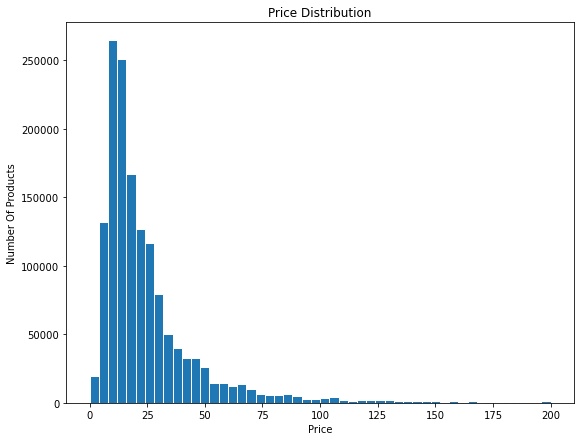

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.hist(train_df['price'],bins=50,range=[0,200],edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel("Number Of Products")

plt.show()

### Distribution of price is skewed right, therefore this needs to be normally distributed
### The price = log(price+1)

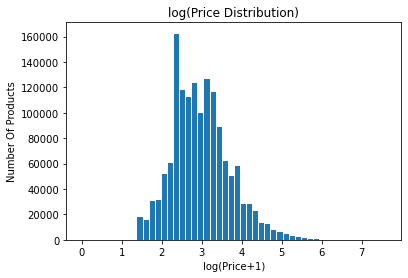

In [ ]:
plt.hist(np.log(train_df['price'] + 1),bins=50,edgecolor='white')
plt.title("log(Price Distribution)")
plt.xlabel("log(Price+1)")
plt.ylabel("Number Of Products")
plt.show()

In [ ]:
train_df['log_price'] = np.log(train_df['price'] + 1)

In [ ]:
train_df['log_price'].describe()

count    1.482535e+06
mean     2.979059e+00
std      7.492094e-01
min      0.000000e+00
25%      2.397895e+00
50%      2.890372e+00
75%      3.401197e+00
max      7.605890e+00
Name: log_price, dtype: float64

In [ ]:
for q in range(10, 110, 10):
    print(str(q) + " percentile = ", np.percentile(train_df.log_price, q))

10 percentile =  2.0794415416798357
20 percentile =  2.3978952727983707
30 percentile =  2.5649493574615363
40 percentile =  2.70805020110221
50 percentile =  2.8903717578961645
60 percentile =  3.044522437723423
70 percentile =  3.295836866004329
80 percentile =  3.555348061489413
90 percentile =  3.9512437185814275
100 percentile =  7.605890001053122


In [ ]:
print(str(99) + " percentile = ", np.percentile(train_df.log_price, 99))

99 percentile =  5.14166355650266


### log(price + 1) is now normally distributed.

# Creating new feature BRAND_CATEGORY

1. Brand-category will have 3 values - expensive, affordable, cheap
2. expensive  -->   log_price > 4
3. affordable -->   2 < log_price < 4
4. cheap      -->   log_price < 2

In [ ]:
        
def brand_category_func(price):

    if price > 4:
        return "expensive"
    elif price > 2 and price < 4:
        return "affordable"
    elif price < 2:
        return "cheap"



In [ ]:
def create_brand_category(df):
    df['brand_category'] = df.apply(lambda x: brand_category_func(x.log_price), axis=1)
    return df

In [ ]:
train_df = create_brand_category(train_df)

In [ ]:
train_df.head(5)

Unnamed: 0  train_id                                 name  \
0           0         0  MLB Cincinnati Reds T Shirt Size XL   
1           1         1     Razer BlackWidow Chroma Keyboard   
2           2         2                       AVA-VIV Blouse   
3           3         3                Leather Horse Statues   
4           4         4                 24K GOLD plated rose   

   item_condition_id                                      category_name  \
0                  3                                  Men/Tops/T-shirts   
1                  3  Electronics/Computers & Tablets/Components & P...   
2                  1                        Women/Tops & Blouses/Blouse   
3                  1                 Home/Home Décor/Home Décor Accents   
4                  1                            Women/Jewelry/Necklaces   

  brand_name  price  shipping  \
0      other   10.0         1   
1      Razer   52.0         0   
2     Target   10.0         1   
3      other   35.0         1   
4      other   44.0         0   

                                    item_description        cat_1  \
0                                 No description yet          Men   
1  This keyboard is in great condition and works ...  Electronics   
2  Adorable top with a hint of lace and a key hol...        Women   
3  New with tags. Leather horses. Retail for [rm]...         Home   
4          Complete with certificate of authenticity        Women   

                 cat_2               cat_3  log_price brand_category  
0                 Tops            T-shirts   2.397895     affordable  
1  Computers & Tablets  Components & Parts   3.970292     affordable  
2       Tops & Blouses              Blouse   2.397895     affordable  
3           Home Décor  Home Décor Accents   3.583519     affordable  
4              Jewelry           Necklaces   3.806662     affordable

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
dtype: bool

In [ ]:
train_df.to_csv("data/train_new.csv")

# Reading Train data

In [ ]:
train_df = pd.read_csv("data/train_new.csv").drop(['Unnamed: 0'],axis=1)
train_df.isnull().any()

Unnamed: 0.1         False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
dtype: bool

# EDA

# Name

In [ ]:
unique_product_names = train_df['name'].value_counts()

In [ ]:
unique_product_names[:10]

bundle                  2778
lularoe tc leggings     1126
lularoe os leggings      897
coach purse              698
american eagle jeans     671
miss me jeans            670
reserved                 654
on hold                  562
michael kors purse       557
michael kors wallet      489
Name: name, dtype: int64

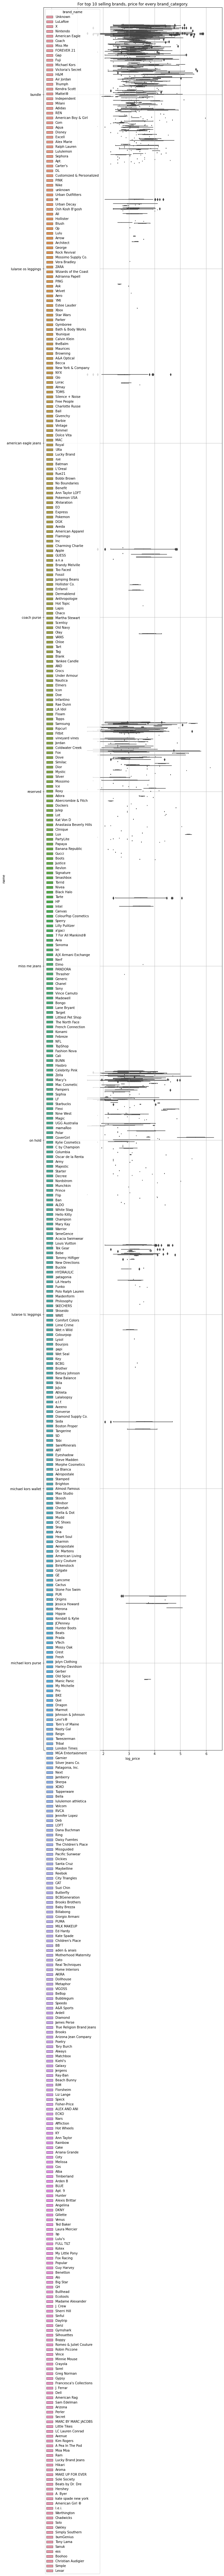

In [ ]:
plt.figure(figsize=(10,100))
plt.title('For top 10 selling brands, price for every brand_category.')

# dataframe of top 10 selling brand-names
df = train_df[train_df['name'].isin(unique_product_names.index[0:10])]

sns.boxplot(x = "log_price", y = "name", orient = "h", hue="brand_name", data=df)

plt.grid()
plt.show()

# Brand Name

Number of Unique Brands: 4811


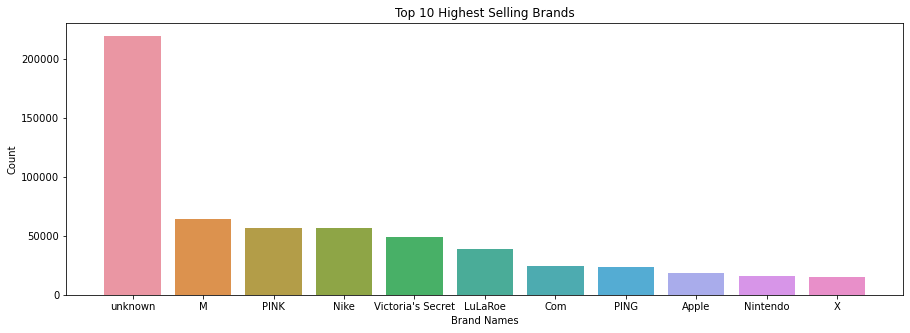

In [ ]:
unique_brands=train_df['brand_name'].value_counts()

print("Number of Unique Brands: {}".format(len(unique_brands)))

plt.figure(figsize=(15,5))
sns.barplot(unique_brands.index[0:11],unique_brands.values[0:11])
plt.title('Top 10 Highest Selling Brands')
plt.xlabel('Brand Names')
plt.ylabel('Count')
plt.plot()
plt.show()

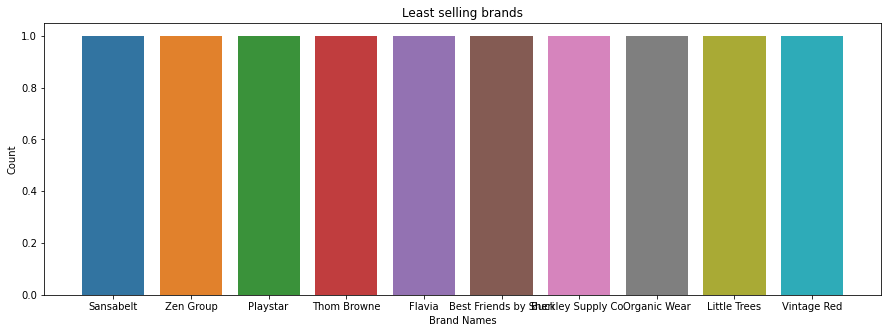

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(unique_brands.index[-10:],unique_brands.values[-10:])
plt.title('Least selling brands')
plt.xlabel('Brand Names')
plt.ylabel('Count')
plt.plot()
plt.show()

#### Observations

1. Data has a very large number of missing brand names.

2. PINK, Nike, Victoria's Secret and LuLaRoe have most products that are being sold.

3. Thought a large percentage of data missing for brand name, unknown is having top product count.

4. P'KOLINO, BEBESOUNDS are the brands of least expensive ones.

In [ ]:
free_products_df = train_df[train_df['log_price']==0] # dataframe of products, having price = 0

In [ ]:
# for each category, count of the free products
free_products_brands = free_products_df['brand_name'].value_counts() 
free_products_brands

unknown              110
M                     47
Nike                  38
LuLaRoe               30
Victoria's Secret     25
                    ... 
IZOD                   1
Level                  1
New Era                1
Sophia                 1
Toys R Us              1
Name: brand_name, Length: 327, dtype: int64

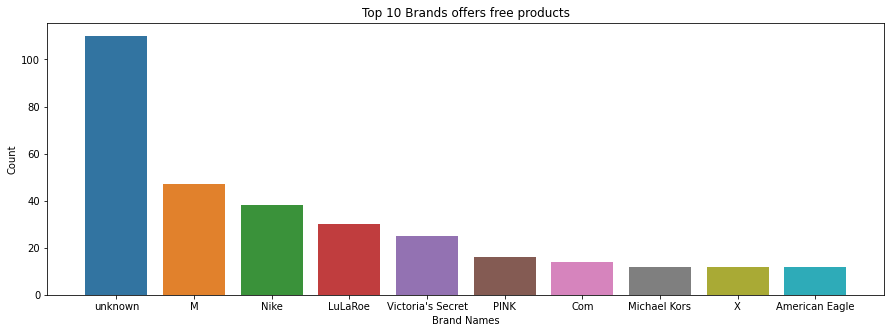

In [ ]:
plt.figure(figsize=(15,5))

# top 10 brands, descending order of count
sns.barplot(free_products_brands.index[0:10],free_products_brands.values[0:10]) 
plt.title('Top 10 Brands offers free products')
plt.xlabel('Brand Names')
plt.ylabel('Count')
plt.plot()
plt.show()

#### Observation

1. Nike, LuLaRoe, Victoria's Secret, PINK, Michael Kors, Nintendo are the brand names, offers free products.
2. Though 43 % of brand names are missing, therefore unknown brand names is dominating.

### Top 10 expensive brand names

In [ ]:
# grouping by brandnames and finding mean for each brand name in descending order
brandname__price_med = train_df.groupby(['brand_name'], as_index=True)['price'].median().sort_values(ascending=False)

brandname__price_med[:10] # top brands for which products are costly.

brand_name
Auto Meter             344.0
Proenza Schouler       315.5
Blendtec               250.0
Dainese                230.0
Frédérique Constant    224.0
iRobot                 207.5
David Yurman           206.0
Brioni                 200.0
Stephen Webster        200.0
Alexander Wang         191.0
Name: price, dtype: float64

In [ ]:
train_df.loc[train_df['brand_name']=="Demdaco",'item_condition_id']

379550     2
460147     3
910065     3
1362087    2
Name: item_condition_id, dtype: int64

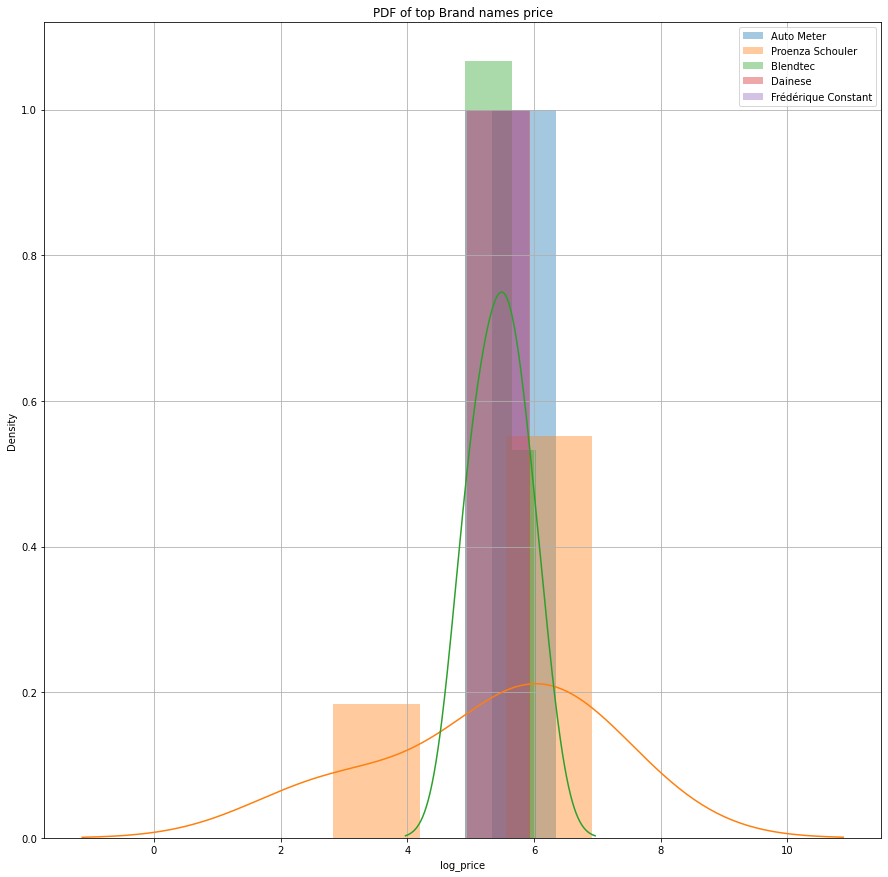

In [ ]:
plt.figure(figsize=(15,15))
plt.title('PDF of top Brand names price')

for cat_name in brandname__price_med.index[0:5]:
    
    category_name_price  = train_df.loc[train_df['brand_name']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

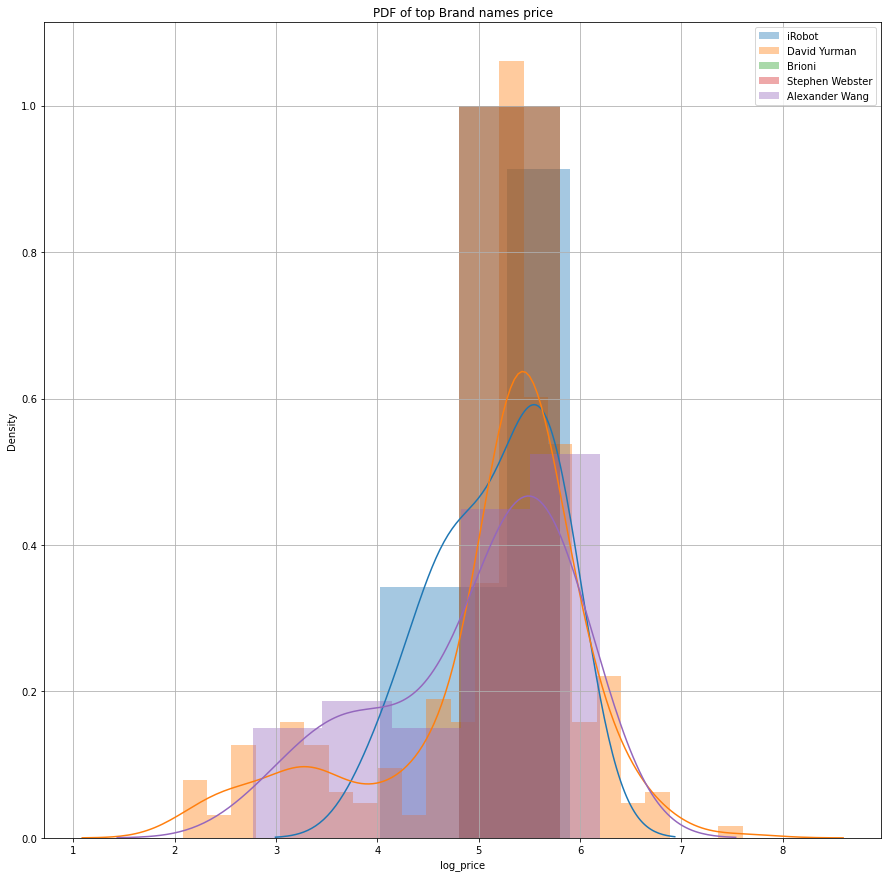

In [ ]:
plt.figure(figsize=(15,15))
plt.title('PDF of top Brand names price')

for cat_name in brandname__price_med.index[5:10]:
    
    category_name_price  = train_df.loc[train_df['brand_name']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

#### Observation

1. DEMDACO has wide range of price for it's products among top expensive brands.
2. DAVID YURMAN, BLENDTEC products are being sold highest among others.

### Top 10 selling brands and their price distribution

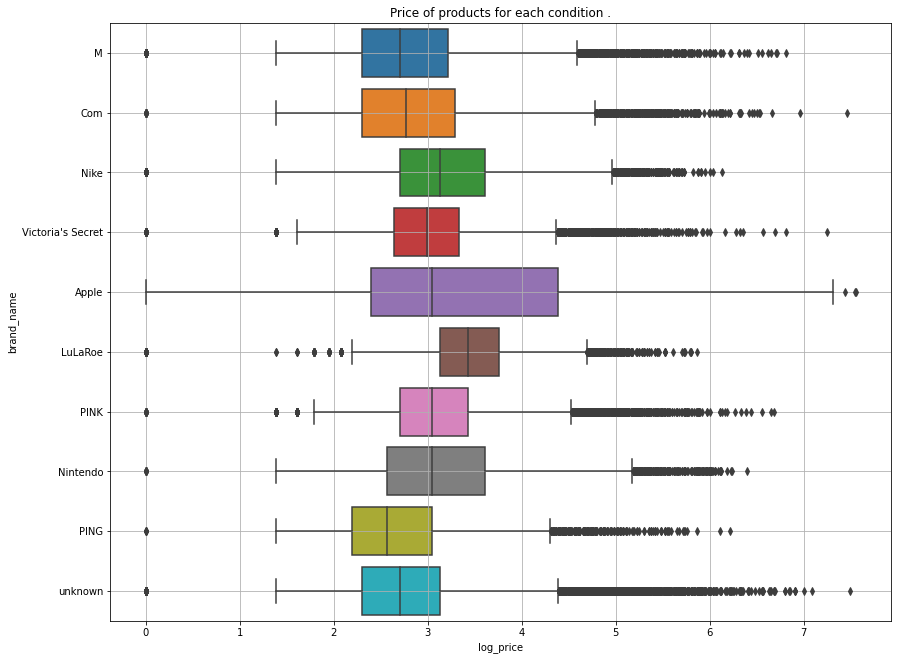

In [ ]:
plt.figure(figsize=(14,11))
plt.title('Price of products for top selling brands.')

df = train_df[train_df['brand_name'].isin(unique_brands.index[0:10])]
sns.boxplot(x = df.log_price, y = df['brand_name'], orient = "h")


plt.grid()
plt.show()

#### Observation

1. Among top 10 selling brands LuLaRoe is most expensive and PING is least expensive.

### Brand Names, Brand_category, Price

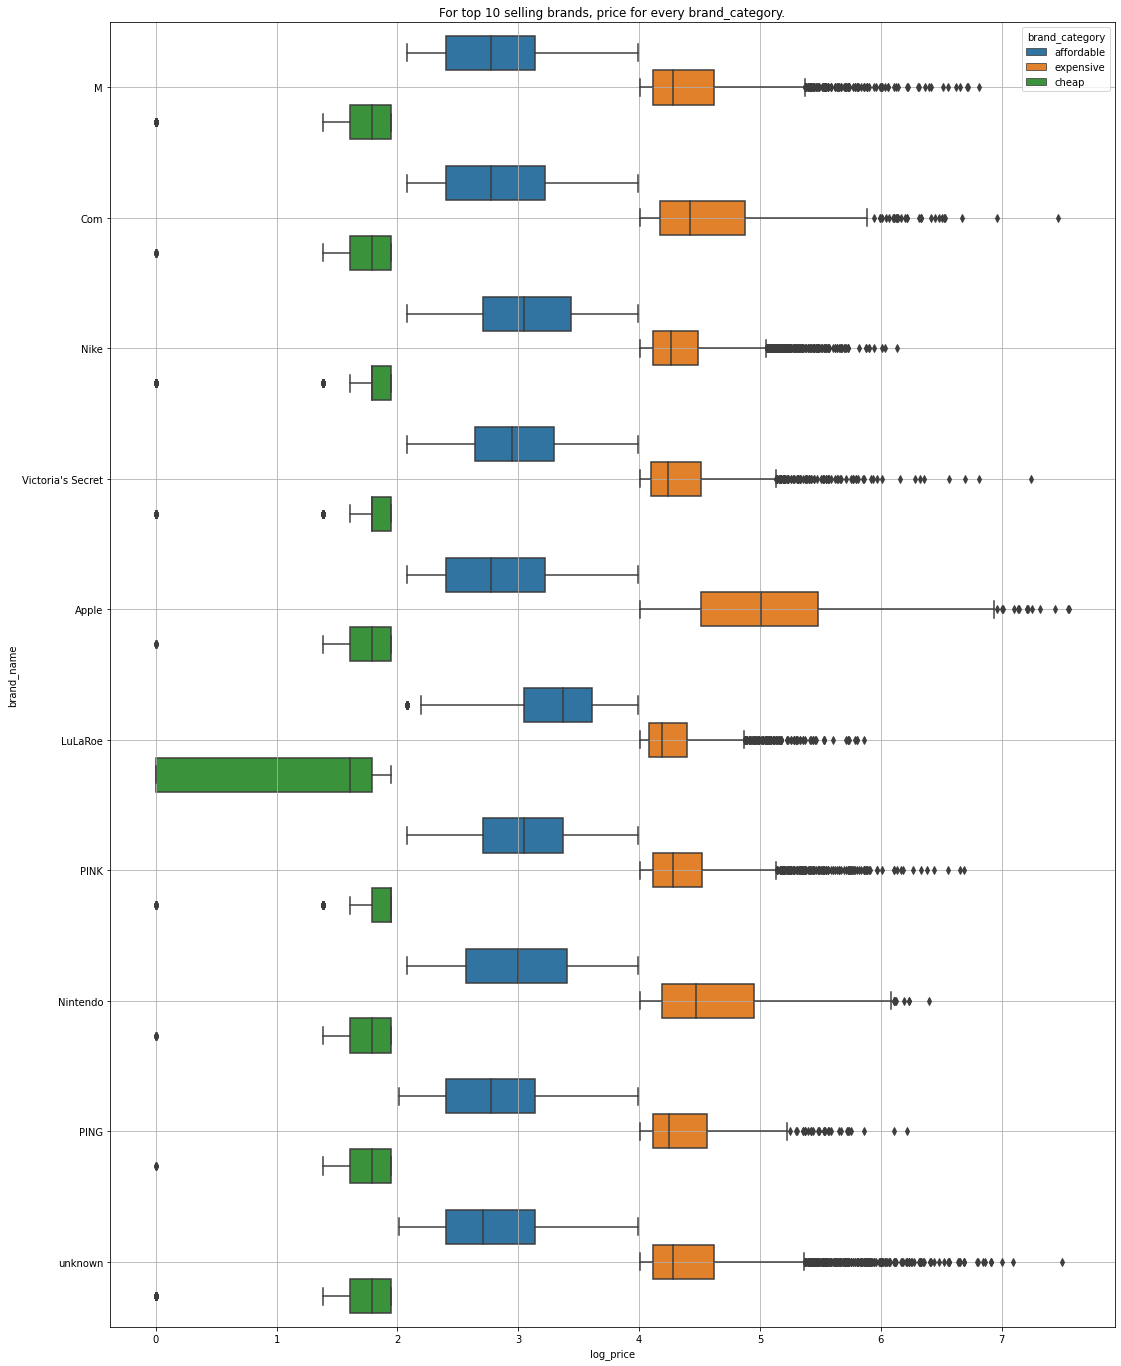

In [ ]:

plt.figure(figsize=(18,24))
plt.title('For top 10 selling brands, price for every brand_category.')

# dataframe of top 10 selling brand-names
df = train_df[train_df['brand_name'].isin(unique_brands.index[0:10])]

sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="brand_category", data=df)

plt.grid()
plt.show()



#### Observation

1. Among top 10 selling brands Apple has most expensive products where as LuLaRoe is least expensive brand.
2. Apple has most products expensive ones, while LuLaRoe has most products cheapest ones.

### Brand Name, Item condition id, price

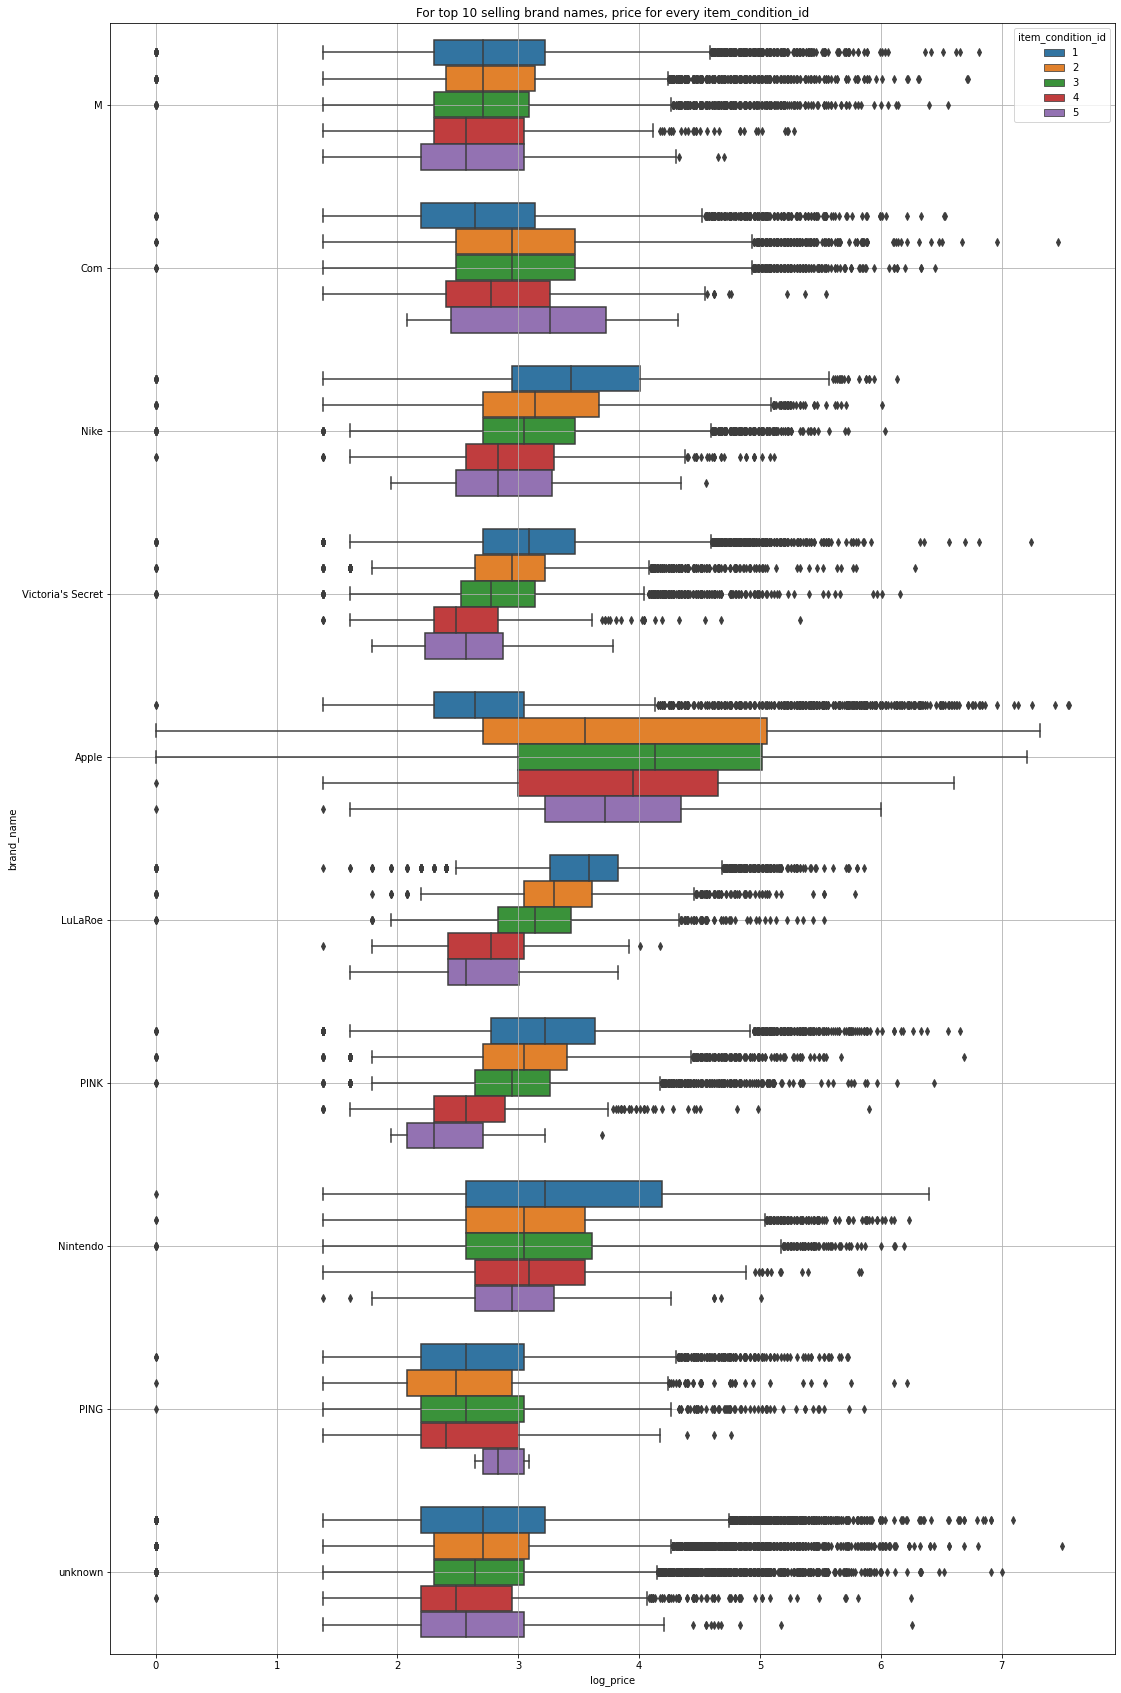

In [ ]:
plt.figure(figsize=(18,30))
plt.title("For top 10 selling brand names, price for every item_condition_id")

# dataframe of top 10 selling brand-names
df = train_df[train_df['brand_name'].isin(unique_brands.index[0:10])]
sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. For every Top selling brands, for item_condition_id 1 products price is more.
2. Apple has more products of item_condition_id 1, and products of item_condition_id 3 is very expensive.

### Brand name, shipping, price

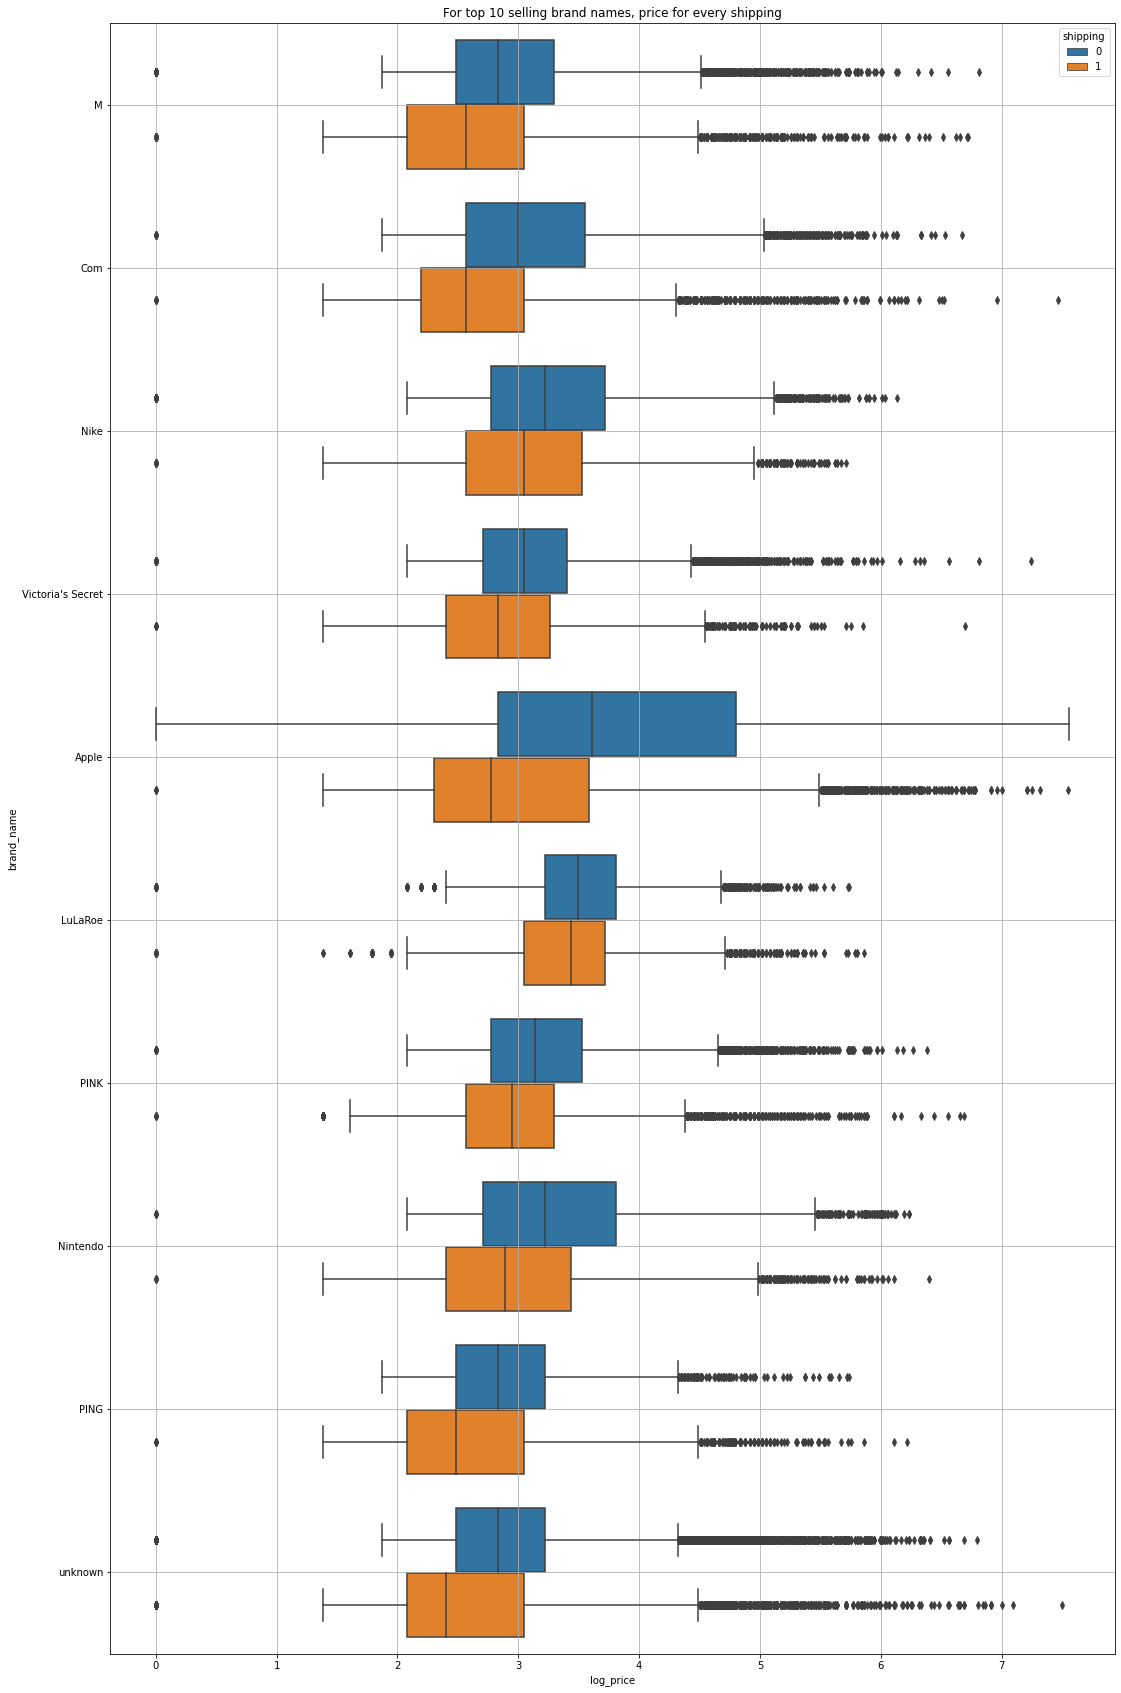

In [ ]:
plt.figure(figsize=(18,30))
plt.title("For top 10 selling brand names, price for every shipping")

# dataframe of top 10 selling brand-names
df = train_df[train_df['brand_name'].isin(unique_brands.index[0:10])]
sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation: 
1. Usually when price of the product is high, Customer needs to pay shipping charge.

### Brand Name, product name, price

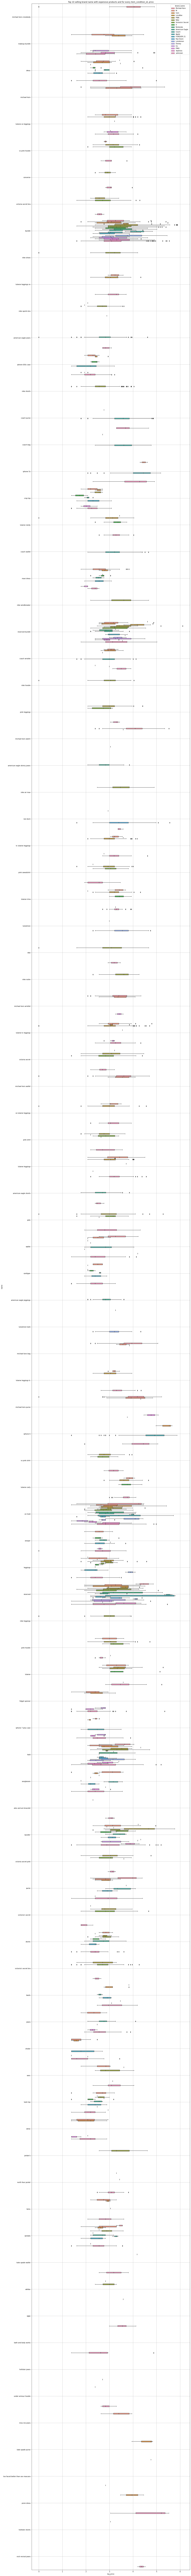

In [ ]:
plt.figure(figsize=(18,300))
plt.title("Top 10 selling brand name with expensive products and for every item_condition_id, price")


df = train_df[(train_df['brand_name'].isin(unique_brands.index[:20])) & (train_df['name'].isin(unique_product_names.index[:100]))]

sns.boxplot(x = "log_price", y = "name", orient = "h", hue="brand_name", data=df)

plt.grid()
plt.show()

#### Observation:
1. For every brand, product price varies.

### Brand name, item_condition_id, brand_category=expensive, price

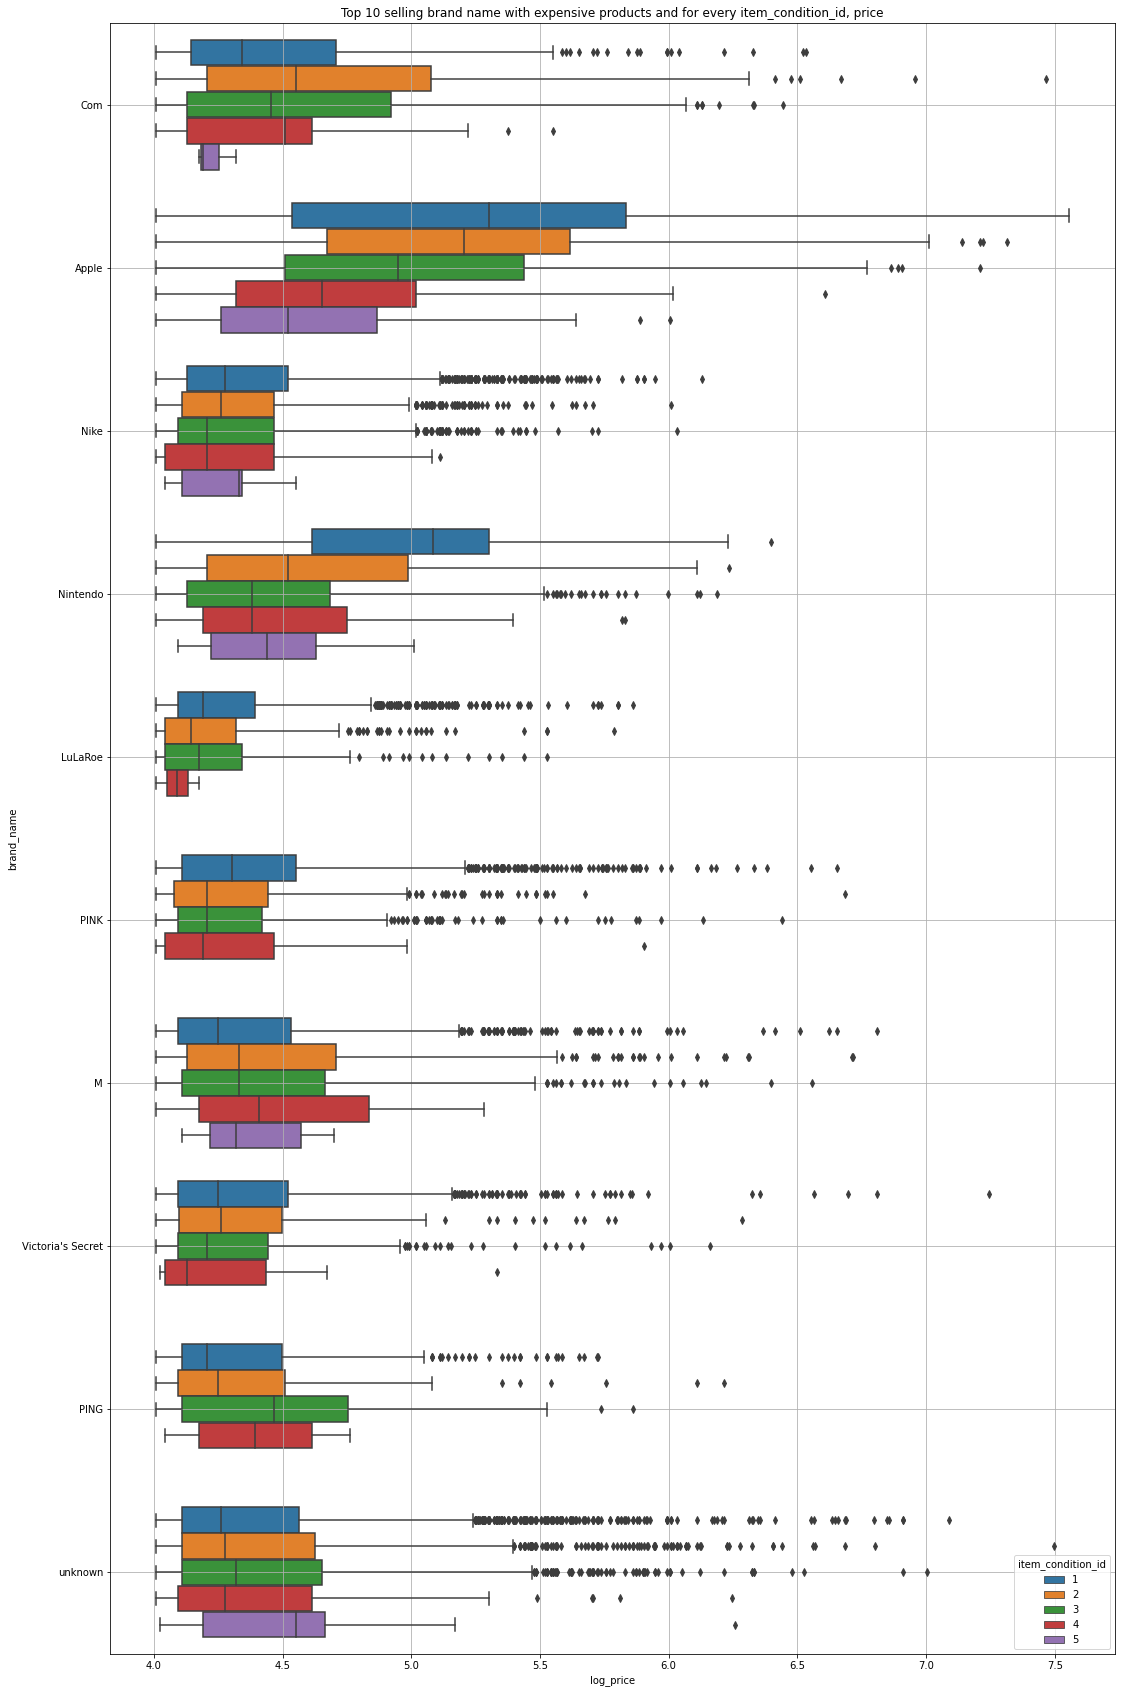

In [ ]:

plt.figure(figsize=(18,30))
plt.title("Top 10 selling brand name with expensive products and for every item_condition_id, price")


df = train_df[(train_df['brand_name'].isin(unique_brands.index[:10])) & (train_df['brand_category']=='expensive')]

sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()



#### Observation: 
1. Among top selling expensive brands, Apple has very expensive products, where LuLaRoe has least least expensive products.
2. 1,2 are expensive item_condition_ids.

### Brand name, item_condition_id, brand_category=affordable, price

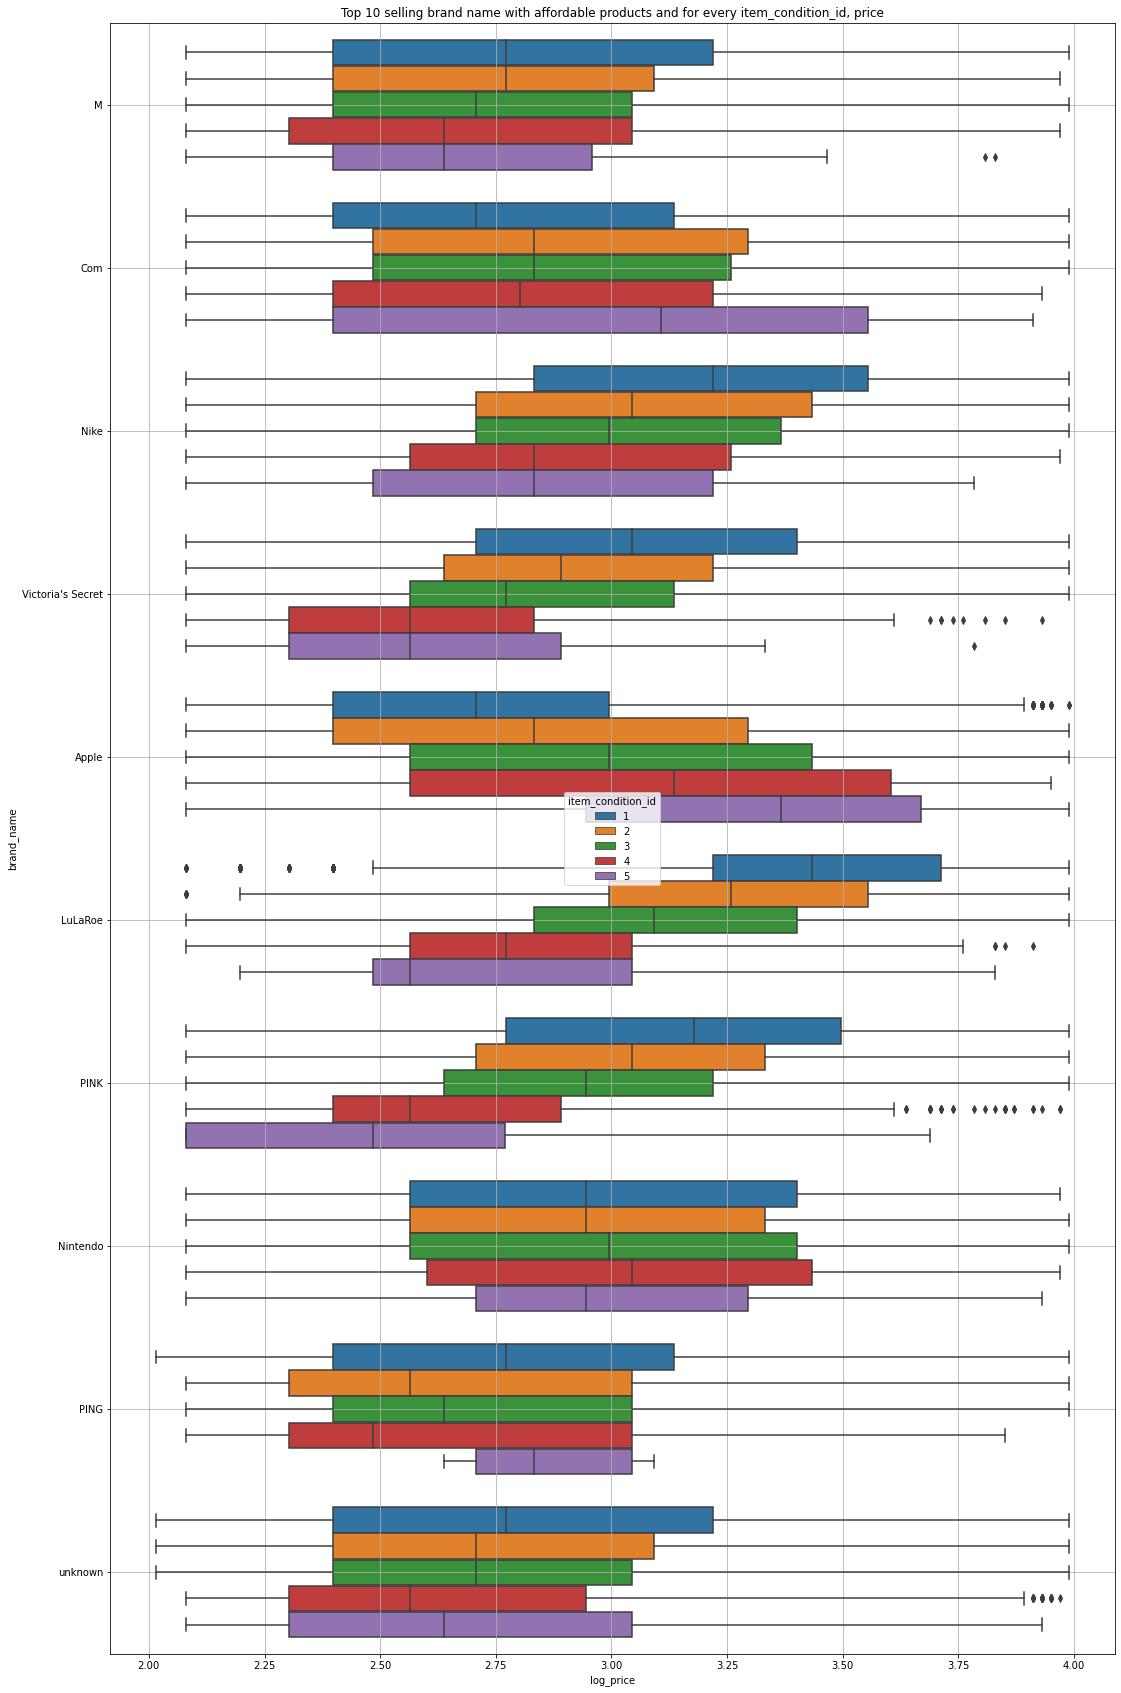

In [ ]:

plt.figure(figsize=(18,30))
plt.title("Top 10 selling brand name with affordable products and for every item_condition_id, price")


df = train_df[(train_df['brand_name'].isin(unique_brands.index[:10]))  & (train_df['brand_category']=='affordable')]

sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()



#### Observation:

1. For top selling brands, most item_condition_id of 3, 4 has affordable price. 

### Brand name, item_condition_id, brand_category=cheap, price

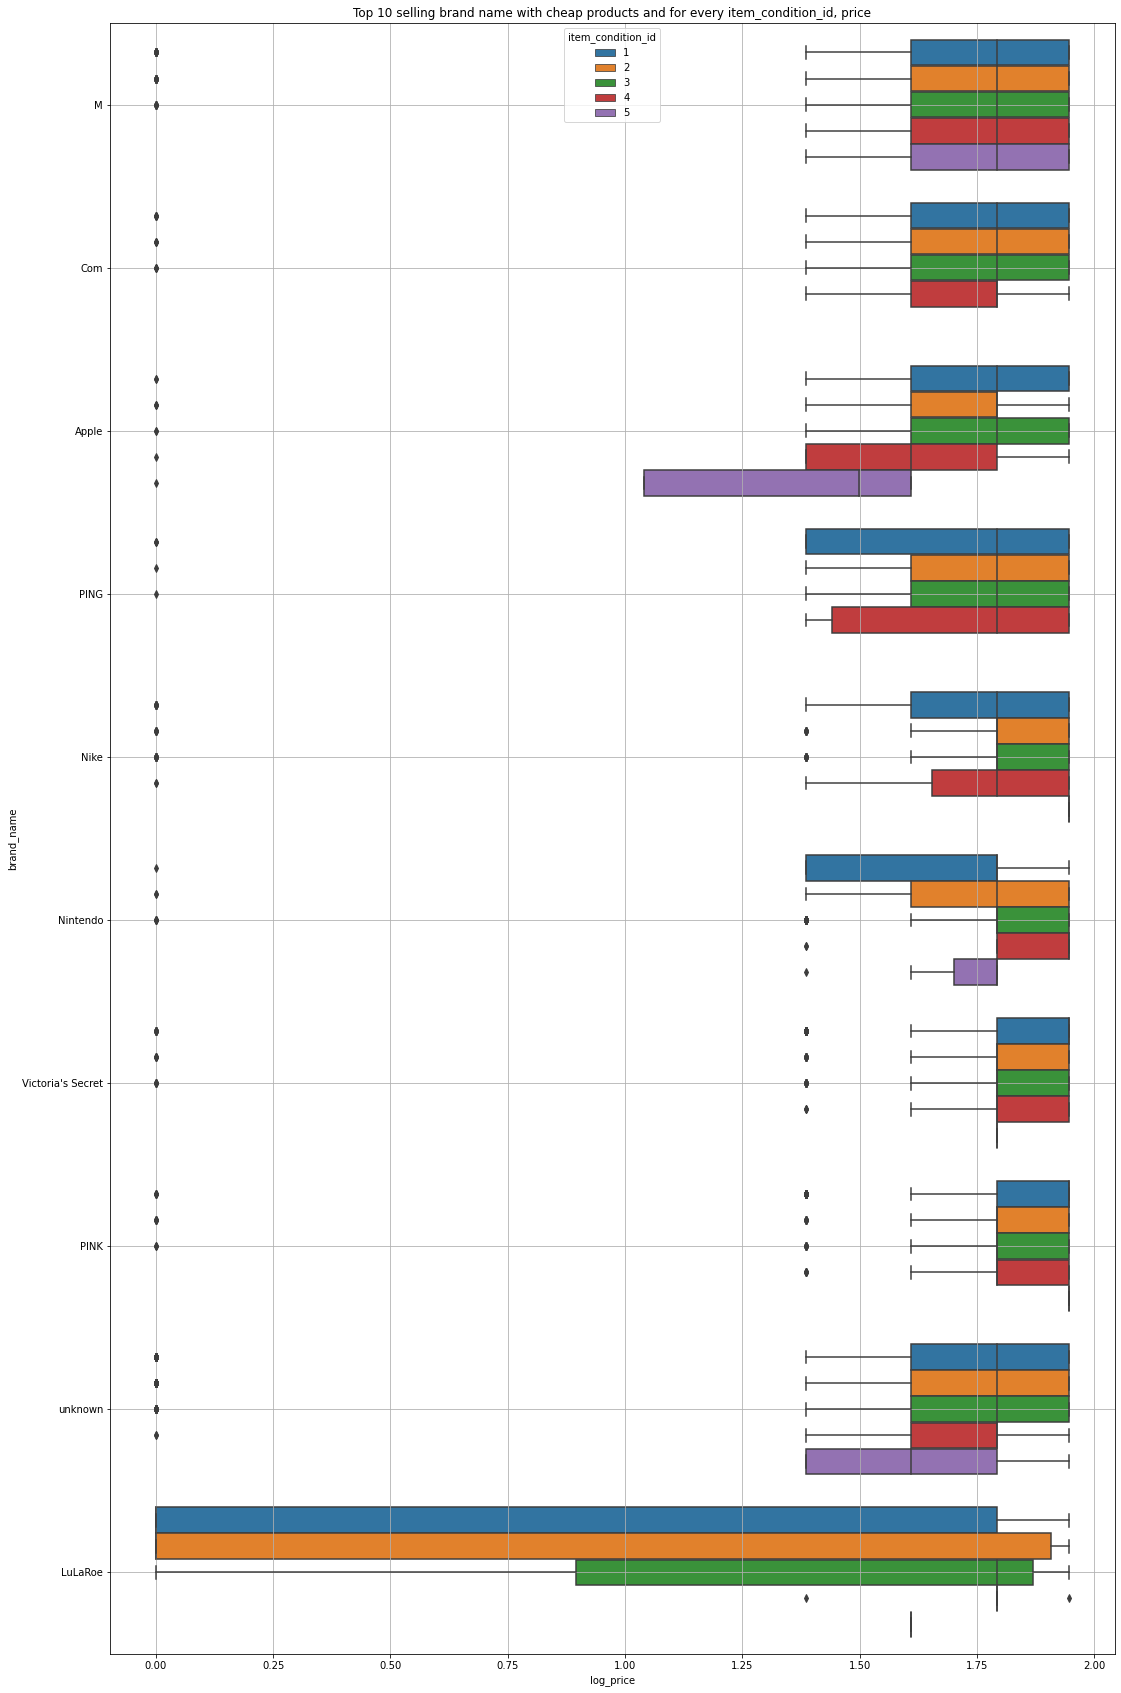

In [ ]:

plt.figure(figsize=(18,30))
plt.title("Top 10 selling brand name with cheap products and for every item_condition_id, price")


df = train_df[(train_df['brand_name'].isin(unique_brands.index[:10]))  & (train_df['brand_category']=='cheap')]

sns.boxplot(x = "log_price", y = "brand_name", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()



In [ ]:
p1 = np.exp(1.5) - 1
p2 = np.exp(2) - 1

p1, p2

(3.4816890703380645, 6.38905609893065)

#### Observation: 
1. Most of the cheap products from top selling brands, have price range between 3.5 to 6.3. 
2. LuLaRoe has high range of cheap products.

# Item Condition

### Number of products for every item_condition_id

In [ ]:
count=train_df['item_condition_id'].value_counts()
count

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

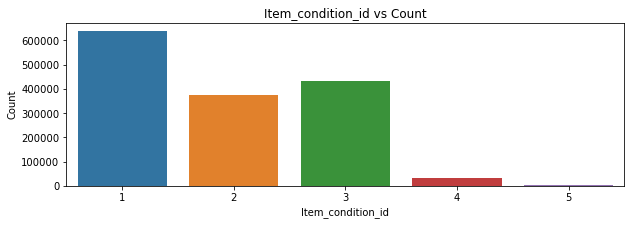

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(count.index, count.values)
plt.title('Item_condition_id vs Count')
plt.xlabel('Item_condition_id')
plt.ylabel('Count')
plt.show()

#### Observation

There are 5 types of conditions for products.

Products with item_condition 1 are sold largly where as with item_condition 5 are least sold ones.

### Price for every item_condition_id

<AxesSubplot:title={'center':'Price for every item_condition_id'}, xlabel='item_condition_id', ylabel='log_price'>

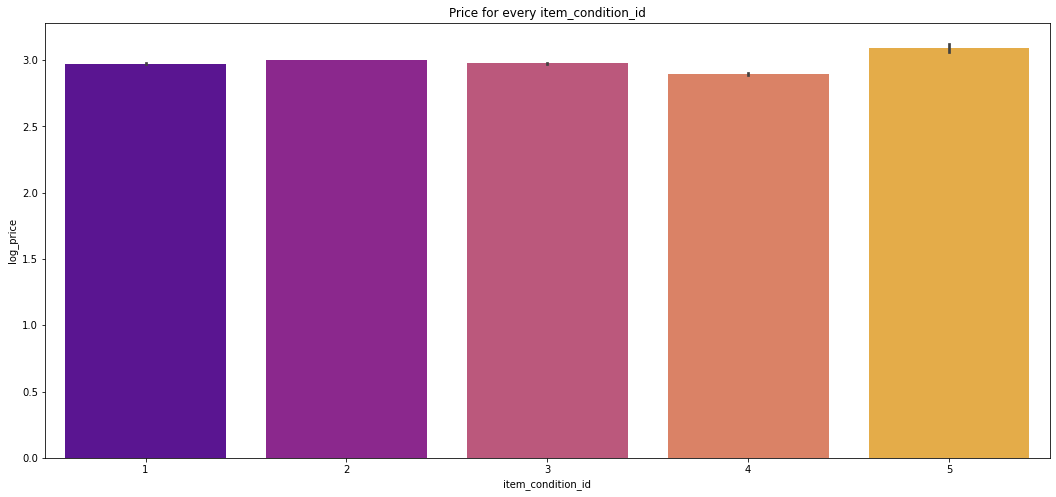

In [ ]:
plt.figure(figsize=(18,8))
plt.title("Price for every item_condition_id")

sns.barplot(x ='item_condition_id', y ='log_price', data = train_df, palette ='plasma')

#### Observation

It can be observed that, products with item_condition_id 5, have high price.

products with item_condition_id 1, 2, 3 are of same price range.

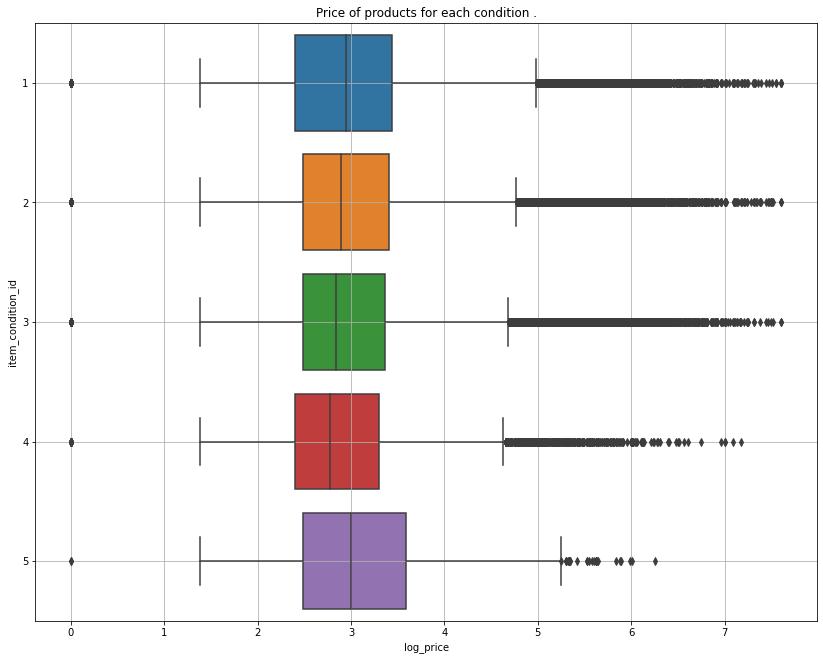

In [ ]:
plt.figure(figsize=(14,11))
plt.title('Price of products for each condition .')

sns.boxplot(x = train_df.log_price, y = train_df['item_condition_id'], orient = "h")


plt.grid()
plt.show()

#### Observation

1. Most of Item_condition_id 5 products are sold at higher price than other item_condition_ids.

### Item condition id, brand category and price

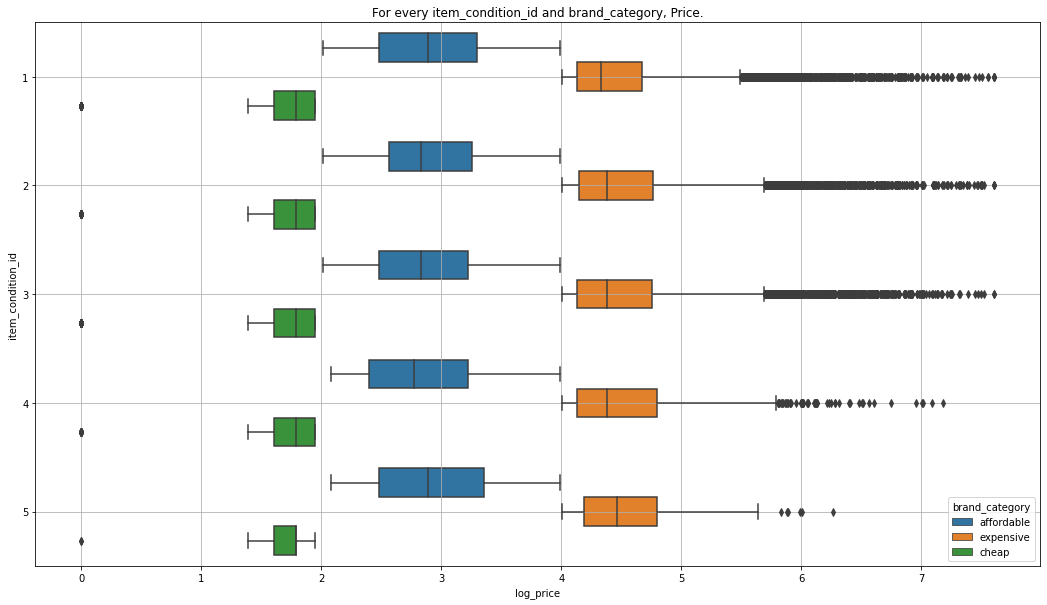

In [ ]:
plt.figure(figsize=(18,10))
plt.title('For every item_condition_id and brand_category, Price.')

sns.boxplot(x = "log_price", y = "item_condition_id", orient = "h", hue="brand_category", data=train_df)

plt.grid()
plt.show()

#### Observation: 

1. There are very less number of Cheap products of item_condition_id 5.
2. For every expensive brand products, price range is same across all condition_ids. 

### Item condition id, shipping and price

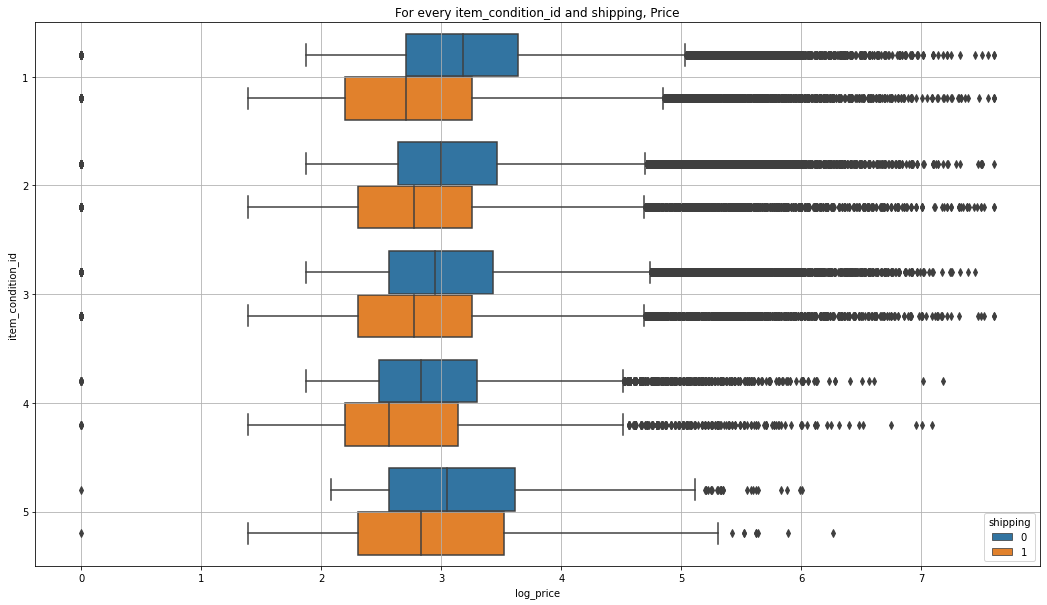

In [ ]:
plt.figure(figsize=(18,10))
plt.title('For every item_condition_id and shipping, Price')

sns.boxplot(x = "log_price", y = "item_condition_id", orient = "h", hue="shipping", data=train_df)

plt.grid()
plt.show()

#### Observation: 
1. For every item_condition_id, if shipping charge is paid by the customer, price is usually high.

### item_condition_id, shipping, price, brand_category = Expensive

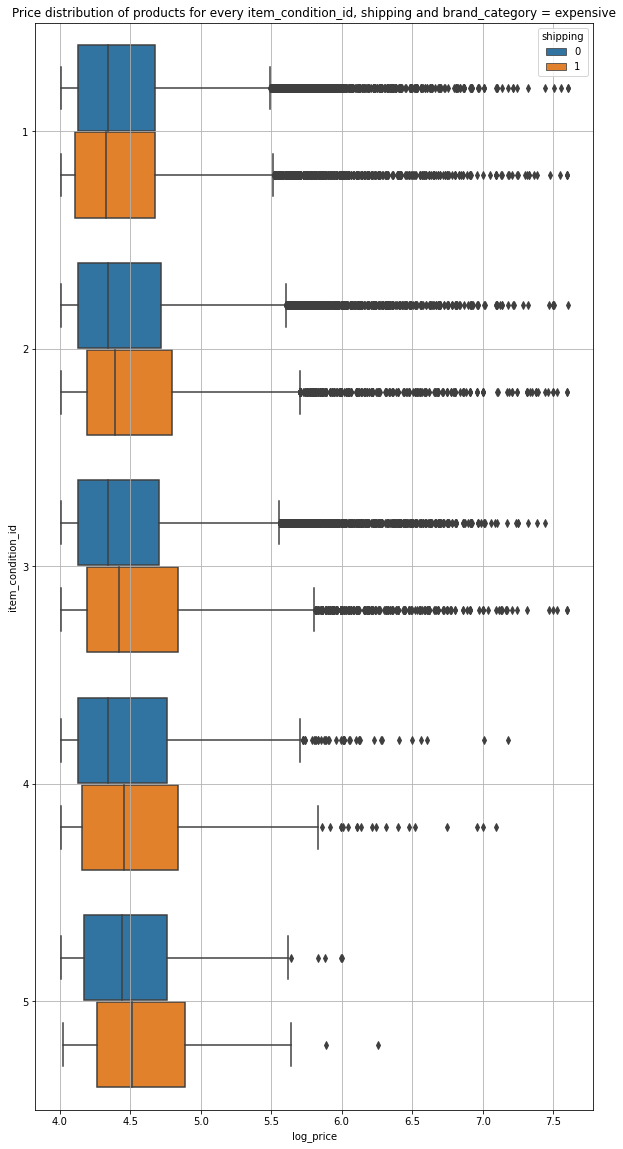

In [ ]:
plt.figure(figsize=(10,20))
plt.title('Price distribution of products for every item_condition_id, shipping and brand_category = expensive')

df = train_df[(train_df['brand_category']=='expensive')]
sns.boxplot(x = "log_price", y = "item_condition_id", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation:
1. For expensive products for every item_condition_id, shipping charge is paid by seller except for item_condition_id 1.

### item_condition_id, shipping, price, brand_category = Affordable

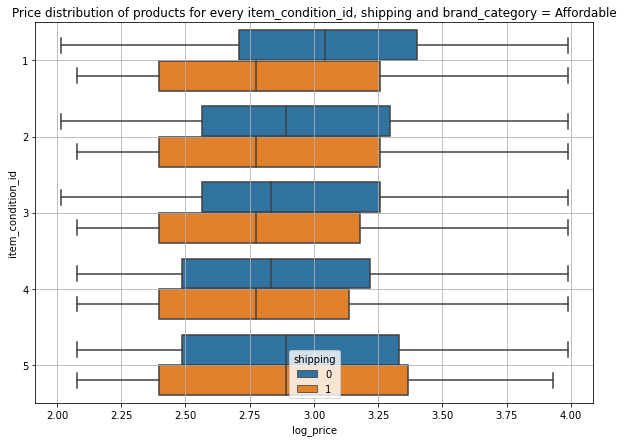

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Price distribution of products for every item_condition_id, shipping and brand_category = Affordable')

df = train_df[(train_df['brand_category']=='affordable')]
sns.boxplot(x = "log_price", y = "item_condition_id", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation:

1. For affordable products, for every item_condition_id, products, shipping charge is paid by Seller itself.  

### item_condition_id, shipping, price, brand_category = Cheap

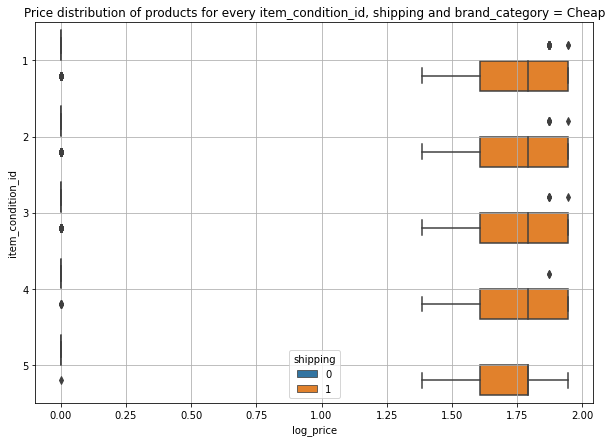

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Price distribution of products for every item_condition_id, shipping and brand_category = Cheap')

df = train_df[(train_df['brand_category']=='cheap')]
sns.boxplot(x = "log_price", y = "item_condition_id", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation:

1. For cheap products, seller is paying hipping charge.

# Shipping

In [ ]:
count=train_df['shipping'].value_counts()
count

0    819435
1    663100
Name: shipping, dtype: int64

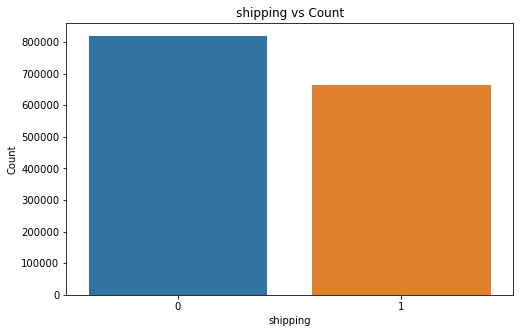

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(count.index,count.values)
plt.title('shipping vs Count')
plt.xlabel('shipping')
plt.ylabel('Count')
plt.show()

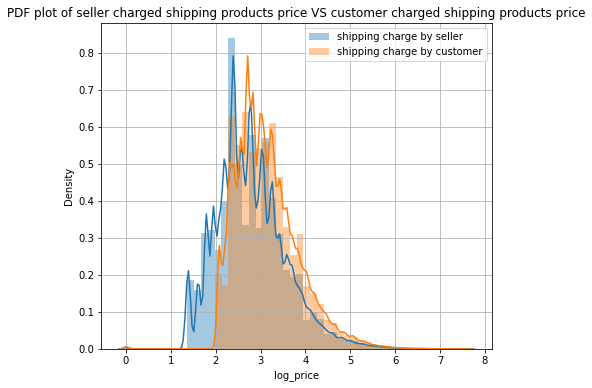

In [ ]:

customer_paid_shipping  = train_df.loc[train_df['shipping']==0,'log_price']
seller_paid_shipping    = train_df.loc[train_df['shipping']==1,'log_price']


plt.figure(figsize=(7,6))

sns.distplot(seller_paid_shipping,label='shipping charge by seller')
sns.distplot(customer_paid_shipping,label='shipping charge by customer')
plt.title('PDF plot of seller charged shipping products price VS customer charged shipping products price')
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

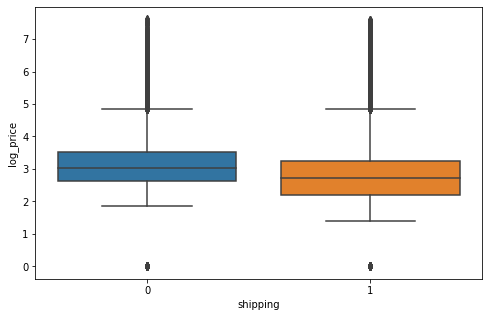

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=train_df['shipping'],y=train_df['log_price'],orient='v')
plt.show()

#### Observation

1. From above plots we can ovserve that, product price is more peaked for products, for which shipping charge is paid by customer, than products for which shipping charge is paid by sellers.

2. products price is higher, when customer pays the shipping charge.

3. For maximum number of products, shipping charge is paid by cutomer. 

### shipping, item_condition_id, price

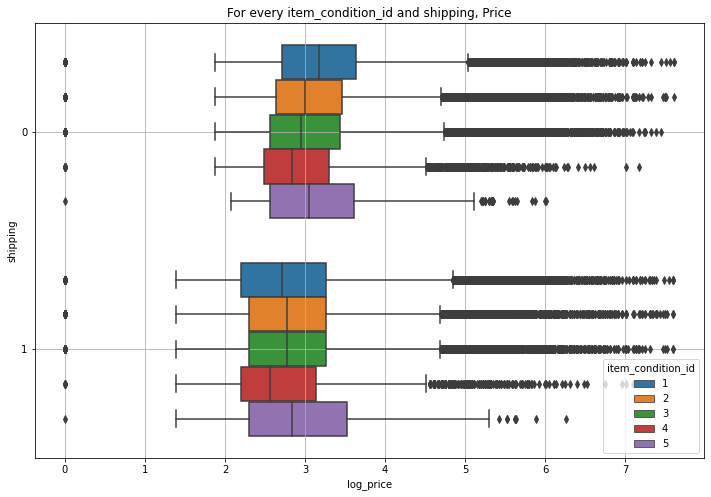

In [ ]:
plt.figure(figsize=(12,8))
plt.title('For every item_condition_id and shipping, Price')

sns.boxplot(x = "log_price", y = "shipping", orient = "h", hue="item_condition_id", data=train_df)

plt.grid()
plt.show()

#### Observation:

1. When customer pays shipping charge, product price is usually high.

### shipping, brand_category, price

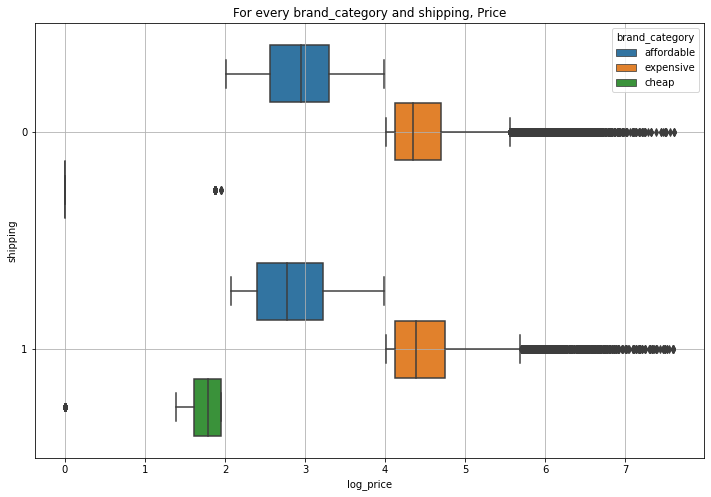

In [ ]:
plt.figure(figsize=(12,8))
plt.title('For every brand_category and shipping, Price')

sns.boxplot(x = "log_price", y = "shipping", orient = "h", hue="brand_category", data=train_df)

plt.grid()
plt.show()

#### Observation:
1. For most of the affordable products, shipping charge is paid by customer.
2. Sellers usually pay shipping charge for cheap products,

# Category name

In [ ]:
cat_count=train_df['category_name'].value_counts()

print("There are {} types of cat_2 products.".format(len(cat_count)))


There are 1288 types of cat_2 products.


In [ ]:
print("Number of Catagory Name Products are being sold on Mercari in descending order.\n")
print(cat_count)

Number of Catagory Name Products are being sold on Mercari in descending order.

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Knitting/Cozy                                1
Home/Kids' Home Store/Nursery Furniture               1
Home/Home Appliances/Garbage Disposals                1
Vintage & Collectibles/Paper Ephemera/Map             1
Handmade/Geekery/Videogame                            1
Name: category_name, Length: 1288, dtype: int64


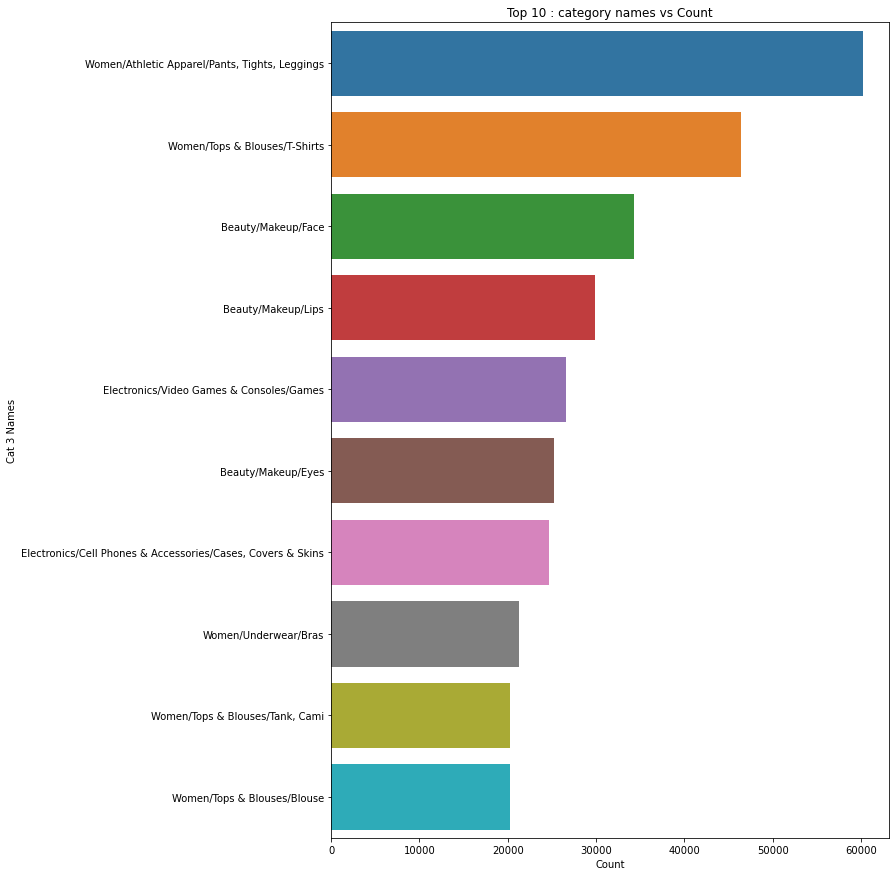

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(cat_count.values[:10],cat_count.index[:10])
plt.title('Top 10 : category names vs Count')
plt.xlabel('Count')
plt.ylabel('Cat 3 Names')
plt.show()

### Top 10 seling category names .

In [ ]:

# grouping by category names and finding mean for each category name in descending order
category_name__price_med = train_df.groupby(['category_name'], as_index=True)['price'].median().sort_values(ascending=False)


category_name__price_med[:20] # top brands for which products are costly.


category_name
Vintage & Collectibles/Antique/Furniture                           195.0
Kids/Strollers/Standard                                            145.0
Home/Home Appliances/Air Conditioners                              131.0
Kids/Strollers/Lightweight                                         105.0
Sports & Outdoors/Golf/Women's Golf Clubs                          100.0
Electronics/Computers & Tablets/Laptops & Netbooks                 100.0
Kids/Strollers/Travel Systems                                       95.0
Women/Women's Handbags/Satchel                                      90.0
Electronics/Computers & Tablets/Desktops & All-In-Ones              89.5
Handmade/Woodworking/Sports                                         86.0
Other/Automotive/Oils & Fluids                                      85.0
Handmade/Pets/Blanket                                               71.0
Electronics/Cameras & Photography/Lenses & Filters                  70.0
Men/Sweats & Hoodies/Track & Sweat Su

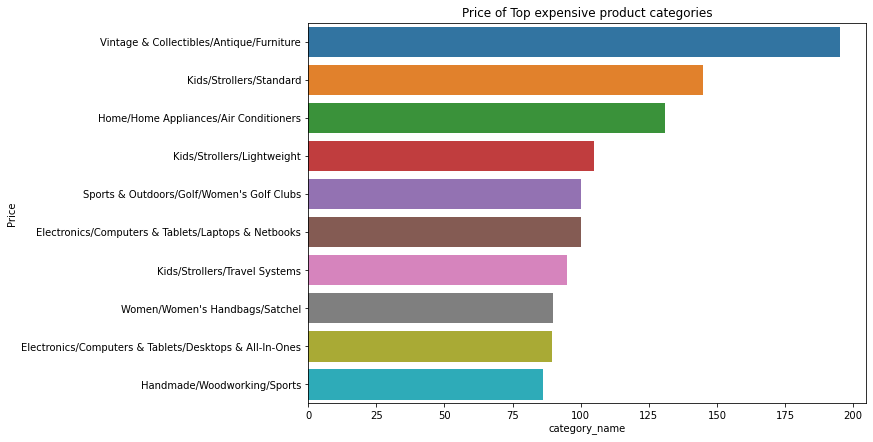

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=category_name__price_med.values[:10], y=category_name__price_med.index[:10],orient='h')
plt.title('Price of Top expensive product categories')
plt.xlabel('category_name')
plt.ylabel('Price')
plt.show()

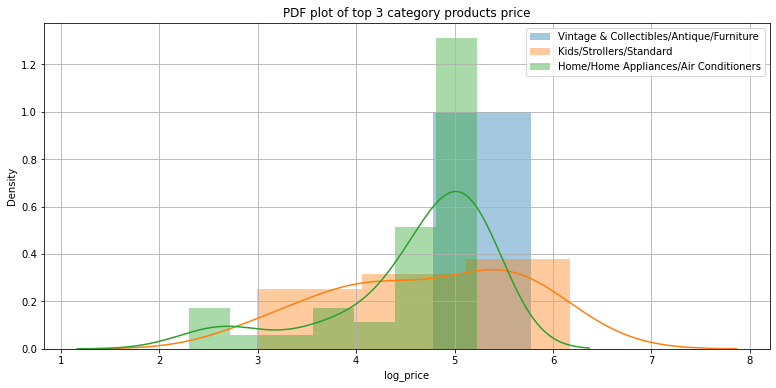

In [ ]:
plt.figure(figsize=(13,6))
plt.title('PDF plot of top 3 category products price')

for cat_name in category_name__price_med.index[0:3]:
    
    category_name_price  = train_df.loc[train_df['category_name']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

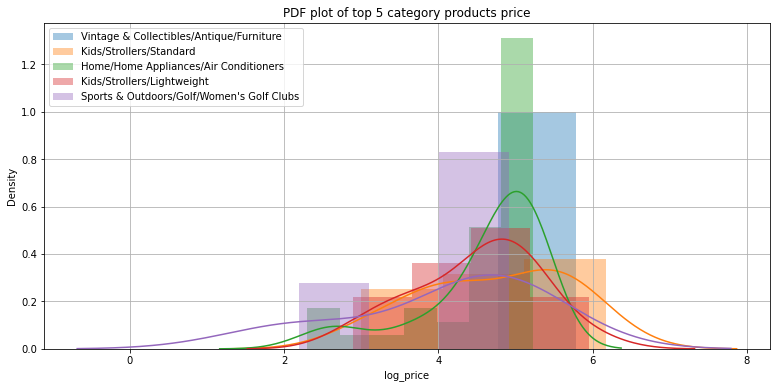

In [ ]:
plt.figure(figsize=(13,6))
plt.title('PDF plot of top 5 category products price')

for cat_name in category_name__price_med.index[:5]:
    
    category_name_price  = train_df.loc[train_df['category_name']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

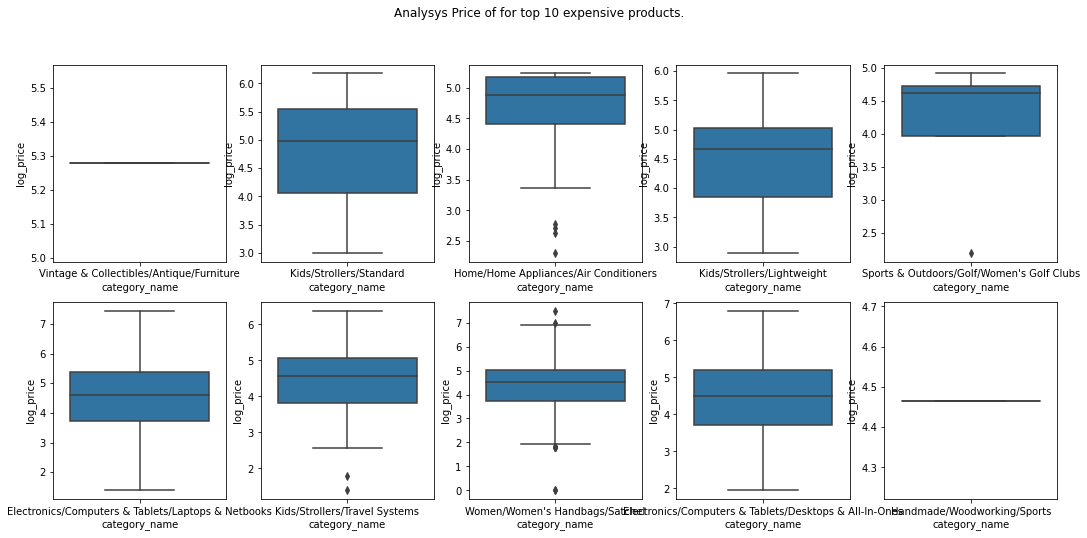

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('Analysys Price of for top 10 expensive products.') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(category_name__price_med.index[:5]):
    
    df_i  = train_df.loc[train_df['category_name'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="category_name", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(category_name__price_med.index[5:10]):
    
    df_i  = train_df.loc[train_df['category_name'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="category_name", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


### Top 10 category for highest selling products  and their price

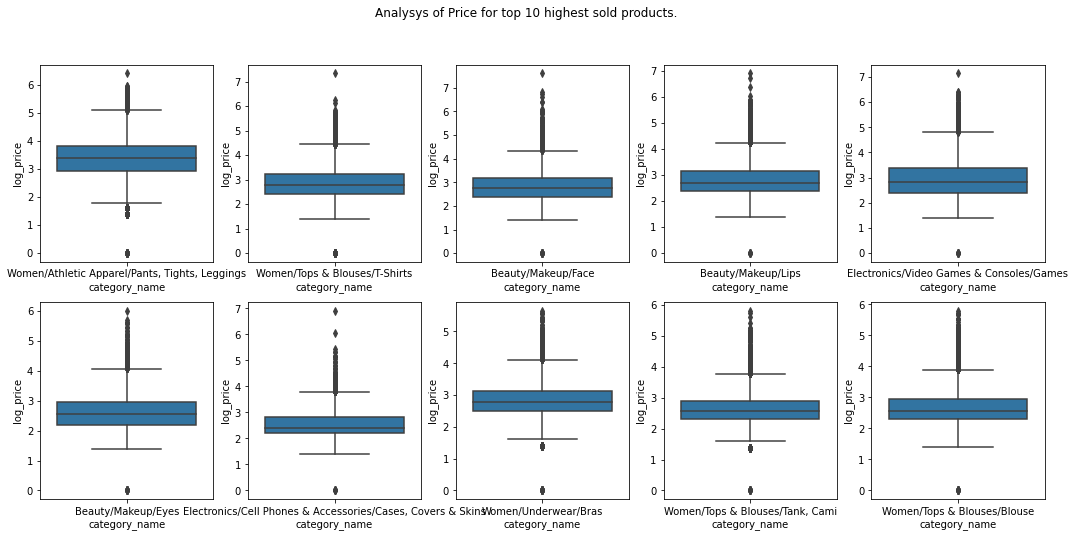

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('Analysys of Price for top 10 highest sold products.') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(cat_count.index[:5]):
    
    df_i  = train_df.loc[train_df['category_name'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="category_name", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(cat_count.index[5:10]):
    
    df_i  = train_df.loc[train_df['category_name'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="category_name", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


#### Observation

1. Handmade/Bags and Purses/Clutch has wide price range for products.
2. Electronics produdts and Kid's stroller are more expensive than Handmade products.
3. Vintage & Collectible furniture products are very expensive and have very narrow range for price. 
4. Women athletic wearing products are being sold very largly of 60k, followed by Women tops of 46k.
5. Among Top 5 category products that are mostly sold on the platform, Women products are sold highest followed by beauty products and Electronics products.
6. Handmade/Bags and Purses/Clutch products are least expensive but has very wide range of price.



### category_name, brand_category, price

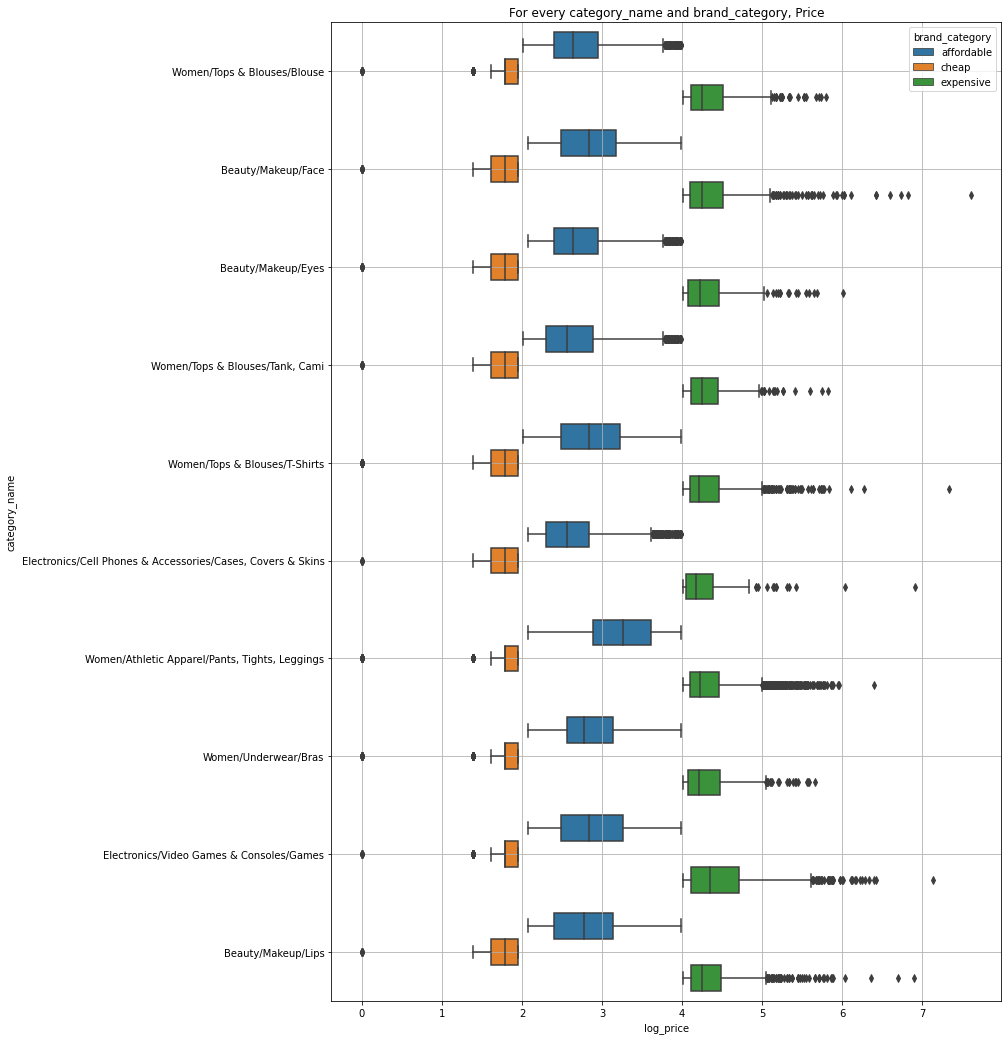

In [ ]:
plt.figure(figsize=(12,18))
plt.title('For every category_name and brand_category, Price')

df = train_df[(train_df['category_name'].isin(cat_count.index[:10]))]
sns.boxplot(x = "log_price", y = "category_name", orient = "h", hue="brand_category", data=df)

plt.grid()
plt.show()

#### Observation:

1. For top selling products category In Expensive price range, Video gaming electronics products has more products.


### category_name, item_condition_id, price

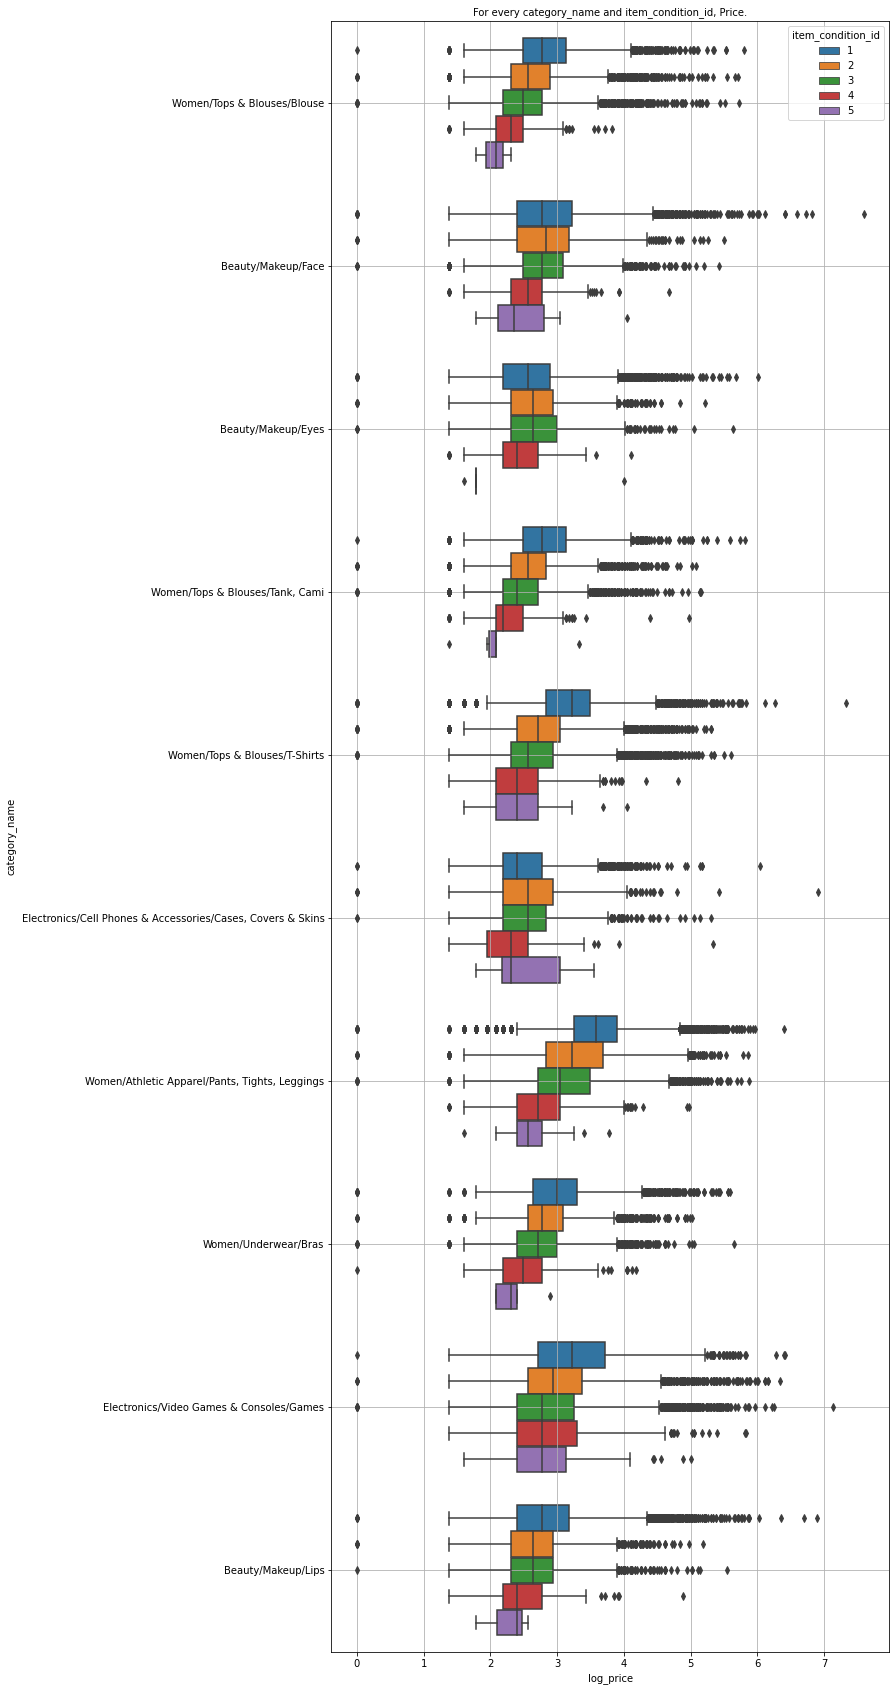

In [ ]:
plt.figure(figsize=(10,30))
plt.title('For every category_name and item_condition_id, Price.',fontsize=10)

df = train_df[(train_df['category_name'].isin(cat_count.index[:10]))]
sns.boxplot(x = "log_price", y = "category_name", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation: 

1. For every category of products, item_condition_id 1 products have high price, and item_condition_id 5 is lesser price.

### category_name, shipping, price

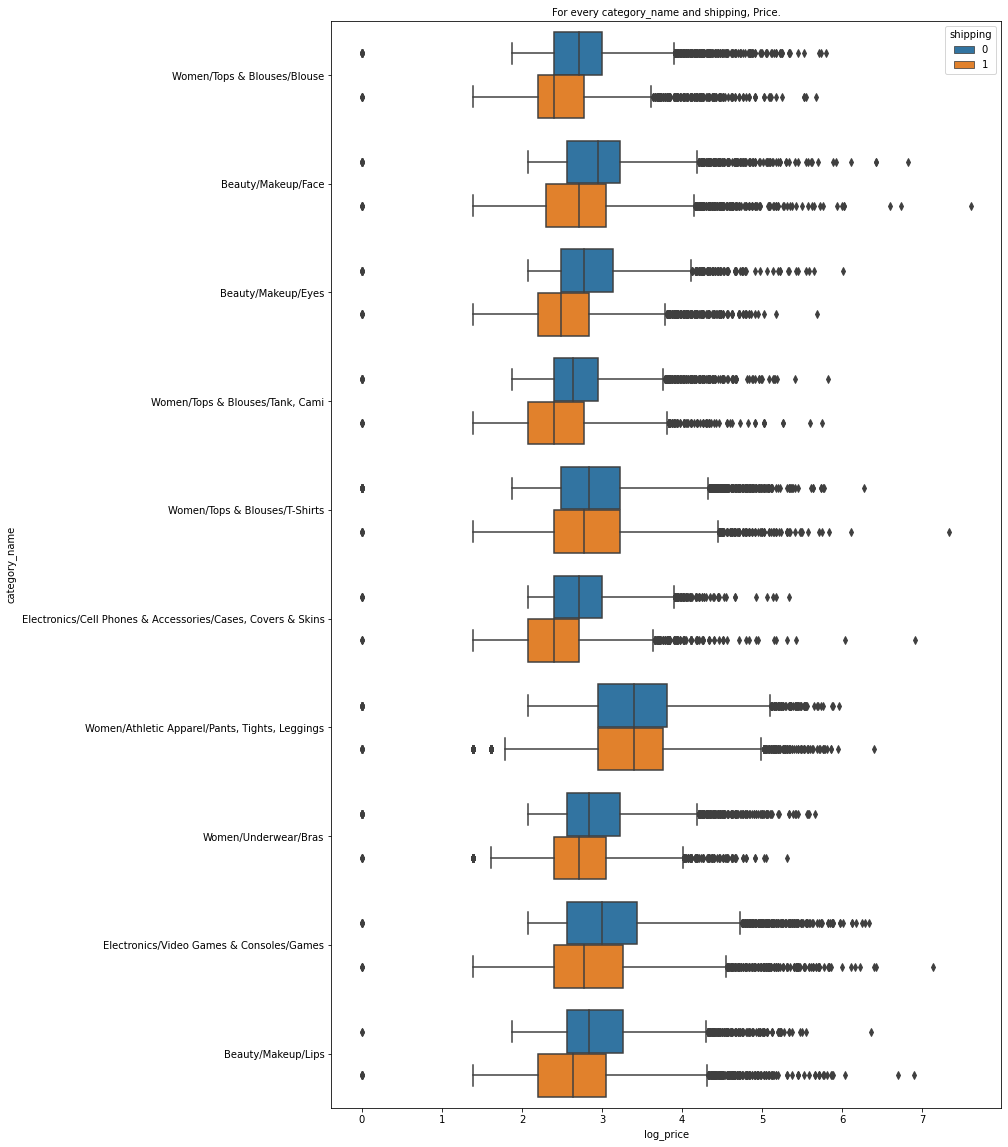

In [ ]:
plt.figure(figsize=(12,20))
plt.title('For every category_name and shipping, Price.',fontsize=10)

df = train_df[(train_df['category_name'].isin(cat_count.index[:10]))]
sns.boxplot(x = "log_price", y = "category_name", orient = "h", hue="shipping", data=df)

plt.show()

#### Observation:
1. For every category of products, customer pays the shipping charge.

# Cat_1 

### Cat 1 products count

In [ ]:
cat_1_count=train_df['cat_1'].value_counts()

print("Top Cat 1 Products are being sold on Mercari.")
cat_1_count

Top Cat 1 Products are being sold on Mercari.


Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Other                      51678
Vintage & Collectibles     46530
Handmade                   30842
Sports & Outdoors          25342
Name: cat_1, dtype: int64

In [ ]:
len(cat_1_count)

10

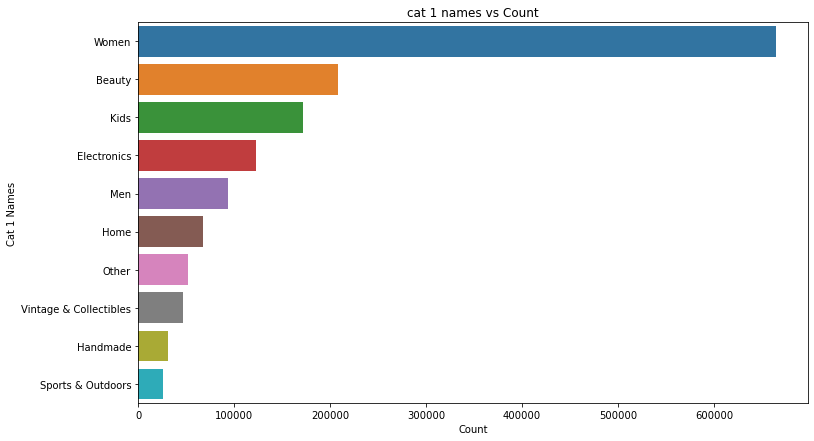

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(cat_1_count.values,cat_1_count.index)
plt.title('cat 1 names vs Count')
plt.xlabel('Count')
plt.ylabel('Cat 1 Names')
plt.show()

## Observation

1. Amoung all category products WOMEN, BEAUTY AND KIDS poducts are top 3 products that are sold on mercari.
2. Around 45% of women category products are being sold online.
3. Followed by BEAUTY AND KIDS which are way too behind WOMEN products, that are sold on MERCARI.


### Cat 1 products price mean

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat1_name__price_med = train_df.groupby(['cat_1'], as_index=True)['log_price'].median().sort_values(ascending=False)


cat1_name__price_med[:10] # top brands for which products are costly.


cat_1
Men                       3.091042
Women                     2.995732
Home                      2.944439
Vintage & Collectibles    2.833213
Sports & Outdoors         2.833213
Electronics               2.772589
Beauty                    2.772589
Other                     2.708050
Kids                      2.708050
Handmade                  2.564949
Name: log_price, dtype: float64

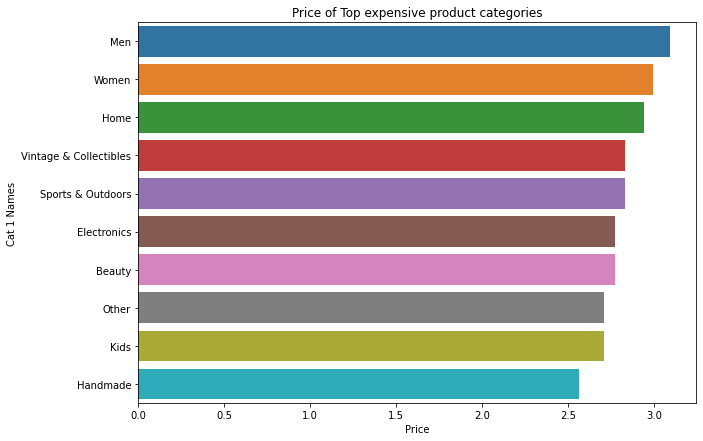

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=cat1_name__price_med.values, y=cat1_name__price_med.index,orient='h')
plt.title('Price of Top expensive product categories')
plt.xlabel('Price')
plt.ylabel('Cat 1 Names')
plt.show()

## Observation

1. Though Women, Beauty and Kids category_1 products are sold much, but their price is lower than Men category_1 Products.
2. KIDS and HANDMADE category products are least sold ones.

### Cat 1 products price variations

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat1_name__price_std = train_df.groupby(['cat_1'], as_index=True)['log_price'].std().sort_values(ascending=False)


cat1_name__price_std # top brands for which products are costly.

cat_1
Electronics               0.947777
Vintage & Collectibles    0.824358
Handmade                  0.785068
Men                       0.770533
Other                     0.734739
Women                     0.729357
Sports & Outdoors         0.719623
Home                      0.667484
Kids                      0.665548
Beauty                    0.633728
Name: log_price, dtype: float64

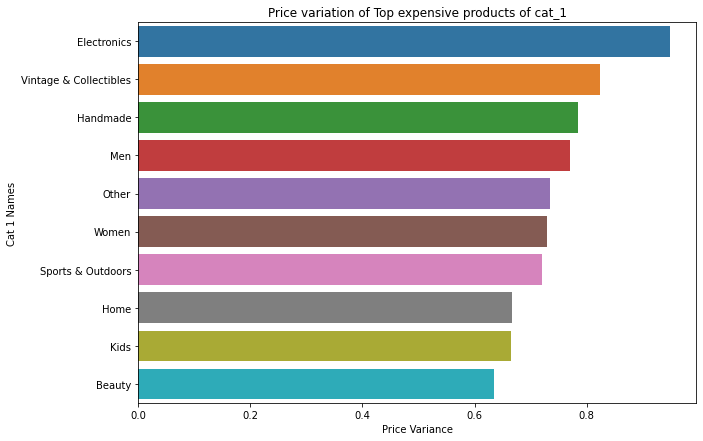

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=cat1_name__price_std.values[:10], y=cat1_name__price_std.index[:10],orient='h')
plt.title('Price variation of Top expensive products of cat_1')
plt.xlabel('Price Variance')
plt.ylabel('Cat 1 Names')
plt.show()

## Observation

1. Though ELECTRONICS category products are expensive but it has wide price range of products followed by VINTAGE & COLLECTIBLES AND Handmade PRODUCTS. 
2. Highest number of WOMEN category products are sold on mercari but their price range is narrow.
3. Beauty category products have lowest price-range.

###  Cat 1 products price range

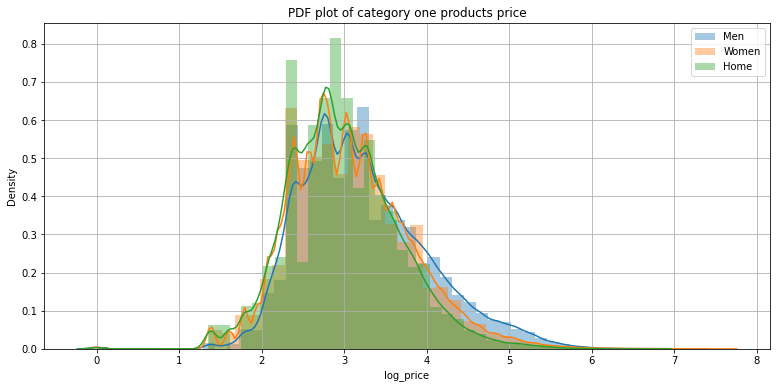

In [ ]:
plt.figure(figsize=(13,6))
plt.title('PDF plot of category one products price')

for cat_name in cat1_name__price_med.index[:3]:
    
    category_name_price  = train_df.loc[train_df['cat_1']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

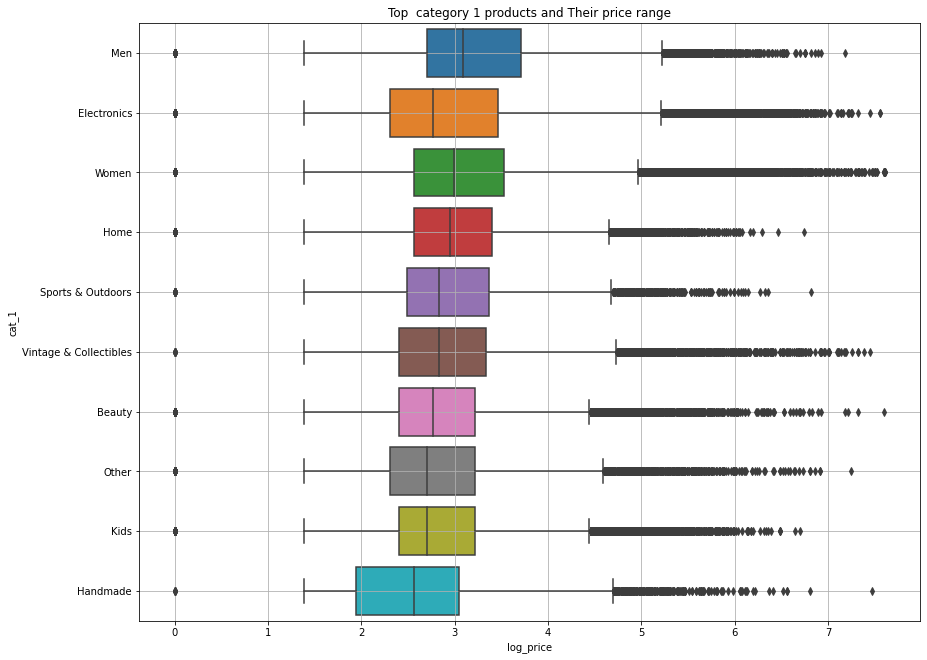

In [ ]:
plt.figure(figsize=(14,11))
plt.title('Top  category 1 products and Their price range')

sns.boxplot(x = train_df.log_price, y = train_df.cat_1, orient = "h")

plt.grid()
plt.show()

## Observation

1. Women, Beauty and Kids category products are highest number of products that are sold on mercari, but price is lower that men and electronics category products, while handmade and sports outdoor products have least number of products.
2. Electronics and Men category products are of highest price.
3. Electronics and Vintage & Collectibles category products has high price range, while beauty, kids products has lower price range.

### cat_1, brand_category, price

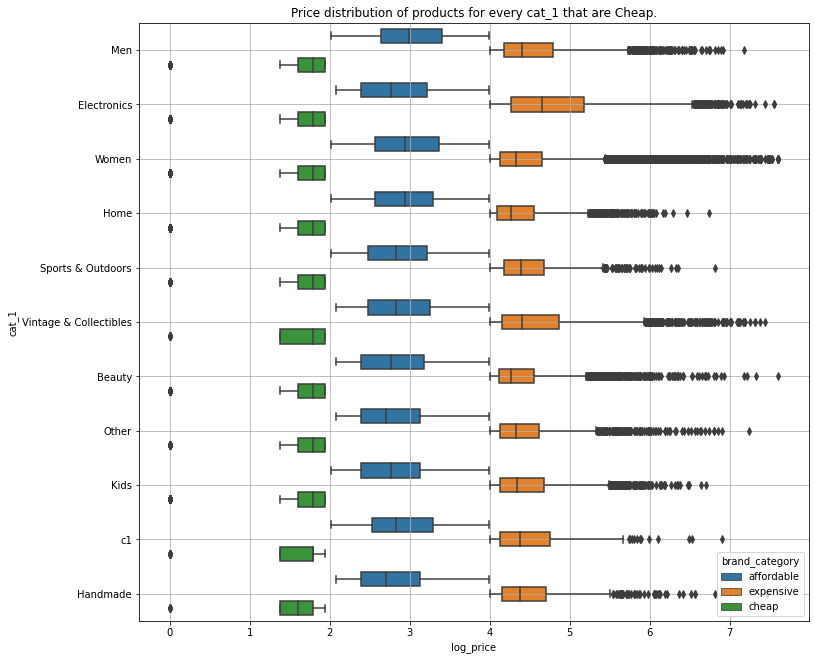

In [ ]:
plt.figure(figsize=(12,11))
plt.title('Price distribution of products for every cat_1 that are Cheap.')

sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="brand_category", data=train_df)

plt.grid()
plt.show()

#### Observation:

1. Electronics cat_1 products are most sold in expensive products categories.

### cat_1, item_condition_id, price

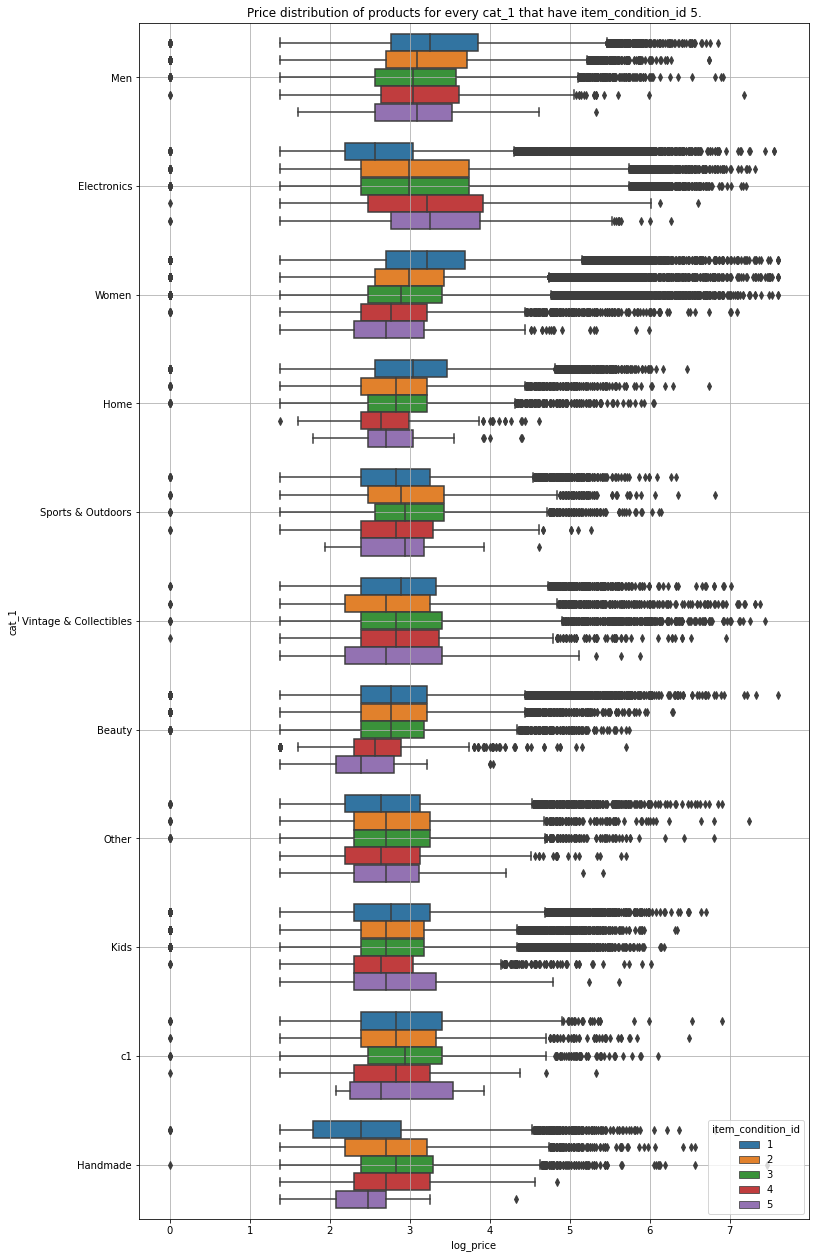

In [ ]:
plt.figure(figsize=(12,22))
plt.title('Price distribution of products for every cat_1 that have item_condition_id 5.')

sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="item_condition_id", data=train_df)

plt.grid()
plt.show()

#### Observation:

1. For cat_1 products item_condition_id 1 products are of high price.
2. item_condition_id 4 and 5 products are usually less price.

### cat_1, shipping, price

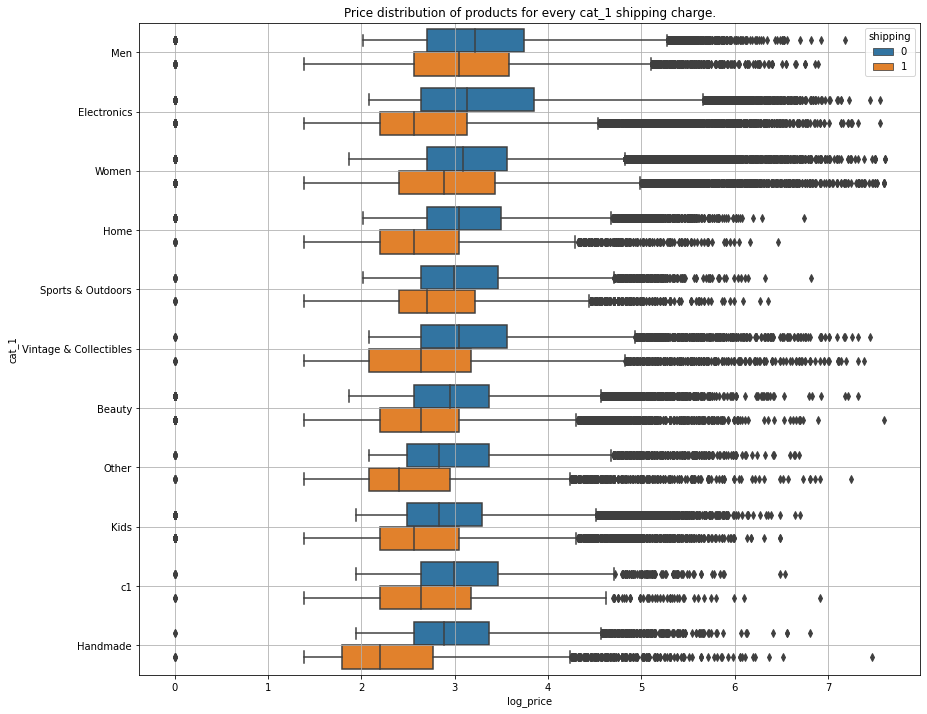

In [ ]:
plt.figure(figsize=(14,12))
plt.title('Price distribution of products for every cat_1 shipping charge.')

sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="shipping", data=train_df)

plt.grid()
plt.show()

#### Observation:

1. Usually shipping charge is paid by customer for every category.

### cat_1, item_condition_id, price, brand_category=expensive

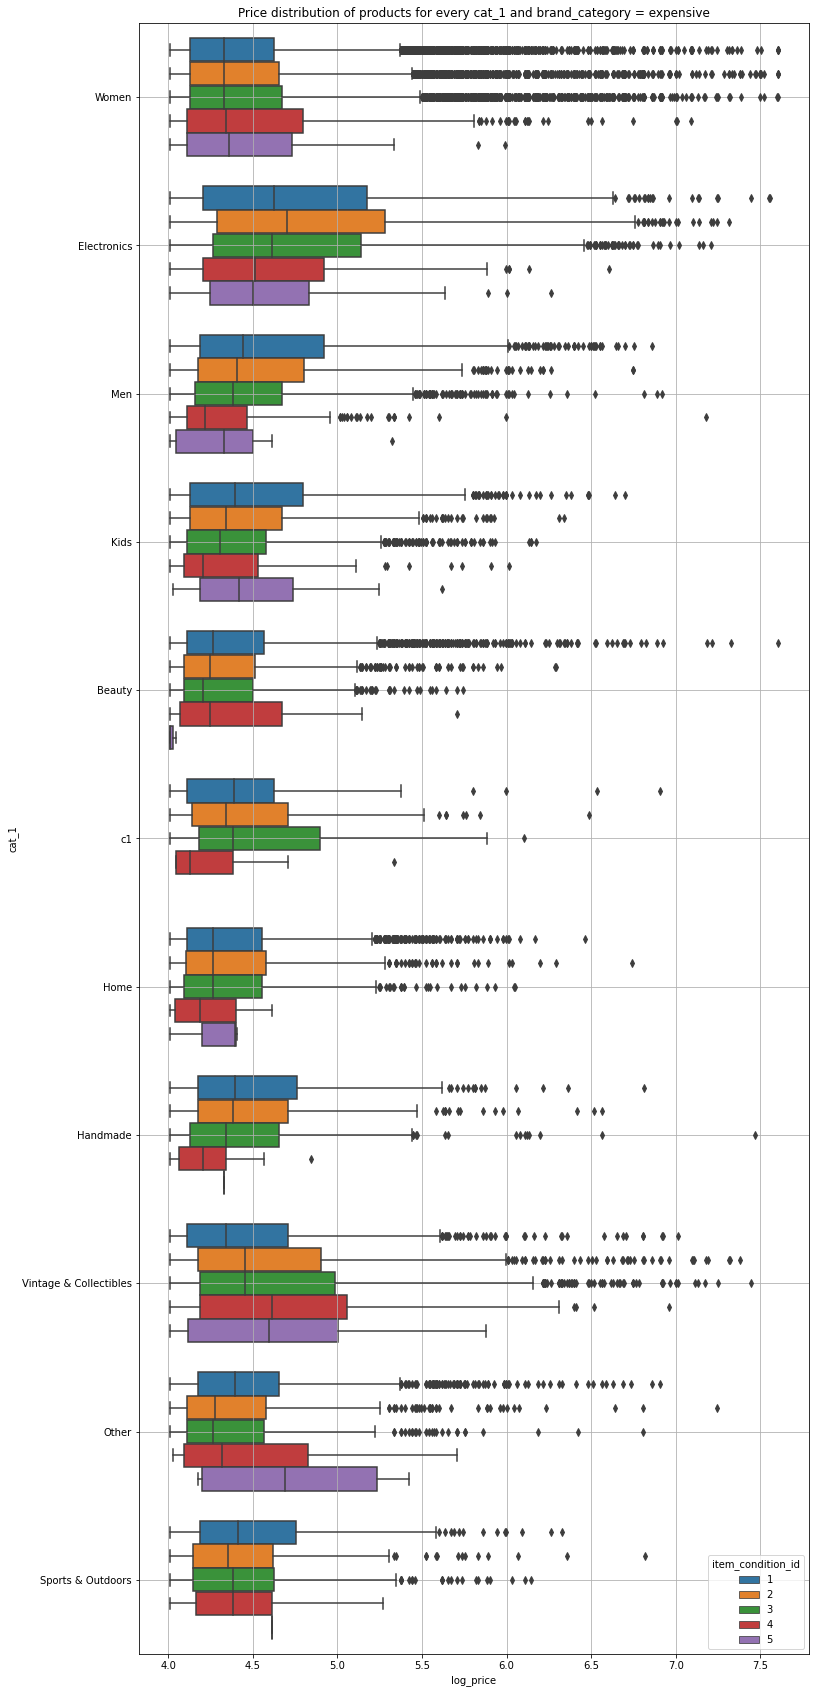

In [ ]:
plt.figure(figsize=(12,30))
plt.title('Price distribution of products for every cat_1 and brand_category = expensive')

df = train_df[train_df['brand_category']=='expensive']
sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually products have same price range for every item_condition_id.

### cat_1, item_condition_id, price, brand_category=affordable

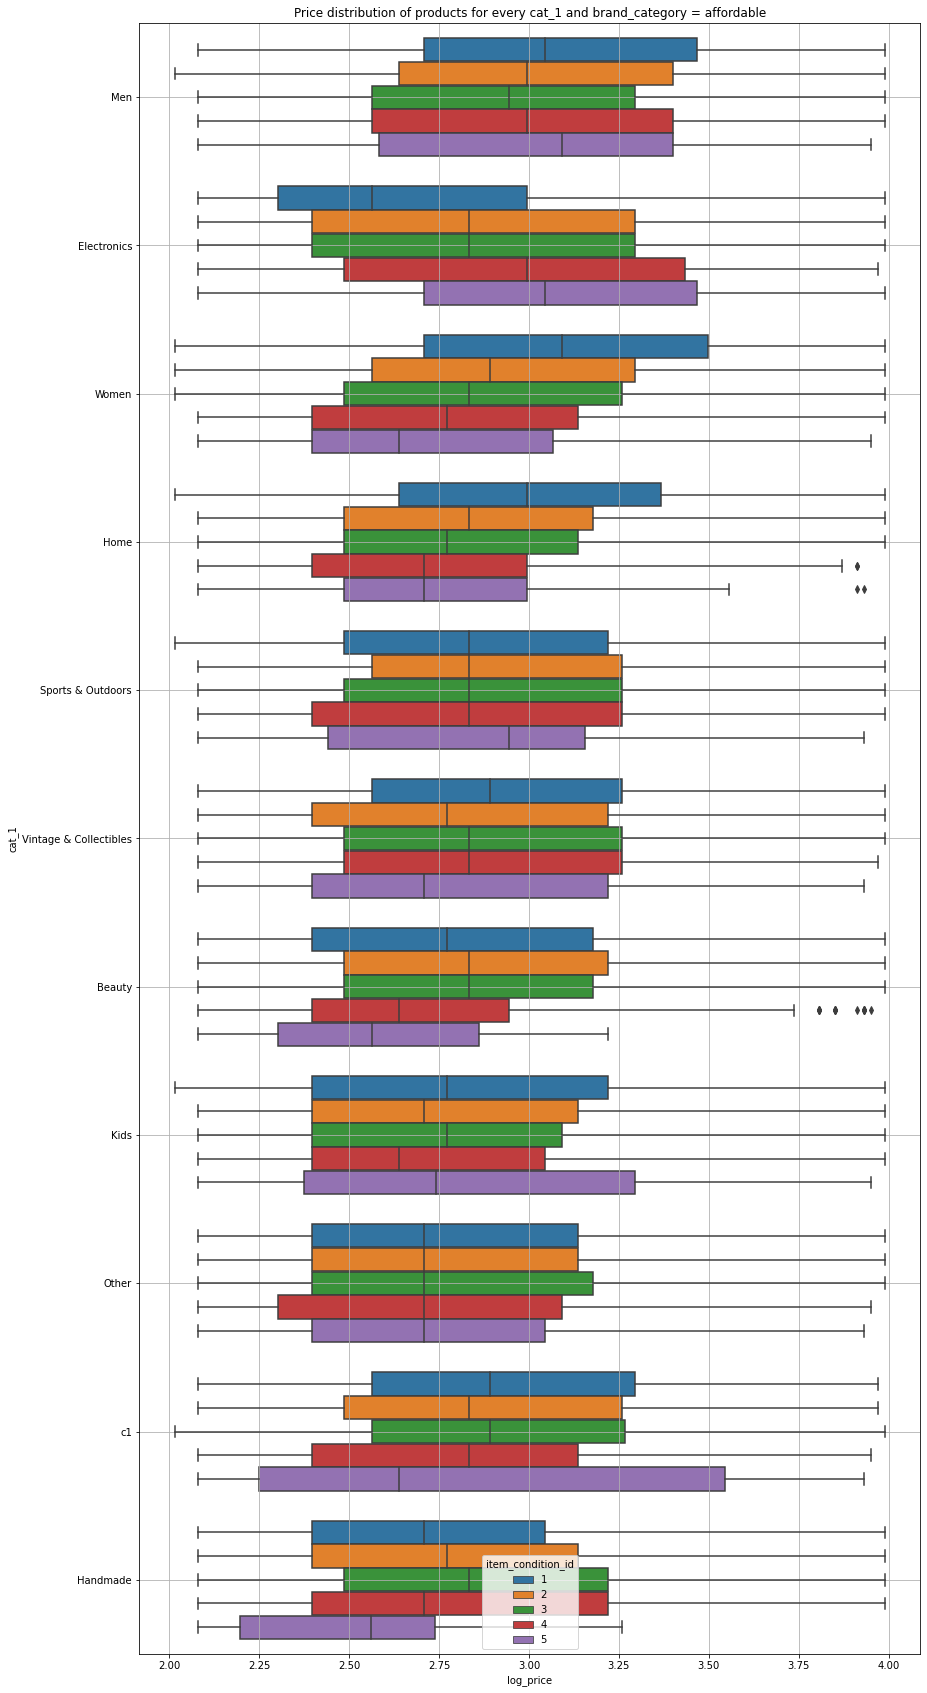

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_1 and brand_category = affordable')

df = train_df[train_df['brand_category']=='affordable']
sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually item_condition_id 5 products have lesser price, but for electronics category, price is high for affordable products.

### cat_1, item_condition_id, price, brand_category=cheap

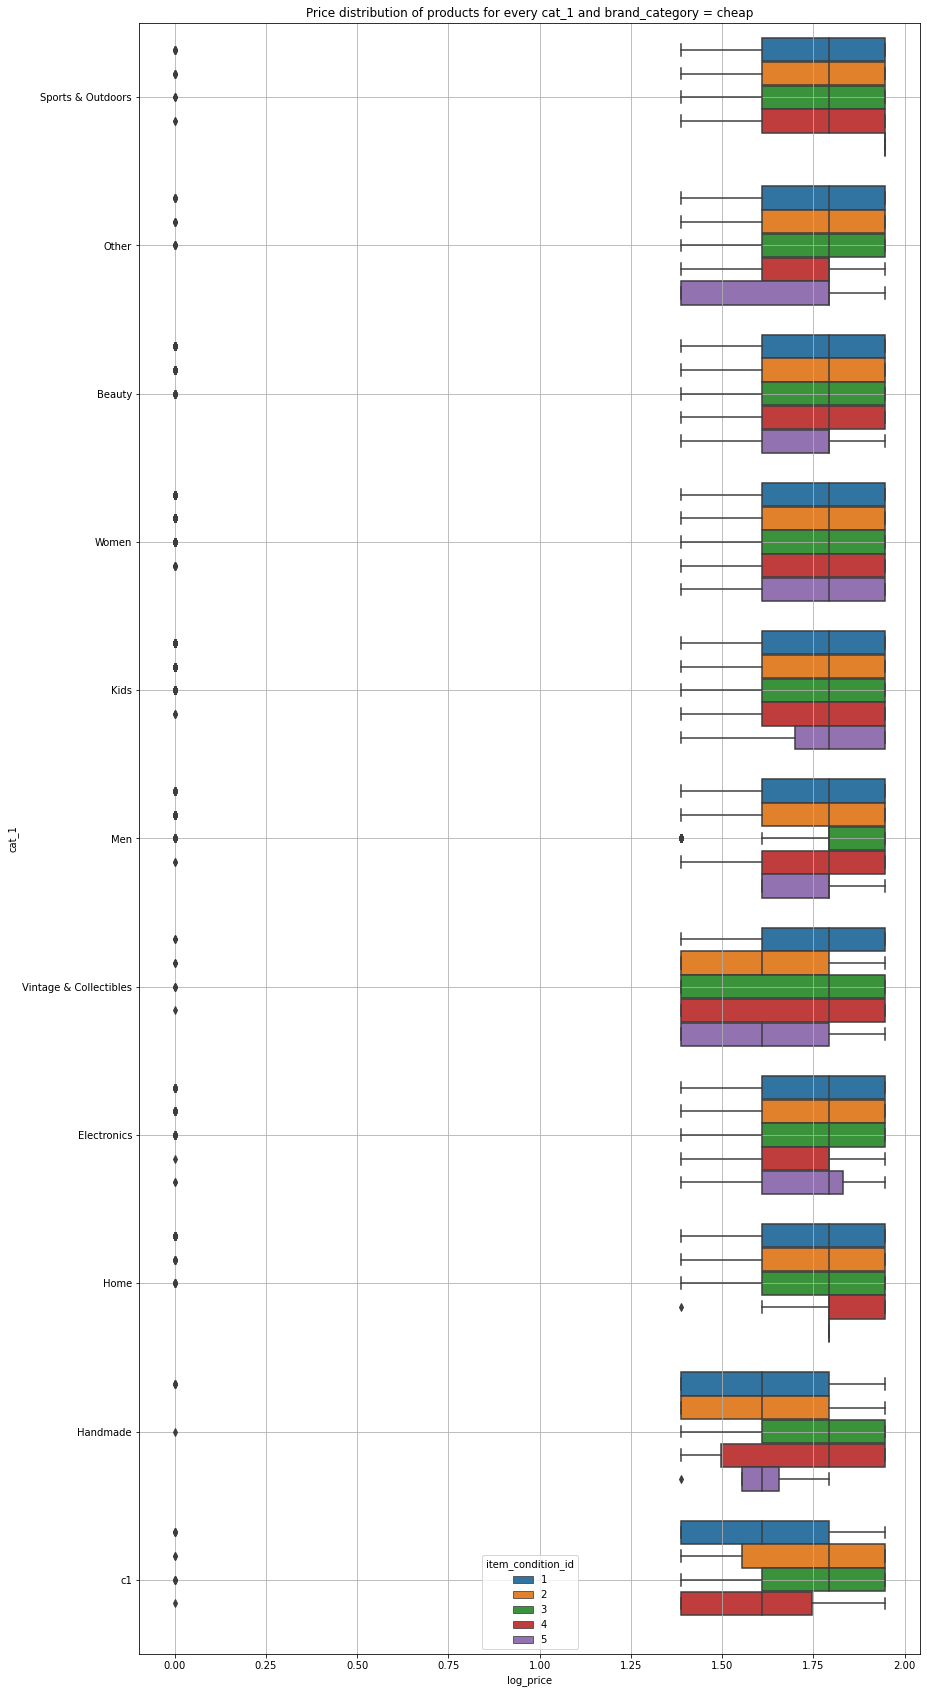

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_1 and brand_category = cheap')

df = train_df[train_df['brand_category']=='cheap']
sns.boxplot(x = "log_price", y = "cat_1", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually for cheap products, for all_item_condition_id price is nearly same.

# Cat 2

### Cat 2 products count

In [ ]:
cat_2_count=train_df['cat_2'].value_counts()

print("There are {} types of cat_2 products.".format(len(cat_2_count)))


There are 114 types of cat_2 products.


In [ ]:
print("Number of Cat 2 Products are being sold on Mercari in descending order.\n")
print(cat_2_count)

Number of Cat 2 Products are being sold on Mercari in descending order.

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_2, Length: 114, dtype: int64


In [ ]:
print("Top 10 type of cat_2 products are sold on mercari.")
cat_2_count[:10]

Top 10 type of cat_2 products are sold on mercari.


Athletic Apparel             134383
Makeup                       124624
Tops & Blouses               106960
Shoes                        100452
Jewelry                       61763
Toys                          58158
Cell Phones & Accessories     53290
Women's Handbags              45862
Dresses                       45758
Women's Accessories           42350
Name: cat_2, dtype: int64

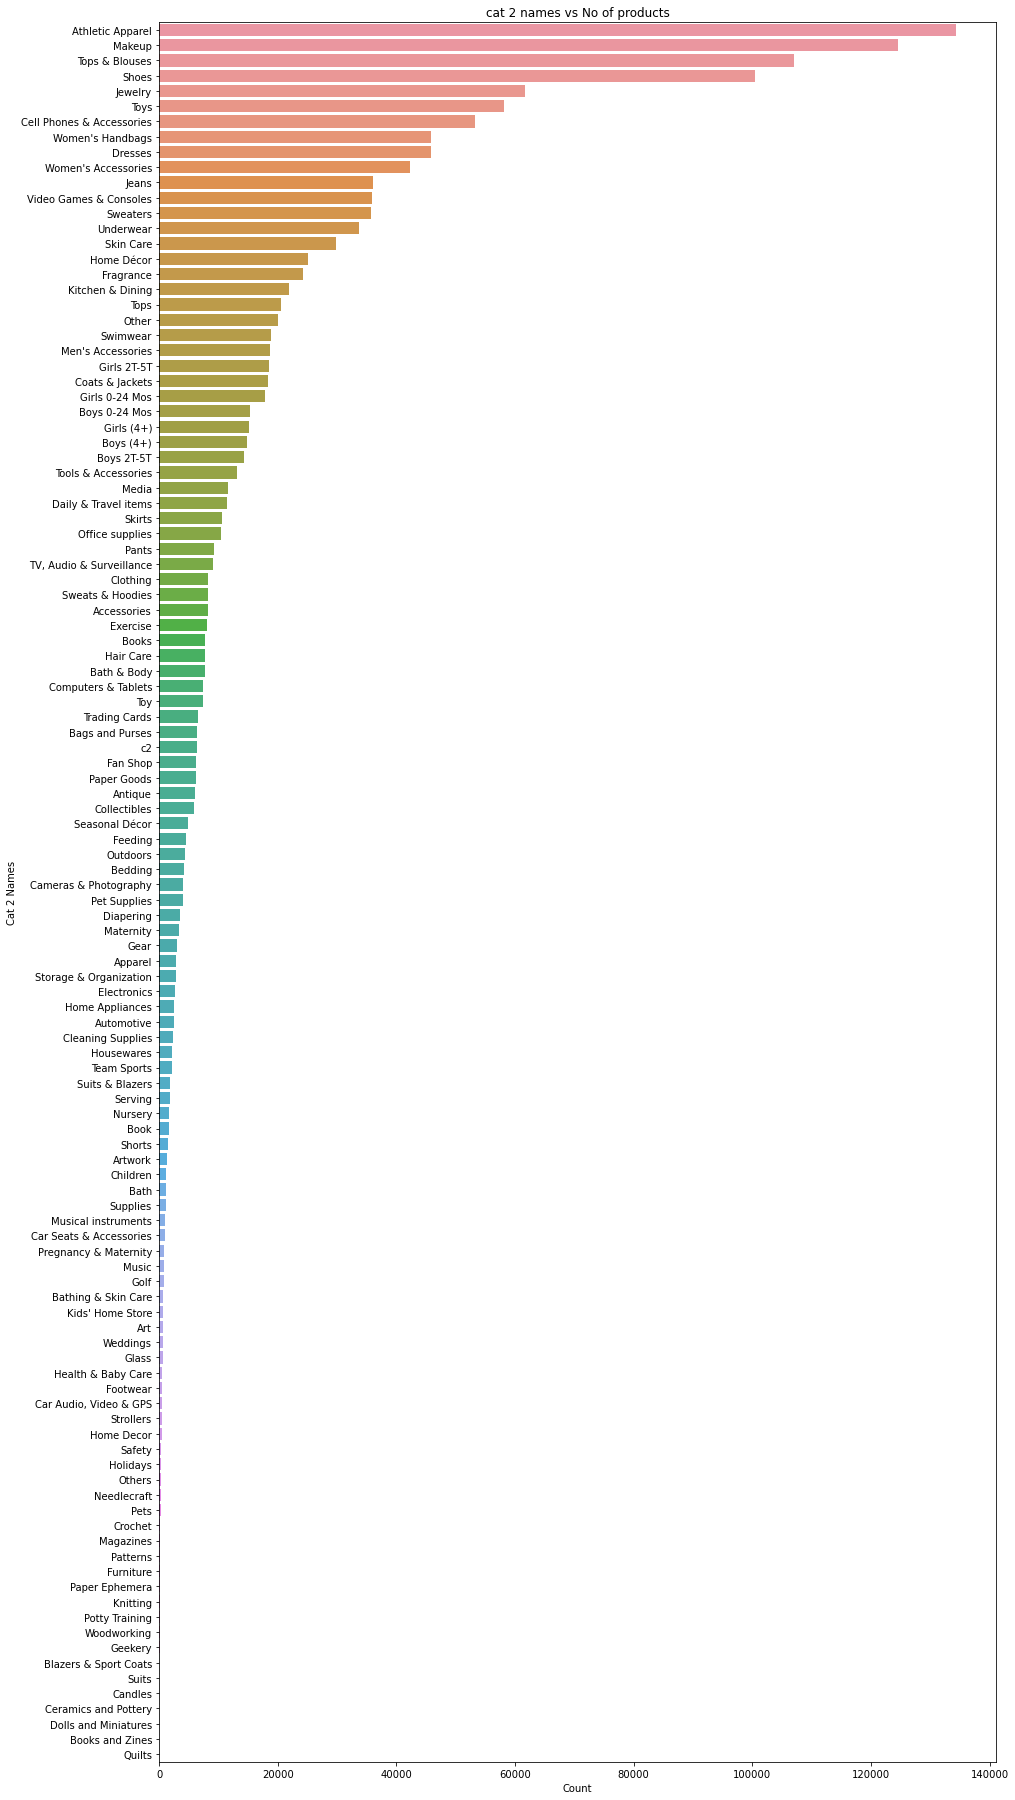

In [ ]:
plt.figure(figsize=(15,32)) # plot size
sns.barplot(cat_2_count.values, cat_2_count.index) # 
plt.title('cat 2 names vs No of products')
plt.xlabel('Count')
plt.ylabel('Cat 2 Names')
plt.show()

### Observation

1. There are 113 number of cat_2 products sold on mercari.
2. Among these ATHLETIC APPAREL, MAKEUP, TOPS & BLOUSE, SHOES, JWELERY, TOYS, CELL PHONES & ACCESSORIES are top sub category products sold and Quilts are least sold one subcategories.

### Cat 2 products price median

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat2_name__price_med = train_df.groupby(['cat_2'], as_index=True)['log_price'].median().sort_values(ascending=False)


cat2_name__price_med[:10] # top brands for which products are costly.


cat_2
Computers & Tablets         3.713572
Cameras & Photography       3.713572
Strollers                   3.610918
Women's Handbags            3.465736
Musical instruments         3.449862
Suits                       3.433987
Footwear                    3.433987
Shoes                       3.401197
Bags and Purses             3.367296
TV, Audio & Surveillance    3.295837
Name: log_price, dtype: float64

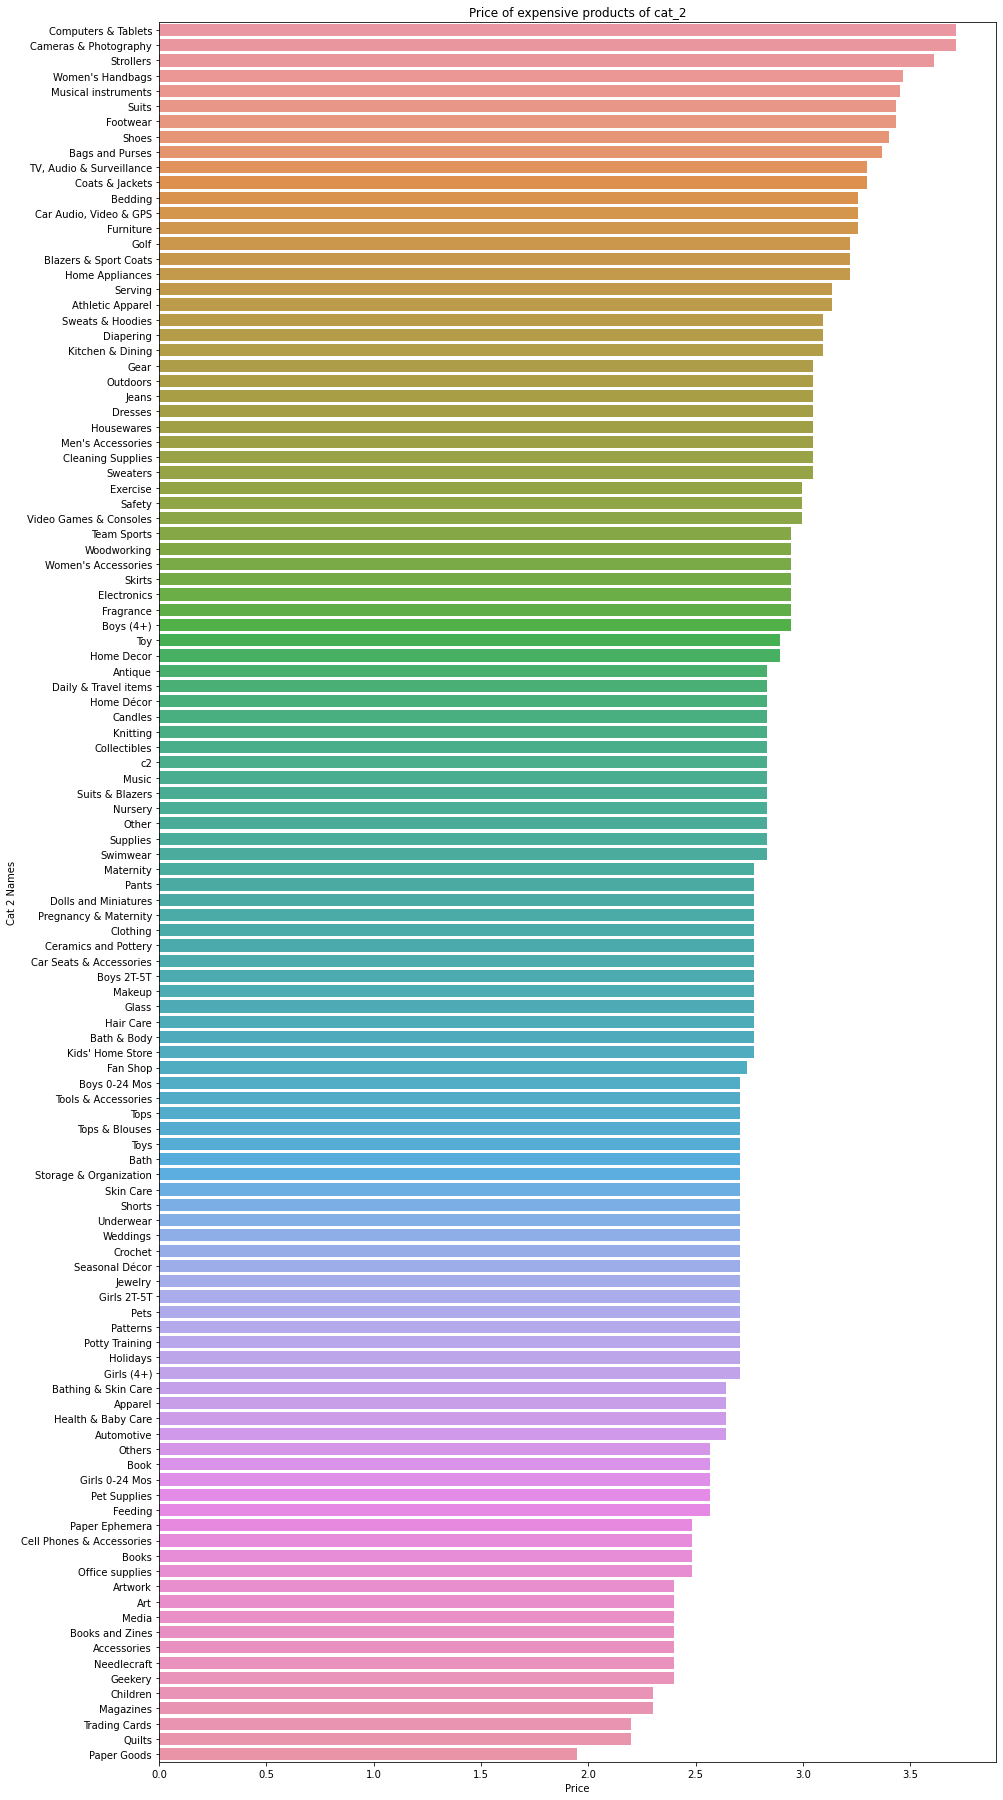

In [ ]:
plt.figure(figsize=(15,32))
sns.barplot(x=cat2_name__price_med.values, y=cat2_name__price_med.index,orient='h')
plt.title('Price of expensive products of cat_2')
plt.xlabel('Price')
plt.ylabel('Cat 2 Names')
plt.show()

### Top selling cat 2 products and their price range

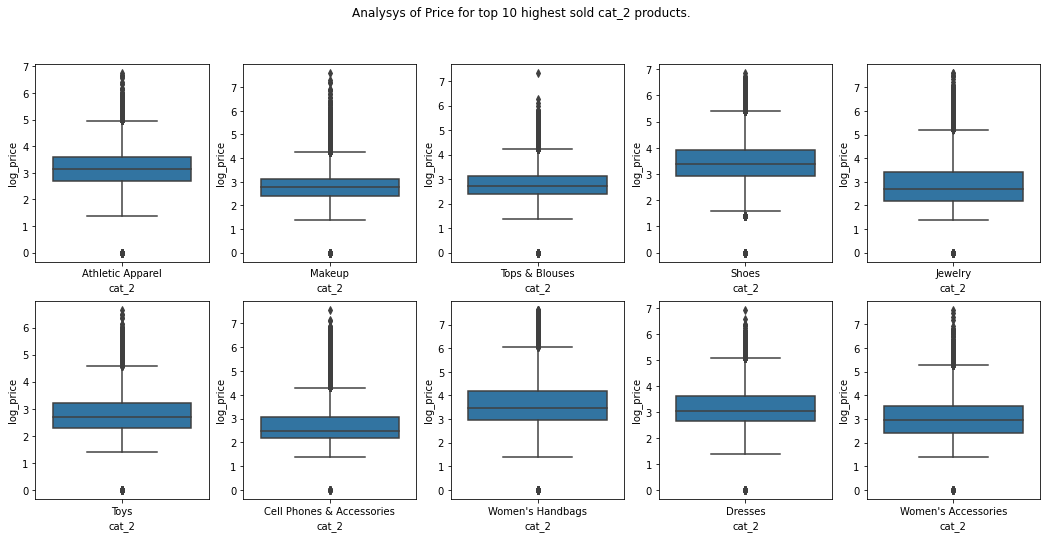

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('Analysys of Price for top 10 highest sold cat_2 products.') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(cat_2_count.index[:5]):
    
    df_i  = train_df.loc[train_df['cat_2'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_2", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(cat_2_count.index[5:10]):
    
    df_i  = train_df.loc[train_df['cat_2'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_2", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


### Observation

1. For top sold cat_2 products, the price range is same.

### Cat 2 products price variations

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat2_name__price_std = train_df.groupby(['cat_2'], as_index=True)['log_price'].std().sort_values(ascending=False)


cat2_name__price_std[:10] # top brands for which products are costly.

cat_2
Computers & Tablets          1.118665
Bags and Purses              0.989520
Cameras & Photography        0.989426
Strollers                    0.977617
Musical instruments          0.947371
Cell Phones & Accessories    0.932555
Women's Handbags             0.922969
Jewelry                      0.919773
TV, Audio & Surveillance     0.915185
Safety                       0.911585
Name: log_price, dtype: float64

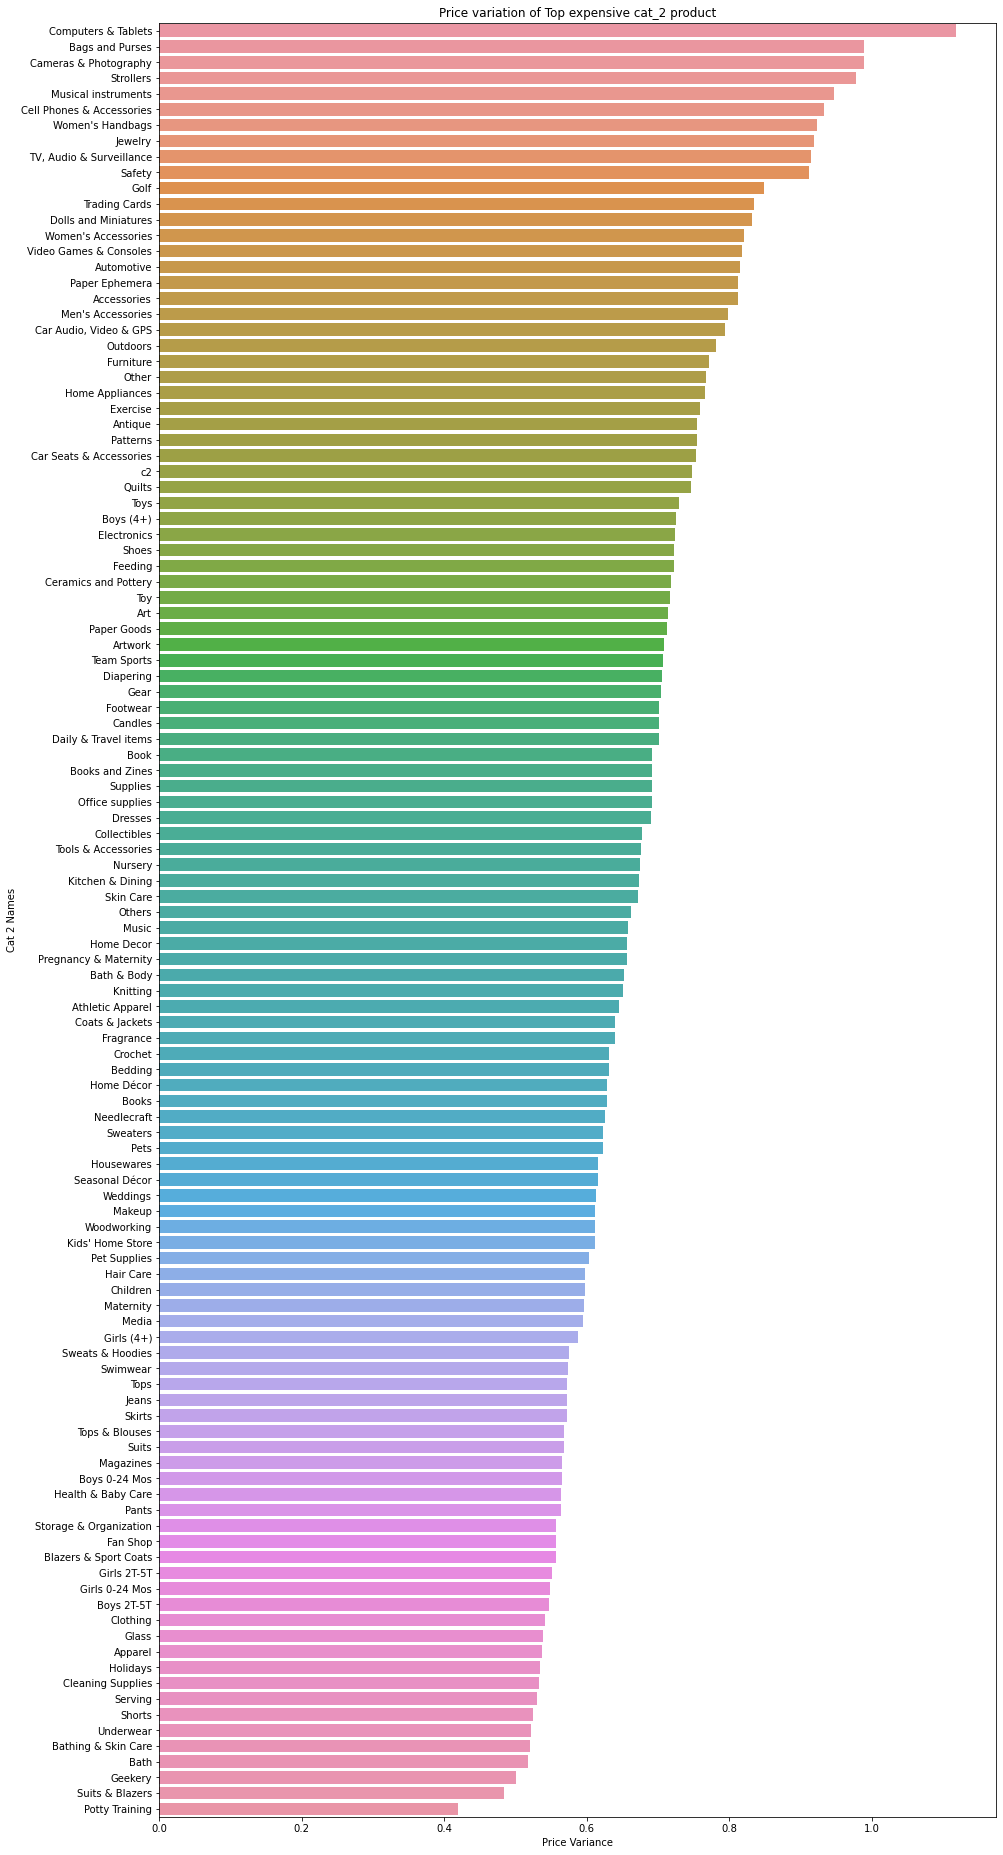

In [ ]:
plt.figure(figsize=(15,33))
sns.barplot(x=cat2_name__price_std.values, y=cat2_name__price_std.index,orient='h')
plt.title('Price variation of Top expensive cat_2 product')
plt.xlabel('Price Variance')
plt.ylabel('Cat 2 Names')
plt.show()

### Observation

1. Computer & Tablets is most expensive product sub categories and it has also huge price range, while Potty Training products have least variation of price. 
2. Computer & Tablets, Camera & Photography and Steller product subcategories are top expensive categories, while Paper goods products are least expensive ones


### Cat 2 products price range

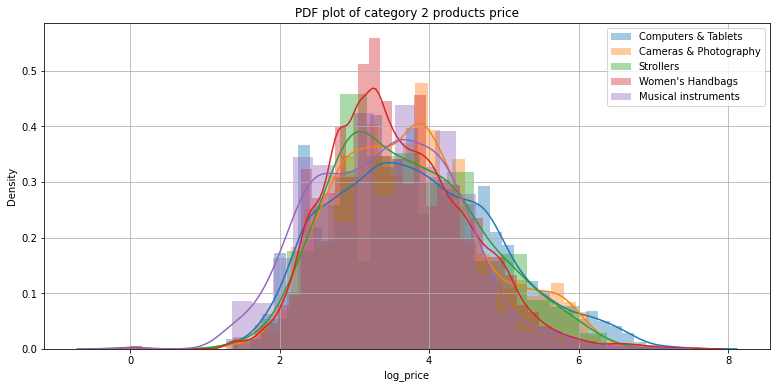

In [ ]:
plt.figure(figsize=(13,6))
plt.title('PDF plot of category 2 products price')

for cat_name in cat2_name__price_med.index[:5]:
    
    category_name_price  = train_df.loc[train_df['cat_2']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

### Observation
1. Computer and Tablets subcategory products have high price range among others.
2. In high range price, Footwear and Women's handbags subcategory products are sold most on mercari.


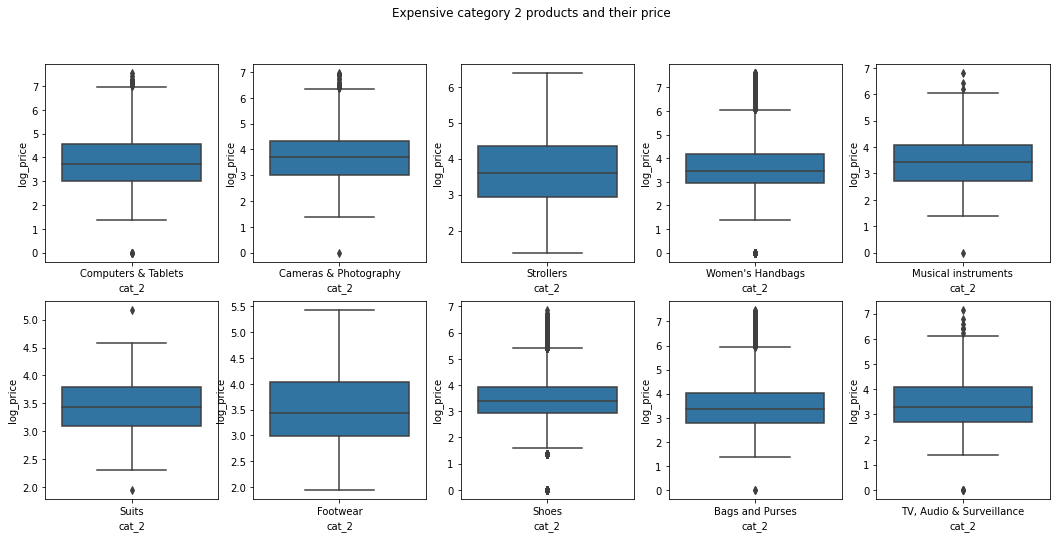

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('Expensive category 2 products and their price') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(cat2_name__price_med.index[:5]):
    
    df_i  = train_df.loc[train_df['cat_2'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_2", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(cat2_name__price_med.index[5:10]):
    
    df_i  = train_df.loc[train_df['cat_2'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_2", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


### Observation

1. ATHLETIC APPAREL, MAKEUP, TOPS & BLOUSE, SHOES, JWELERY subcategory products are highest number of products sold.

2. Computer & Tablets, Camera & Photography and Steller subcategory products are most expensive among others.

3. In high price range , Footwear and Women's handbags subcategory products are sold most among others.


### cat_2, item_condition, price 

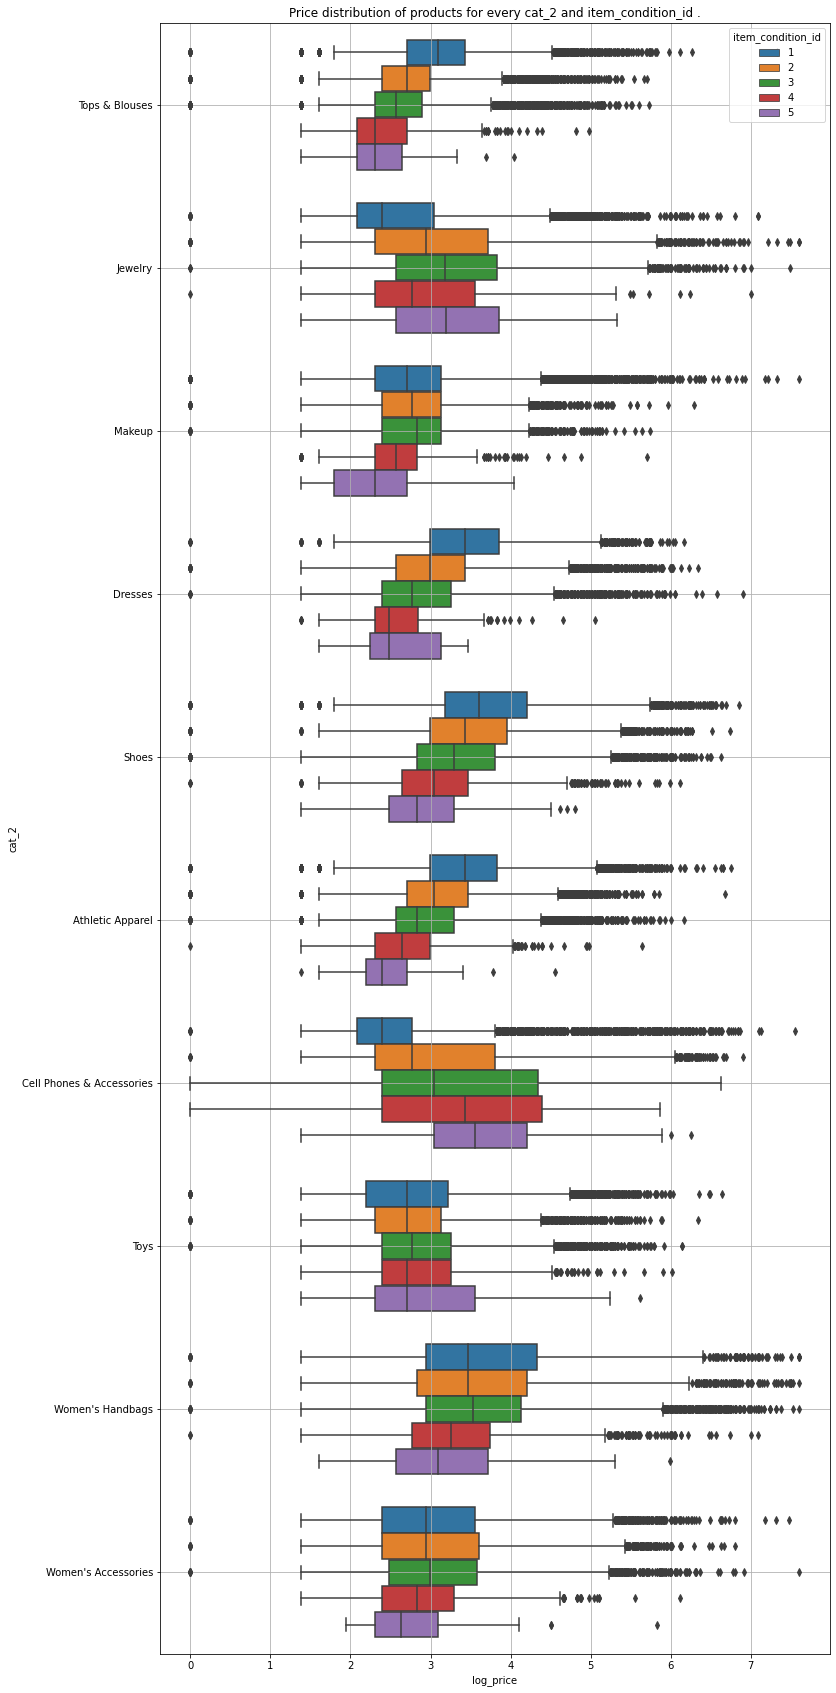

In [ ]:
plt.figure(figsize=(12,30))
plt.title('Price distribution of products for every cat_2 and item_condition_id .')


df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually item_condition_id 5 products are high price, but for jewelry and cell phones item_condition_id 5 products are high.

### cat_2, shipping, price

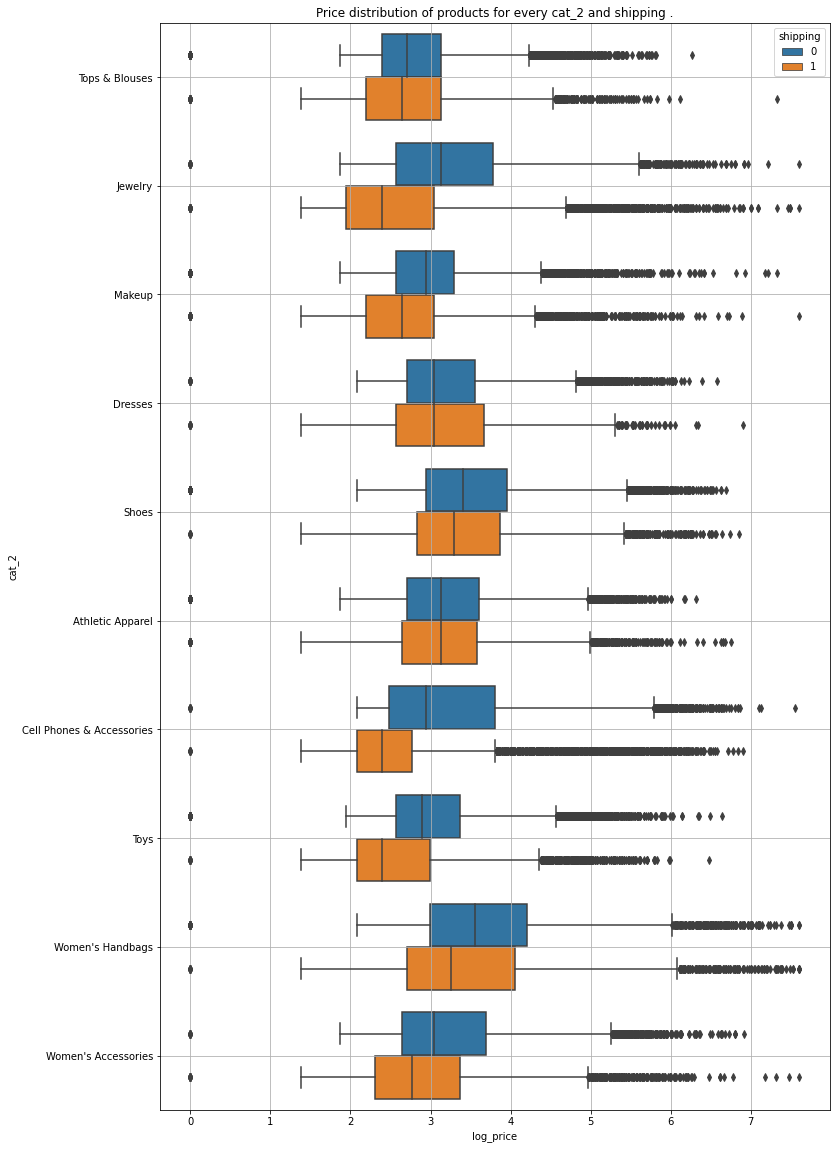

In [ ]:
plt.figure(figsize=(12,20))
plt.title('Price distribution of products for every cat_2 and shipping .')


df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation:

1. For almost all cat_2 products, customers pay shipping charge.

### cat_2, brand_category, price

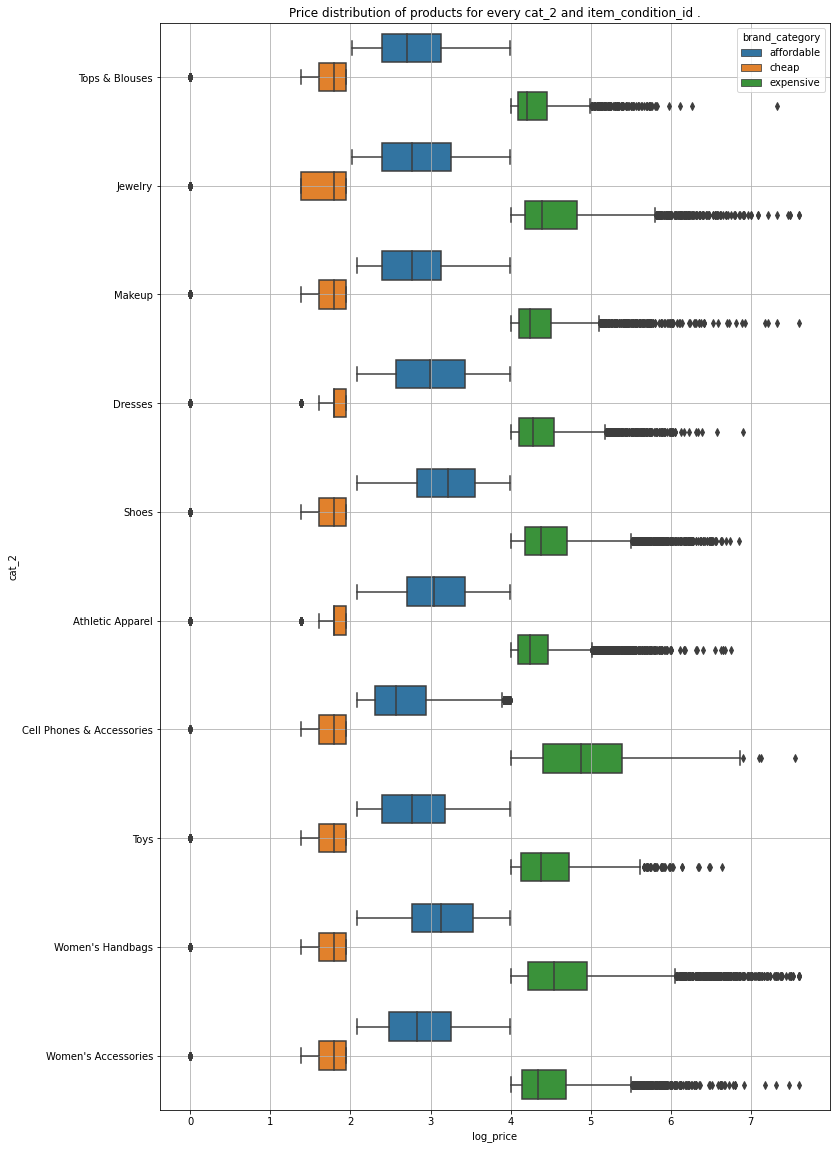

In [ ]:
plt.figure(figsize=(12,20))
plt.title('Price distribution of products for every cat_2 and brand category .')


df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="brand_category", data=df)

plt.grid()
plt.show()

#### Observation:

1. Cellphone has most products in Cat_2  expensive category.
2. Shoes has more products for affordable range.
3. Atheletic Apparel has least product count for cheap range.

### cat_2, item_condition_id, price, brand_category=expensive

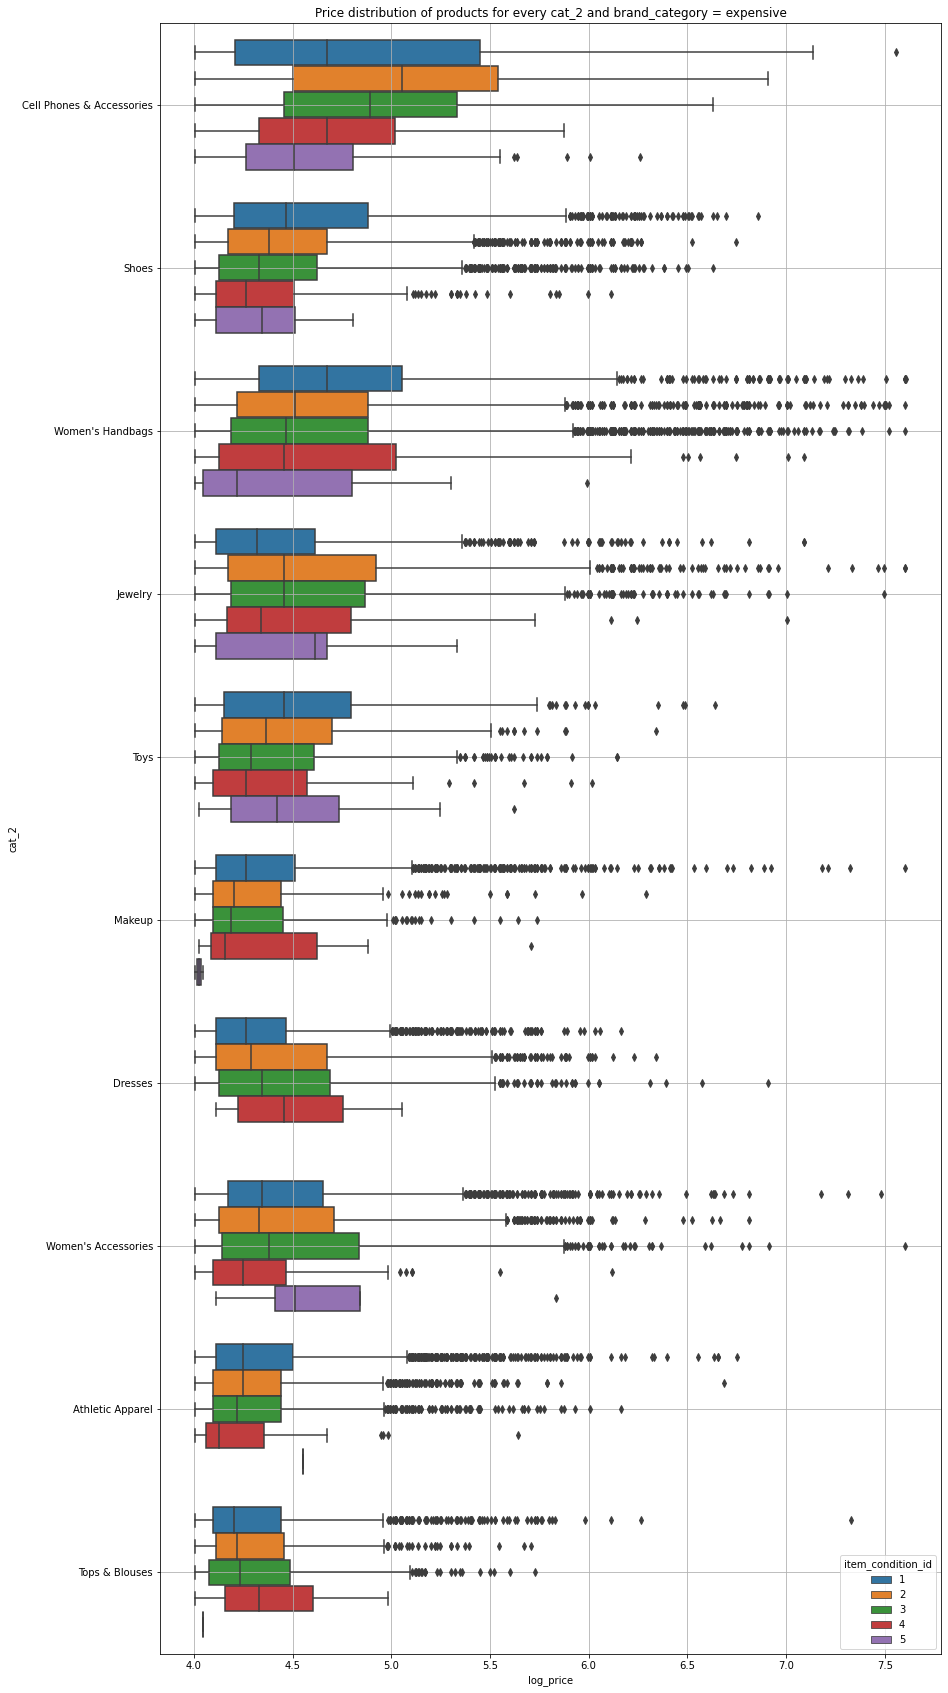

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_2 and brand_category = expensive')

df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))  & (train_df['brand_category']=='expensive')]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. For cellphones item_condition_id 1 products have more products in expensive category.

### cat_2, item_condition_id, price, brand_category=affordable

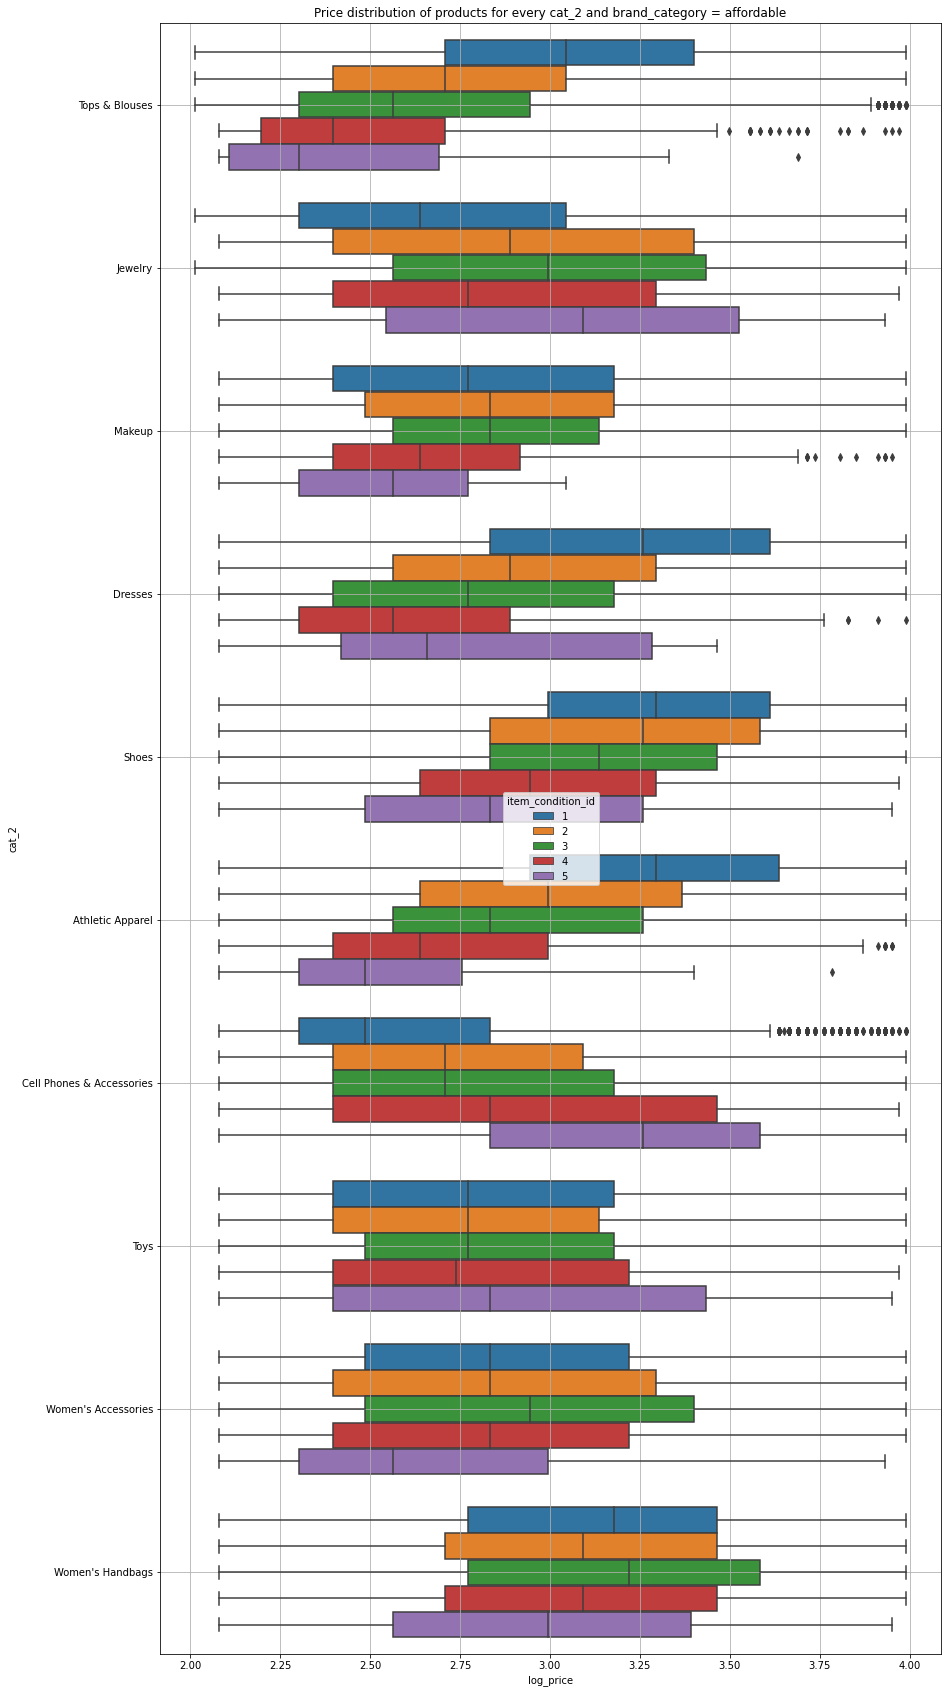

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_2 and brand_category = affordable')

df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))  & (train_df['brand_category']=='affordable')]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:
1. For shoes and Athletic Apparel item_condition_id 1, 2 products have more price. 

### cat_2, item_condition_id, price, brand_category=cheap

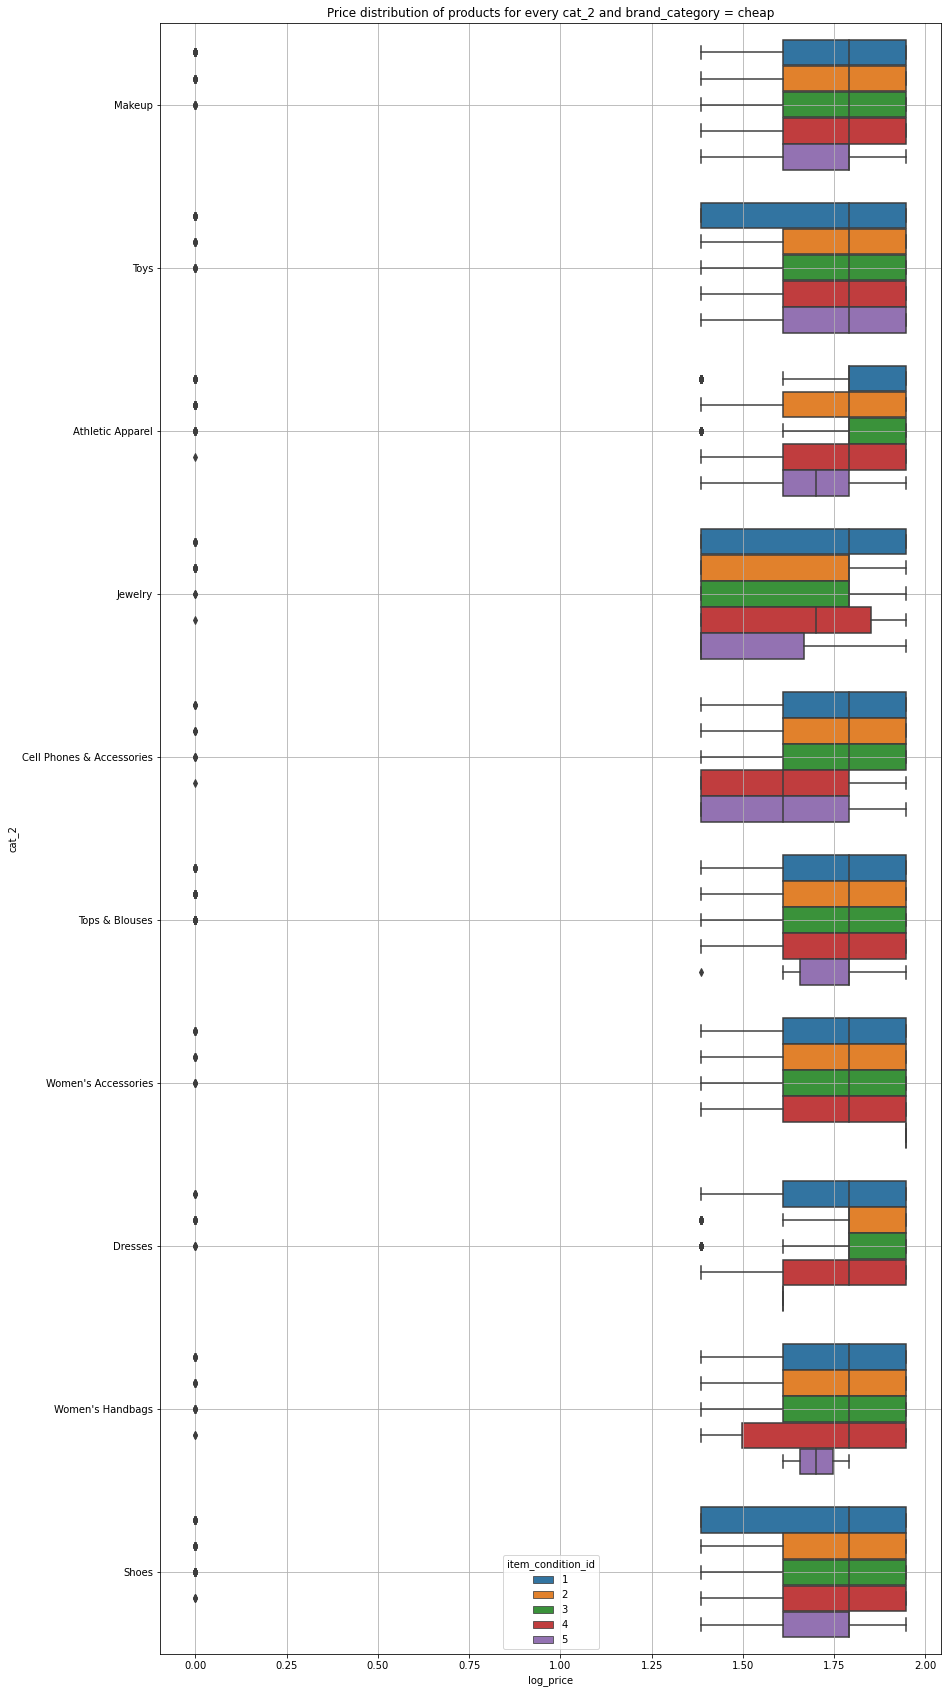

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_2 and brand_category = cheap')

df = train_df[(train_df['cat_2'].isin(cat_2_count.index[:10]))  & (train_df['brand_category']=='cheap')]
sns.boxplot(x = "log_price", y = "cat_2", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:
1. For every item_condition_id products, in cheap products range, price is same.

# Cat 3

### Cat 3 products count

In [ ]:
cat_3_count=train_df['cat_3'].value_counts()

print("Top Cat 3 Products are being sold on Mercari.")
cat_3_count

Top Cat 3 Products are being sold on Mercari.


Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Four Button                    1
Storage                        1
Cleaning                       1
Crib Netting                   1
Doll Clothes                   1
Name: cat_3, Length: 871, dtype: int64

### Top 10 most cat 3 products sold

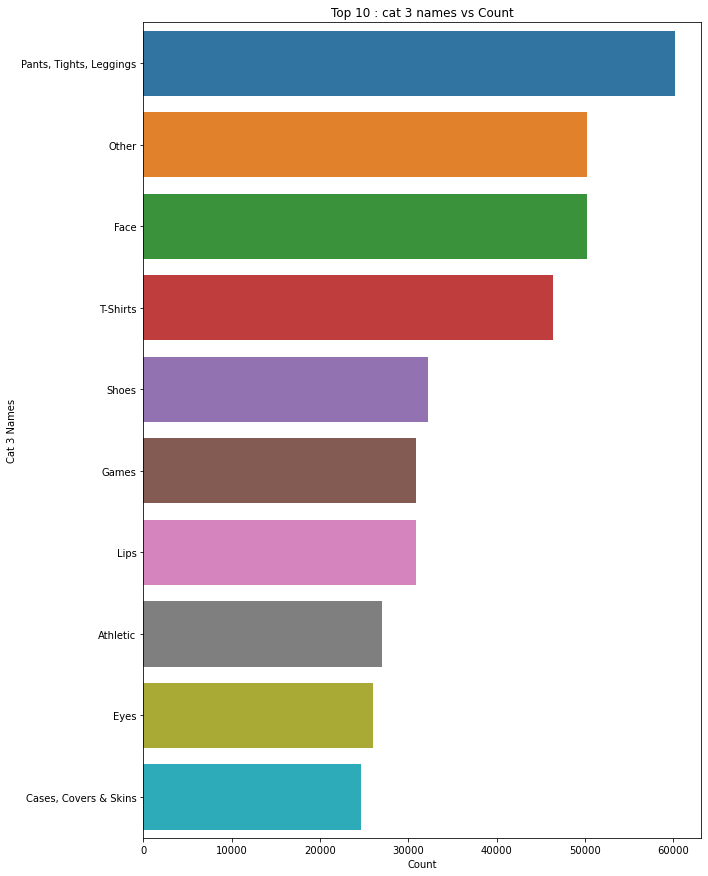

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(cat_3_count.values[:10],cat_3_count.index[:10])
plt.title('Top 10 : cat 3 names vs Count')
plt.xlabel('Count')
plt.ylabel('Cat 3 Names')
plt.show()

### Least 10 cat_3 products sold

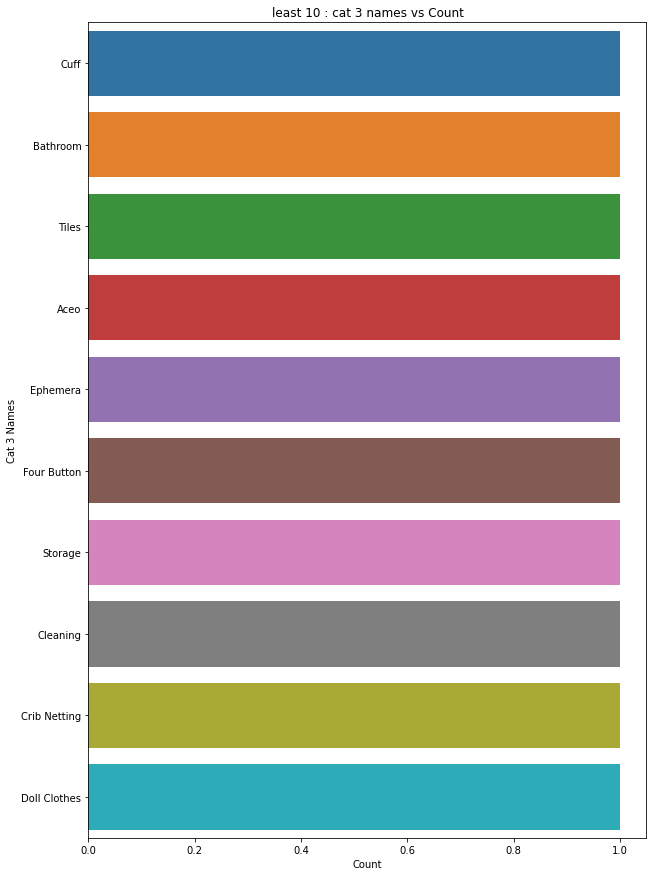

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(cat_3_count.values[-10:],cat_3_count.index[-10:])
plt.title('least 10 : cat 3 names vs Count')
plt.xlabel('Count')
plt.ylabel('Cat 3 Names')
plt.show()

### Observation

1. Pants & Tights & Leggings, Others, Face are the category 3 products sold on mercari most.
2. Fout Buttons, Doorstops and Dishwashers are the category 3 products sold on mercari the least.

### Cat 3 products price median

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat3_name__price_med = train_df.groupby(['cat_3'], as_index=True)['log_price'].median().sort_values(ascending=False)

cat3_name__price_med[:10] # top brands for which products are costly.


cat_3
Standard                  4.983607
Air Conditioners          4.882802
Lightweight               4.663439
Laptops & Netbooks        4.615121
Women's Golf Clubs        4.613894
Travel Systems            4.564348
Satchel                   4.510860
Desktops & All-In-Ones    4.505335
Oils & Fluids             4.454347
Lenses & Filters          4.262680
Name: log_price, dtype: float64

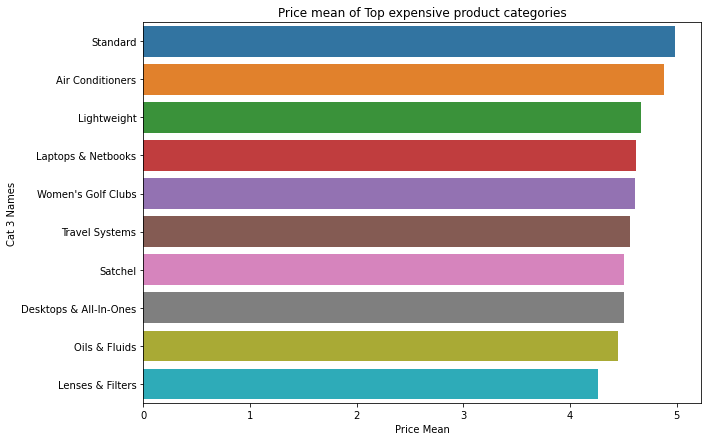

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=cat3_name__price_med.values[:10], y=cat3_name__price_med.index[:10],orient='h')
plt.title('Price mean of Top expensive product categories')
plt.xlabel('Price Mean')
plt.ylabel('Cat 3 Names')
plt.show()

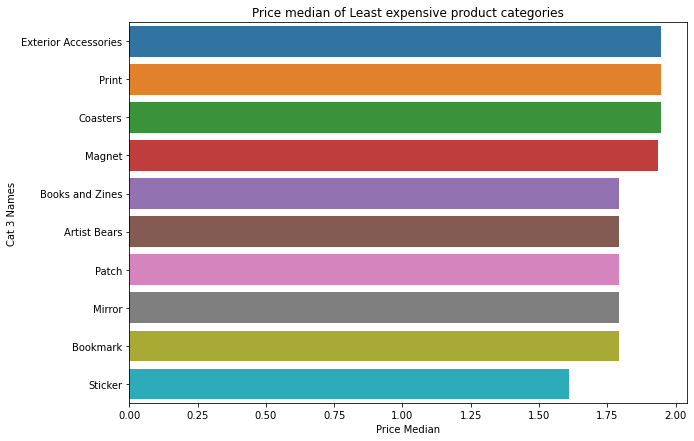

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=cat3_name__price_med.values[-10:], y=cat3_name__price_med.index[-10:],orient='h')
plt.title('Price median of Least expensive product categories')
plt.xlabel('Price Median')
plt.ylabel('Cat 3 Names')
plt.show()

### Observaton

1. Standard, Aircondiotion and Lightweights are the most expensive product category 3.
2. Sticker, Patch and Books & Zines are the least expensive product category 2.

### Cat 3 products price variations

In [ ]:

# grouping by category names and finding mean for each category name in descending order
cat3_name__price_std = train_df.groupby(['cat_3'], as_index=True)['log_price'].std().sort_values(ascending=False)


cat3_name__price_std # top brands for which products are costly.

cat_3
Felted                1.580420
Tag                   1.381590
Band & Orchestra      1.367629
Skateboard            1.272638
Women's Golf Clubs    1.266633
                        ...   
Storage Solutions          NaN
Tiles                      NaN
Towel                      NaN
Videogame                  NaN
Zipper                     NaN
Name: log_price, Length: 871, dtype: float64

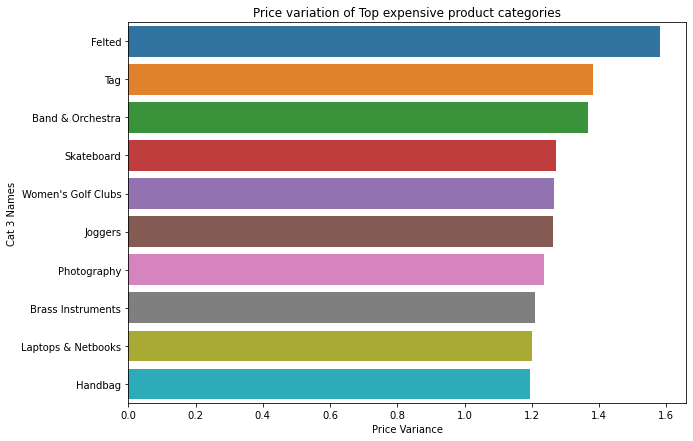

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=cat3_name__price_std.values[:10], y=cat3_name__price_std.index[:10],orient='h')
plt.title('Price variation of Top expensive product categories')
plt.xlabel('Price Variance')
plt.ylabel('Cat 3 Names')
plt.show()

### Observation

1. Wide price range products are sold for Felted, Tag and Band & Orchestra category 3 products.

### Cat 3 expensive category products price range.

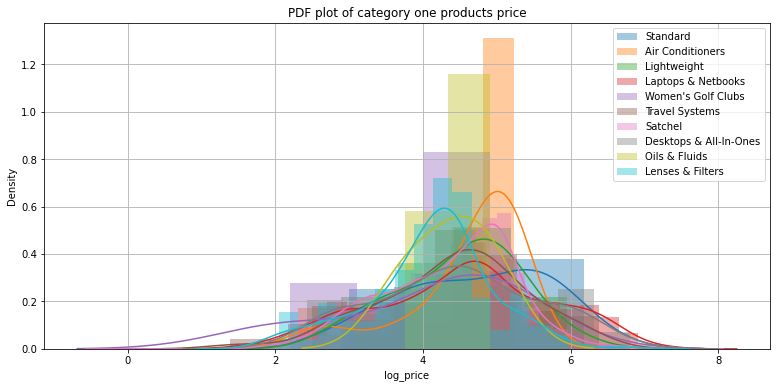

In [ ]:
plt.figure(figsize=(13,6))
plt.title('PDF plot of category one products price')

for cat_name in cat3_name__price_med.index[:10]:
    
    category_name_price  = train_df.loc[train_df['cat_3']==cat_name,'log_price']
    sns.distplot(category_name_price, label=cat_name)
    
plt.xlabel("log_price")
plt.grid()
plt.legend()
plt.show()

### Observation

1. Among top expensive products Aircondition and Standard category 3 products are sold more than others.

### Top 10 highest selling cat_3 products and their price

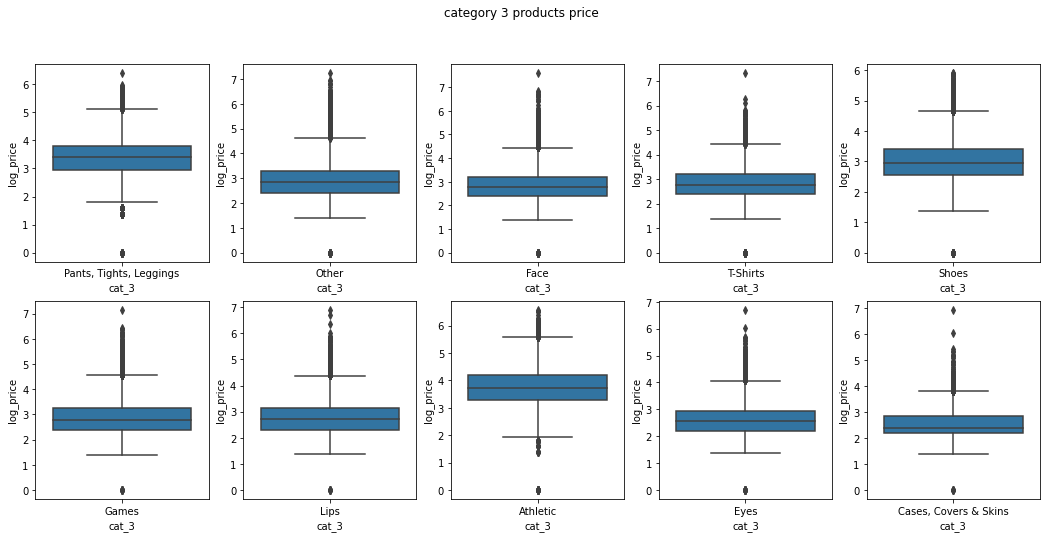

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('category 3 products price') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(cat_3_count.index[:5]):
    
    df_i  = train_df.loc[train_df['cat_3'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_3", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(cat_3_count.index[5:10]):
    
    df_i  = train_df.loc[train_df['cat_3'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_3", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


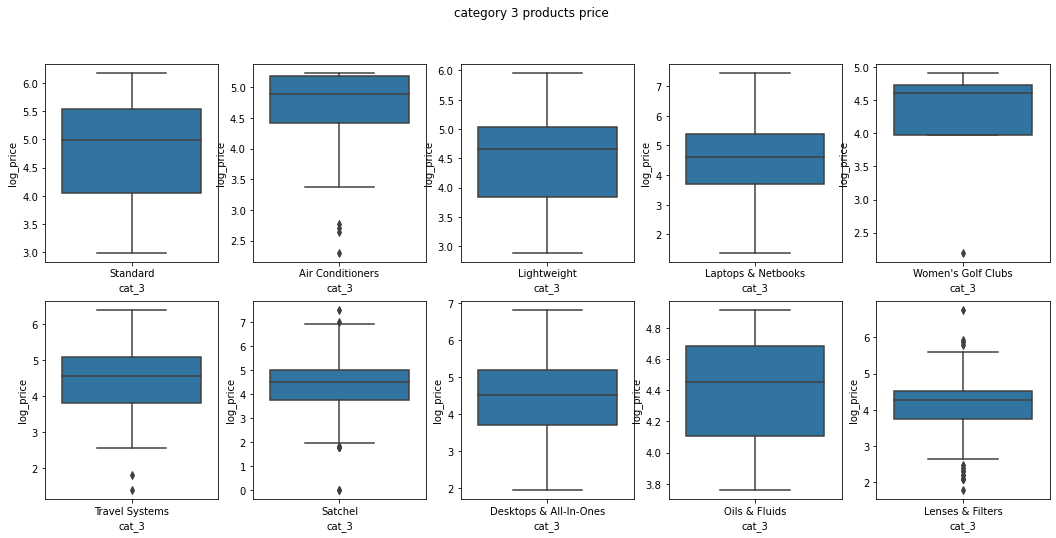

In [ ]:
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot


fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18,8)) # plot of 5 subplots
fig.suptitle('category 3 products price') # title of the plot

# top 10 cat_2 names where price mean is high in descending order
for index, cat_name in enumerate(cat3_name__price_med.index[:5]):
    
    df_i  = train_df.loc[train_df['cat_3'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_3", y="log_price", data=df_i, ax=axs[0, index]) # boxplot of cat_2 and price
    


for index, cat_name in enumerate(cat3_name__price_med.index[5:10]):
    
    df_i  = train_df.loc[train_df['cat_3'] == cat_name] # dataframe of cat_2 name only
    
    sns.boxplot(x="cat_3", y="log_price", data=df_i, ax=axs[1, index]) # boxplot of cat_2 and price
   


# Observations

1. Among top 10 expensive products, Laptios and Notebooks category 3 products have very wide range of price,
2. Amongs top 10 expensive products, Women's Golf clubs, Air conditioners category 3 products have very narrow range of products.
3. Most of the products of Air conditioner has very high price .
4. Top selling cat_3 products have very lesser price than expensive products.

### cat_3, item_condition_id, price 

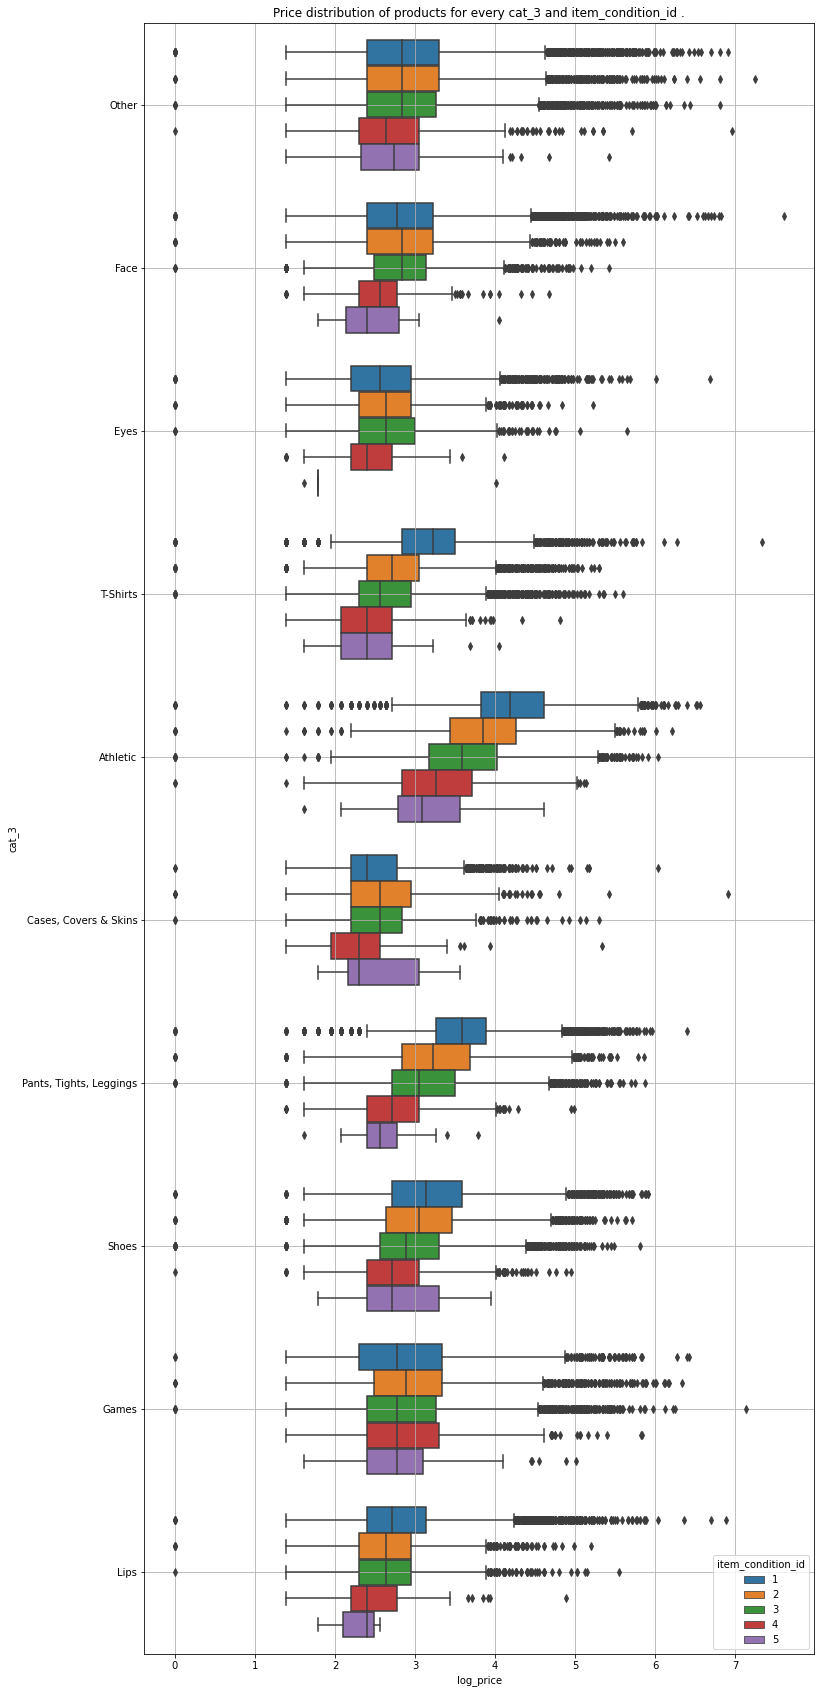

In [ ]:
plt.figure(figsize=(12,30))
plt.title('Price distribution of products for every cat_3 and item_condition_id .')


df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation: 

1. Usually item_condition_id 1 products have more price, and 5 is least ones.

### cat_3, shipping, price 

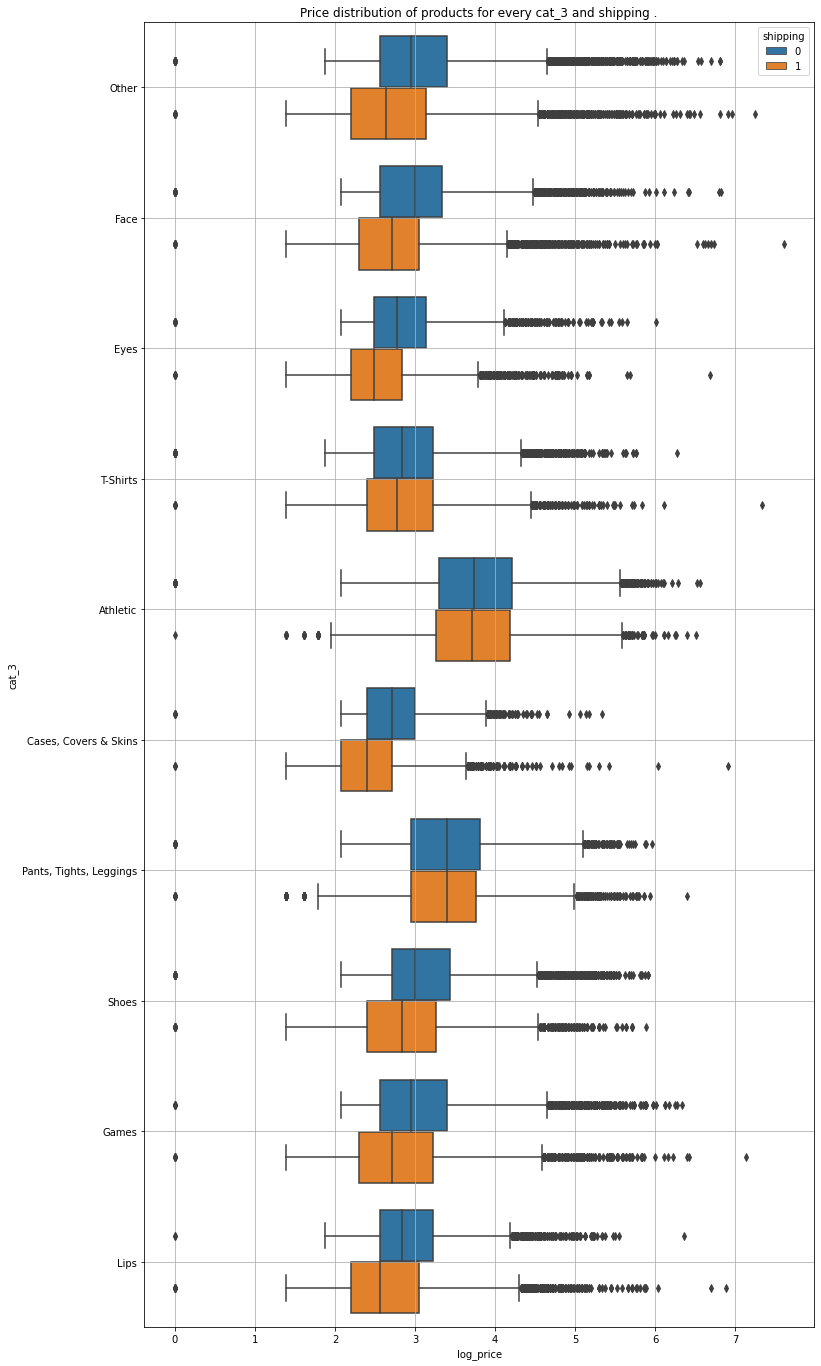

In [ ]:
plt.figure(figsize=(12,24))
plt.title('Price distribution of products for every cat_3 and shipping .')


df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="shipping", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually customers have paid for products.

### cat_3, brand_category, price 

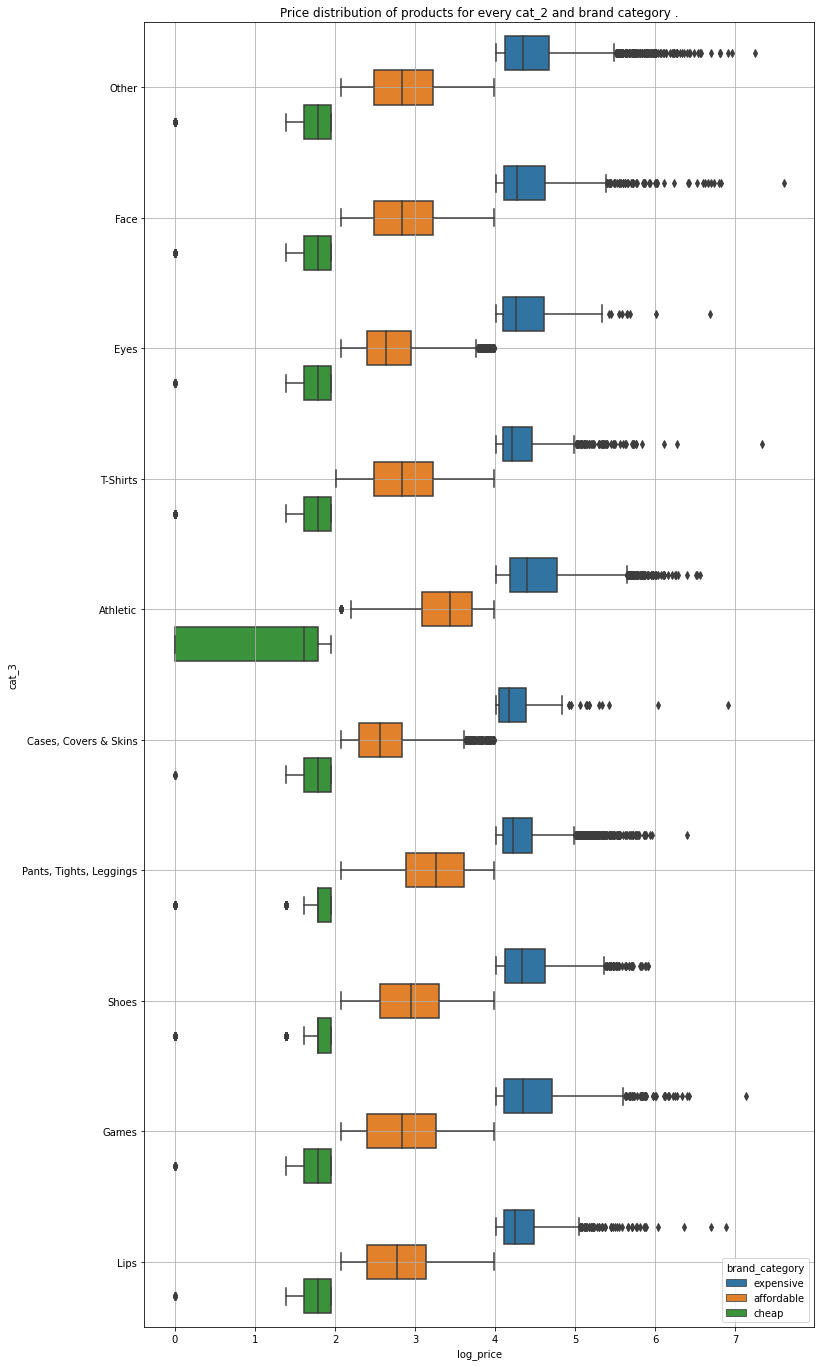

In [ ]:
plt.figure(figsize=(12,24))
plt.title('Price distribution of products for every cat_3 and brand category .')


df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="brand_category", data=df)

plt.grid()
plt.show()

#### Observation:

1. Athletic cat_3 products have most cheap products price range.

### cat_3, item_condition_id, price, brand_category=expensive

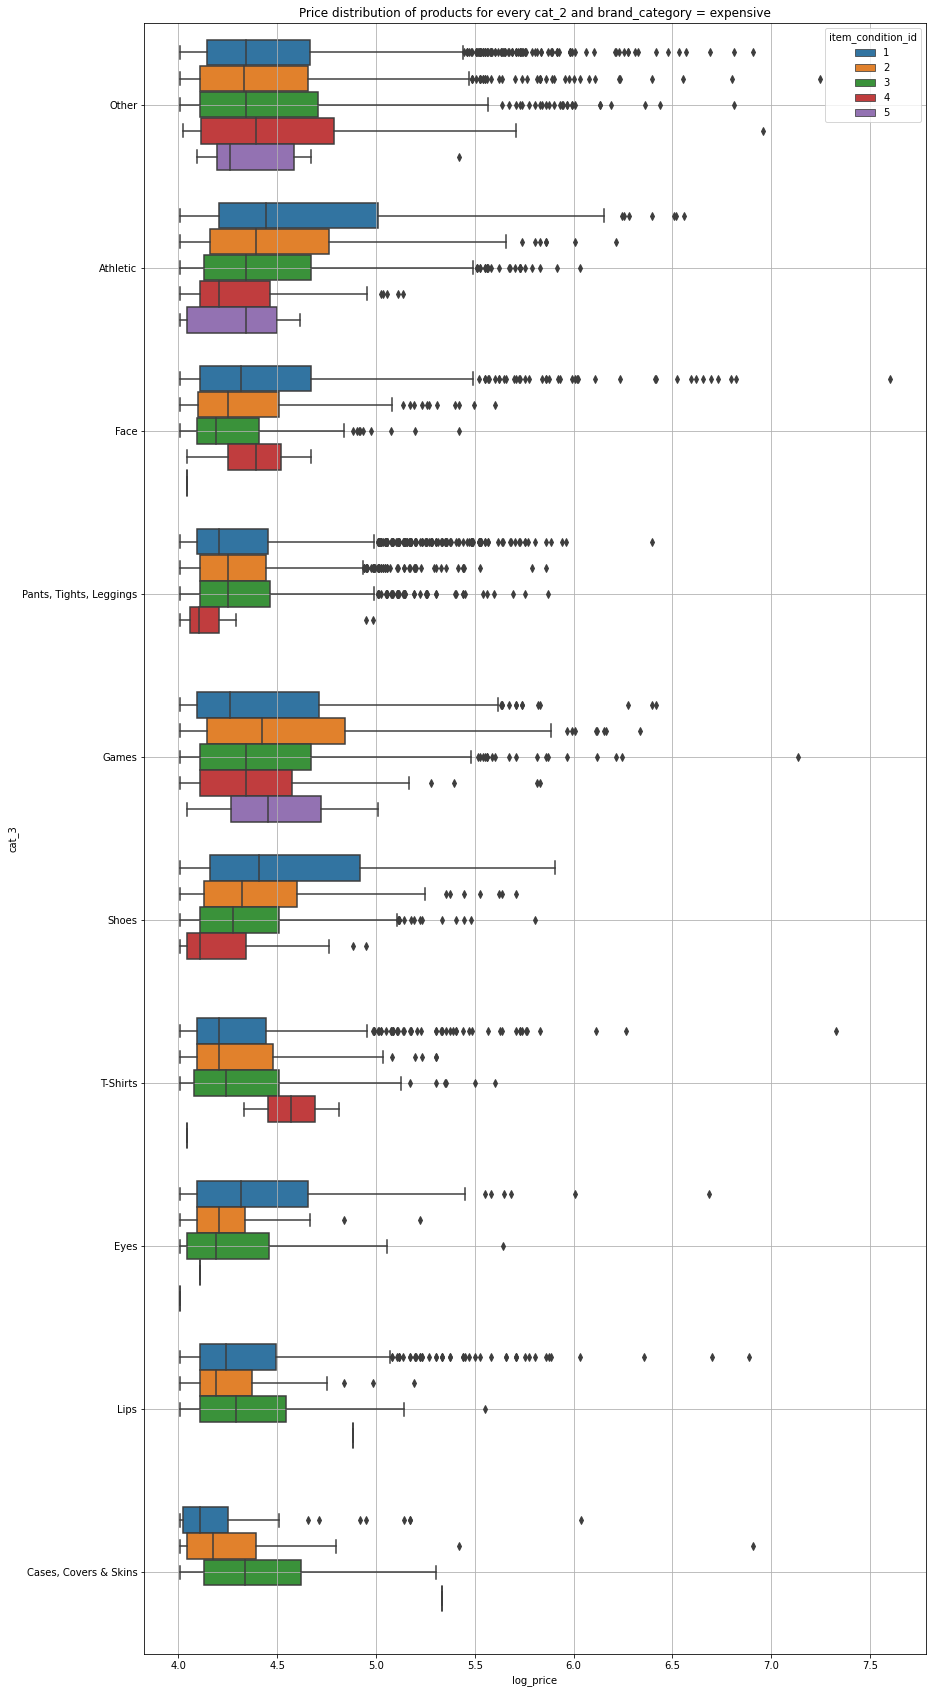

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_3 and brand_category = expensive')

df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))  & (train_df['brand_category']=='expensive')]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Shoes and Athletics category products have more products in expensive category.

### cat_3 item_condition_id, price, brand_category=affordable

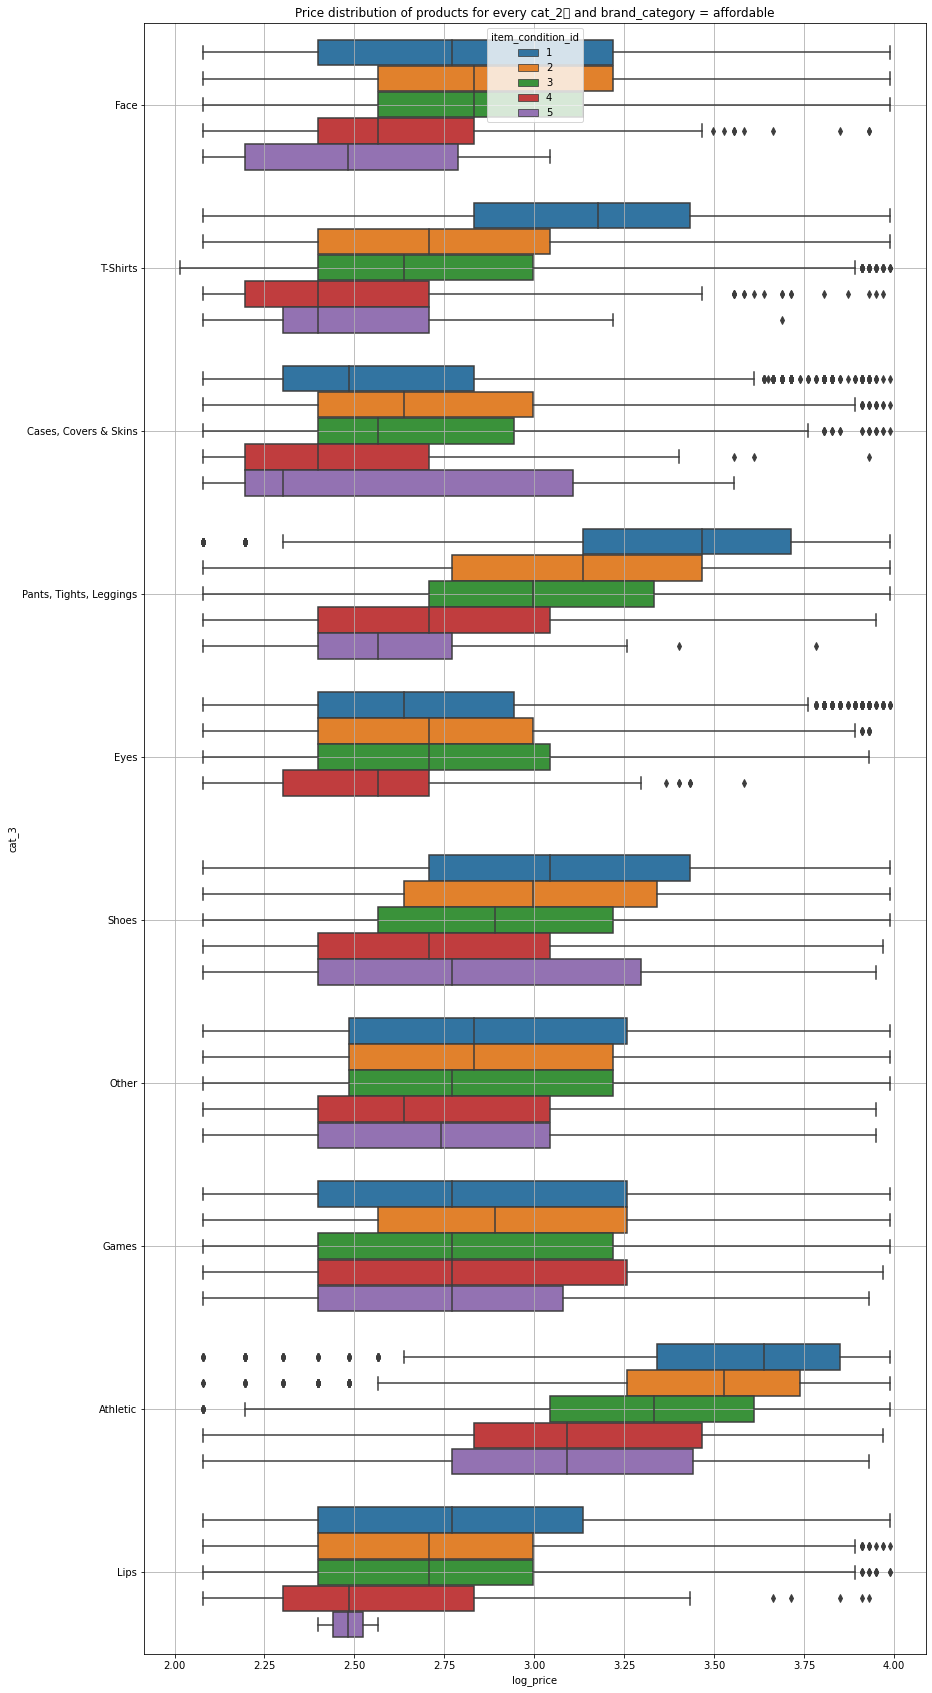

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_3 and brand_category = affordable')

df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))  & (train_df['brand_category']=='affordable')]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. Usually item_condition_id 1, 2 products are more sold than 3,4,5.

### cat_3, item_condition_id, price, brand_category=cheap

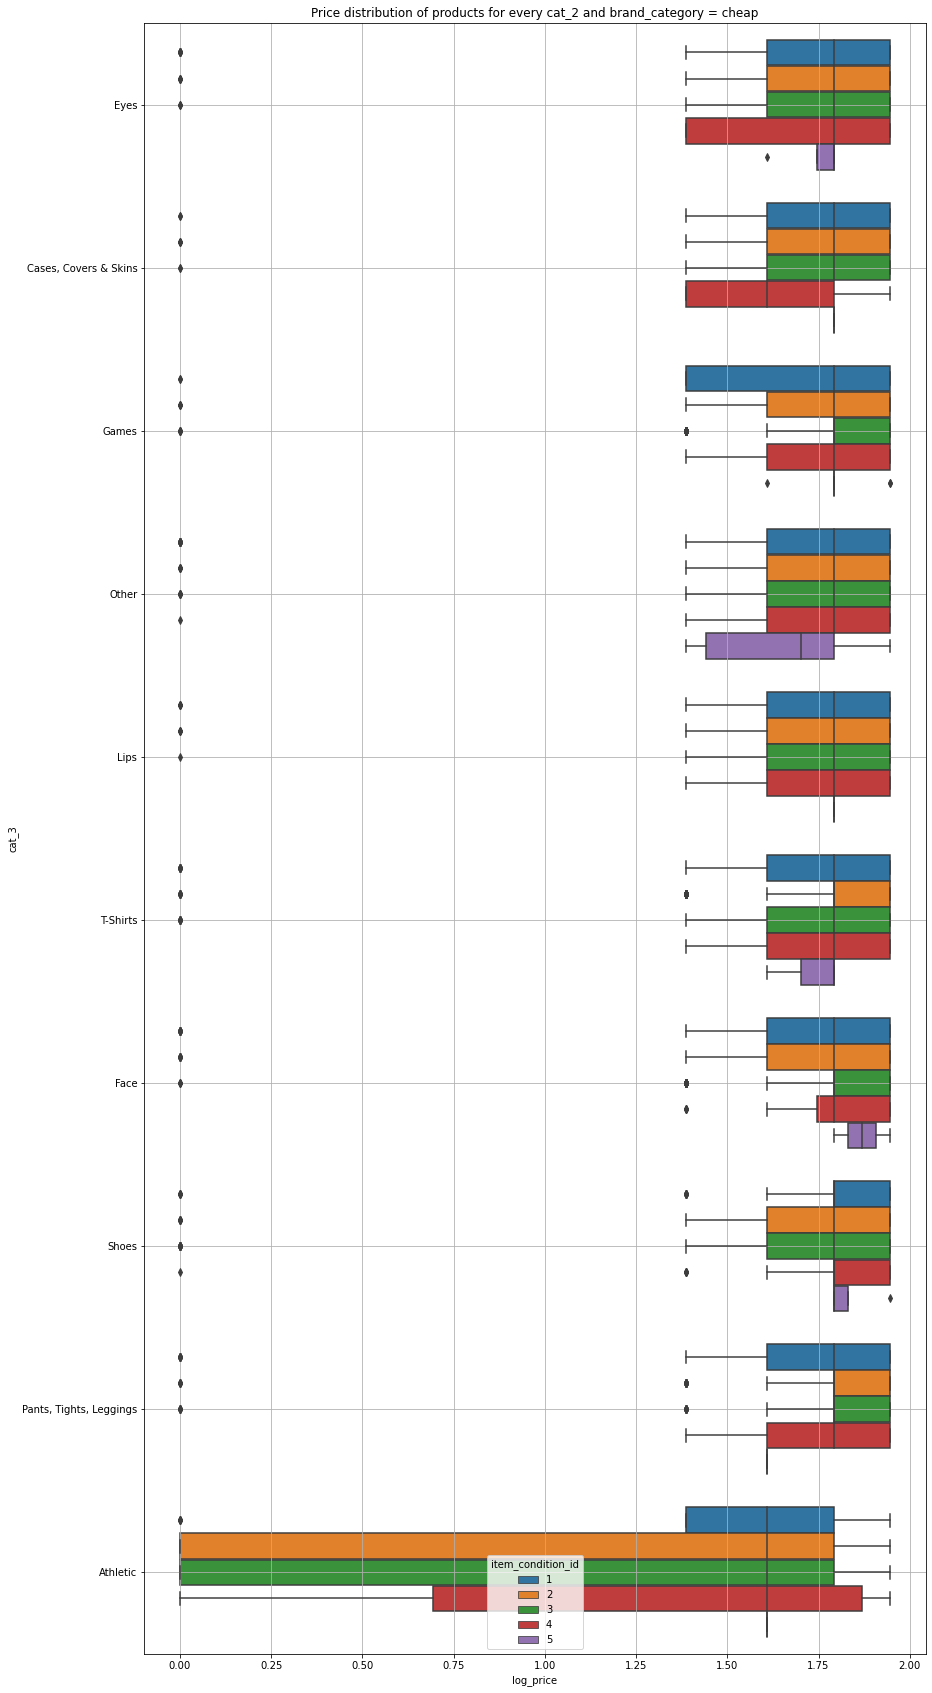

In [ ]:
plt.figure(figsize=(14,30))
plt.title('Price distribution of products for every cat_3 and brand_category = cheap')

df = train_df[(train_df['cat_3'].isin(cat_3_count.index[:10]))  & (train_df['brand_category']=='cheap')]
sns.boxplot(x = "log_price", y = "cat_3", orient = "h", hue="item_condition_id", data=df)

plt.grid()
plt.show()

#### Observation:

1. All the products for every item_condition_id have same price.
2. Athelic category_3 products have most products in cheap_category for every item_condition_id.

# Item Description

### Description count and price.

In [ ]:
description_word_count = []

for description in tqdm(train_df['item_description']):
    description_word_count.append(len(description.split(" ")))

        
train_df['description_count'] = description_word_count


100%|██████████| 1482535/1482535 [00:02<00:00, 602484.71it/s]


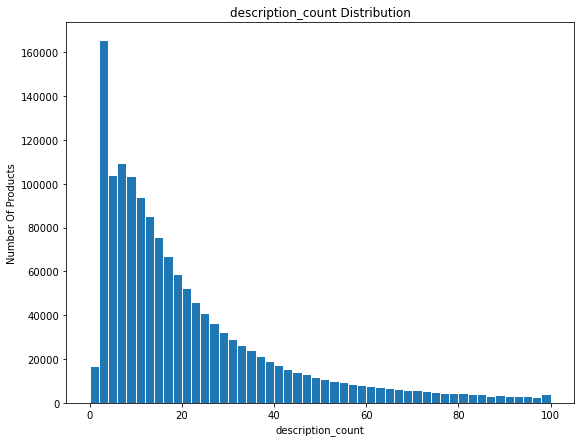

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.hist(train_df['description_count'],bins=50,range=[0,100],edgecolor='white')
plt.title('description_count Distribution')
plt.xlabel('description_count')
plt.ylabel("Number Of Products")

plt.show()

### count < 20 --> low
### 20<count<40 --> medium
### 40<count --> high

In [ ]:
train_df.shape

(1482535, 14)

In [ ]:
description_count_cat = []

for count in tqdm(train_df['description_count']):
    
    if count <= 20:
        description_count_cat.append("low")
    elif 20 < count <= 40:
        description_count_cat.append("medium")
    elif count > 40:
        description_count_cat.append("high")

        
train_df['description_count_cat'] = description_count_cat

100%|██████████| 1482535/1482535 [00:00<00:00, 1980401.88it/s]


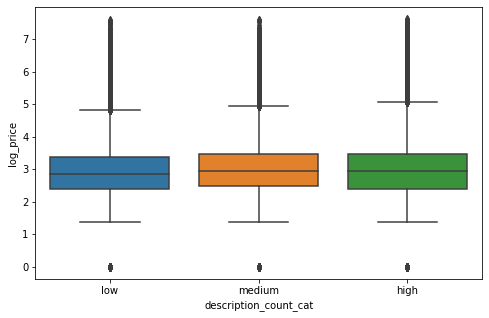

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=train_df['description_count_cat'],y=train_df['log_price'],orient='v')
plt.show()

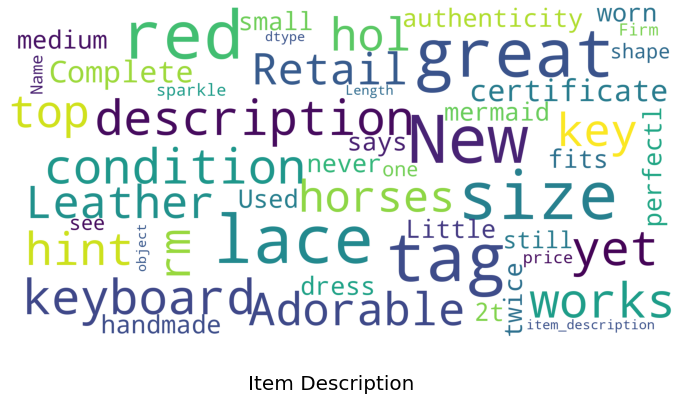

In [ ]:
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=60000000000,
        max_font_size=40, 
        scale=5,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train_df['item_description'], "Item Description")

# Observation

1. RED, GREAT, NEW, LACE, ADORABLE, KEYBOARD, SIZE, DESCRIPTION, CONDITIONS, KEY are the important words in the product description which affects price.

# Data Cleaning

In [ ]:
train_df_path           = "data/train.tsv"
test_df_path            = "data/test.tsv"
test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chart_studio.plotly import plotly
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 

# Reading DataFrame

In [ ]:
train_df = pd.read_csv("data/train_new.csv").drop(['Unnamed: 0'],axis=1)
test_df  = pd.read_csv("data/test_new.csv")
train_df.isnull().any()

Unnamed: 0.1         False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
dtype: bool

In [ ]:
train_df.isnull().any()

Unnamed: 0.1         False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
dtype: bool

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

In [ ]:
num_word_dict = {
    
    "0":"zero",
    "1":"one",
    "2":"tow",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine",
    '+':'plus'
}

def number_to_word(text):
    sentence = ''
    for letter in text:
        try:
            
            if letter.isdigit():
                sentence = sentence + ' ' + num_word_dict[letter]
            else:
                sentence = sentence + letter
        except:
            sentence = sentence + ''
            
    return sentence

def accented_to_english(text):
    return unidecode.unidecode(text)

def fill_description(text):
    if len(text) == 0:
        return "no description yet"
    else:
        return text

def fill_name(text):
    if len(text) == 0:
        return "no name"
    else:
        return text
    
def stemming(sent):
    ps = PorterStemmer()
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
    
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    return sent

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def remove_line(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    
    return sent

def preprocess_cleaning(df):
    df['name'] = df['name'].str.replace('[^A-Za-z0-9_ ]', '')
    df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace('  ', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
    df['brand_name'] = df['brand_name'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['brand_name'] = df['brand_name'].apply(number_to_word)# converting number to letter
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace('  ', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    
    df['cat_1'] = df['cat_1'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
    
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    
    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + "/" + df['cat_2'] + "/" + df['cat_3']
    
    df['brand_category'] = df['brand_category'].str.lower()
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    df['item_description'] = df['item_description'].apply(stemming)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['item_description'] = df['item_description'].apply(number_to_word)# converting number to letter
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace('  ', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    
    return df
    
    
def preprocess_cleaning(df):
    df['name'] = df['name'].str.replace('[^A-Za-z0-9_ ]', '')
    df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace('  ', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
    df['brand_name'] = df['brand_name'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['brand_name'] = df['brand_name'].apply(number_to_word)# converting number to letter
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace('  ', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    
    df['cat_1'] = df['cat_1'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
    
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    
    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + "/" + df['cat_2'] + "/" + df['cat_3']
    
    df['brand_category'] = df['brand_category'].str.lower()
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    df['item_description'] = df['item_description'].apply(stemming)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['item_description'] = df['item_description'].apply(number_to_word)# converting number to letter
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace('  ', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    
    return df


def test_preprocess_cleaning(df):
    df['name'] = df['name'].str.replace('[^A-Za-z0-9_ ]', '')
    df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace('  ', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
    df['brand_name'] = df['brand_name'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['brand_name'] = df['brand_name'].apply(number_to_word)# converting number to letter
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace('  ', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    
    df['cat_1'] = df['cat_1'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
    
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    
    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace('  ', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + "/" + df['cat_2'] + "/" + df['cat_3']
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    df['item_description'] = df['item_description'].apply(stemming)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace('[^A-Za-z0-9_ ]', '')# remove all char except words and letters
    df['item_description'] = df['item_description'].apply(number_to_word)# converting number to letter
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace('  ', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    df['item_description'].fillna(value = "no description yet", inplace = True)
    
    return df


In [ ]:
%%time
train_df = preprocess_cleaning(train_df)

NameError: name 'PorterStemmer' is not defined

In [ ]:
%%time
test_df = test_preprocess_cleaning(test_df)
test_df['item_description'].fillna(value = "no description yet", inplace = True)

NameError: name 'PorterStemmer' is not defined

# Saving Cleaned Data Frame

In [ ]:
train_df.to_csv("data/train_cleaned.csv")
test_df.to_csv("data/test_cleaned.csv")

# Reading Cleaned Data

In [ ]:
train_df = pd.read_csv('data/train_cleaned.csv')
test_df = pd.read_csv('data/test_cleaned.csv')

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
dtype: bool

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description      True
cat_1                False
cat_2                False
cat_3                False
dtype: bool

In [ ]:
df1 = train_df[train_df.isna().any(axis=1)]
df1 = test_df[test_df.isna().any(axis=1)]

In [ ]:
df1

Unnamed: 0  Unnamed: 0.1  test_id  name  item_condition_id  \
33770       33770         33770    33770  toms                  1   

           category_name brand_name  shipping item_description  cat_1  cat_2  \
33770  women/shoes/flats      other         1              NaN  women  shoes   

       cat_3  
33770  flats

## Test data clean and preprocess

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
dtype: bool

# Feature Engineering

## Expensive, affordable, cheap brand names

In [ ]:
expensive_brands = np.unique(train_df[train_df['brand_category']=='expensive']['brand_name'].values)
affordable_brands = np.unique(train_df[train_df['brand_category']=='affordable']['brand_name'].values)
cheap_brands = np.unique(train_df[train_df['brand_category']=='cheap']['brand_name'].values)

In [ ]:
def test_brand_category_func(brand, expensive_brands, affordable_brands, cheap_brands):
    if brand in expensive_brands:
        return 'expensive'
    elif brand in affordable_brands:
        return 'affordable'
    else:
        return 'cheap'
    
test_df['brand_category'] = test_df.apply(lambda x: test_brand_category_func(str(x.brand_name),expensive_brands ,affordable_brands ,cheap_brands), axis=1)
    

In [ ]:
## desc_words_count

## https://stackoverflow.com/questions/15625629/regex-expressions-in-java-s-vs-s
## \s+ --> count of all space char


train_df['desc_word_count'] = (train_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.float32)
test_df['desc_word_count'] = (test_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.float32)

In [ ]:
## desc_char_count

train_df['desc_char_count'] = train_df['item_description'].str.len().fillna(0).astype(np.float32)
test_df['desc_char_count'] = test_df['item_description'].str.len().fillna(0).astype(np.float32)


In [ ]:
## name_words

train_df['name_word_count'] = (train_df['name'].str.count("\s+")+1).fillna(0).astype(int)
test_df['name_word_count'] = (test_df['name'].str.count("\s+")+1).fillna(0).astype(int)


In [ ]:
## name_chars

train_df['name_char_count'] = train_df['name'].str.len().fillna(0).astype(int)
test_df['name_char_count'] = test_df['name'].str.len().fillna(0).astype(int)


In [ ]:
## brand_counts

## https://www.geeksforgeeks.org/python-pandas-map/

train_df['brand_count'] = train_df['brand_name'].map(train_df["brand_name"].value_counts()).fillna(0).astype(int)
test_df['brand_count'] = test_df['brand_name'].map(test_df["brand_name"].value_counts()).fillna(0).astype(int)


In [ ]:
## cat_counts

train_df['cat_count'] = train_df['category_name'].map(train_df["category_name"].value_counts()).fillna(0).astype(int)
test_df['cat_count'] = test_df['category_name'].map(test_df["category_name"].value_counts()).fillna(0).astype(int)


In [ ]:
## cat1_counts

train_df['cat_1_count'] = train_df['cat_1'].map(train_df["cat_1"].value_counts()).fillna(0).astype(int)
test_df['cat_1_count'] = test_df['cat_1'].map(test_df["cat_1"].value_counts()).fillna(0).astype(int)


In [ ]:
## cat2_counts

train_df['cat_2_count'] = train_df['cat_2'].map(train_df["cat_2"].value_counts()).fillna(0).astype(int)
test_df['cat_2_count'] = test_df['cat_2'].map(test_df["cat_2"].value_counts()).fillna(0).astype(int)


In [ ]:
## cat3_counts

train_df['cat_3_count'] = train_df['cat_3'].map(train_df["cat_3"].value_counts()).fillna(0).astype(int)
test_df['cat_3_count'] = test_df['cat_3'].map(test_df["cat_3"].value_counts()).fillna(0).astype(int)


In [ ]:
## brand_cat

train_df["brand_cat"] = (train_df["brand_name"].astype(str) + ' ' + train_df["category_name"].astype(str)).astype('category')
test_df["brand_cat"] = (test_df["brand_name"].astype(str) + ' ' + test_df["category_name"].astype(str)).astype('category')



In [ ]:
## cat_cond

train_df["cat_cond"] = (train_df["category_name"].astype(str) + ' ' + train_df["item_condition_id"].astype(str)).astype('category')
test_df["cat_cond"] = (test_df["category_name"].astype(str) + ' ' + test_df["item_condition_id"].astype(str)).astype('category')



In [ ]:
## brand_cond

train_df["brand_cond"] = (train_df["brand_name"].astype(str) + ' ' + train_df["item_condition_id"].astype(str)).astype('category')
test_df["brand_cond"] = (test_df["brand_name"].astype(str) + ' ' + test_df["item_condition_id"].astype(str)).astype('category')


In [ ]:
## category_shipping

train_df["cat_shipping"] = (train_df["category_name"].astype(str) + ' ' + train_df["shipping"].astype(str)).astype('category')
test_df["cat_shipping"] = (test_df["category_name"].astype(str) + ' ' + test_df["shipping"].astype(str)).astype('category')



In [ ]:
## brand_cat_counts

train_df["brand_cat_count"] = train_df['brand_cat'].map(train_df["brand_cat"].value_counts()).fillna(0).astype(int) 
test_df["brand_cat_count"] = test_df['brand_cat'].map(test_df["brand_cat"].value_counts()).fillna(0).astype(int)


In [ ]:
train_df.to_csv("data/train_cleaned.csv")

In [ ]:
test_df.to_csv("data/test_cleaned.csv")

# Read Final Feature Data Frame

In [ ]:
train_df_new = pd.read_csv('data/train_cleaned.csv')

In [ ]:
test_df_new = pd.read_csv('data/test_cleaned.csv')

In [ ]:
test_submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
test_df_new = test_df_new.merge(test_submission, how='inner', on='test_id')

In [ ]:
train_df_new.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
log_price            False
brand_category       False
desc_word_count      False
desc_char_count      False
name_word_count      False
name_char_count      False
brand_count          False
cat_count            False
cat_1_count          False
cat_2_count          False
cat_3_count          False
brand_cat            False
cat_cond             False
brand_cond           False
cat_shipping         False
brand_cat_count      False
dtype: bool

In [ ]:
test_df_new.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
brand_category       False
desc_word_count      False
desc_char_count      False
name_word_count      False
name_char_count      False
brand_count          False
cat_count            False
cat_1_count          False
cat_2_count          False
cat_3_count          False
brand_cat            False
cat_cond             False
brand_cond           False
cat_shipping         False
brand_cat_count      False
price                False
dtype: bool

In [ ]:
test_df_new['item_description'].fillna(value = "no description yet", inplace = True)

In [ ]:
test_df_new.isnull().any()

Unnamed: 0           False
Unnamed: 0.1         False
test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
cat_1                False
cat_2                False
cat_3                False
brand_category       False
desc_word_count      False
desc_char_count      False
name_word_count      False
name_char_count      False
brand_count          False
cat_count            False
cat_1_count          False
cat_2_count          False
cat_3_count          False
brand_cat            False
cat_cond             False
brand_cond           False
cat_shipping         False
brand_cat_count      False
price                False
dtype: bool

# Vectorization

In [ ]:
train_df_path           = "data/train.tsv"
test_df_path            = "data/test.tsv"
test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools

# Train Test Data

In [ ]:

y = train_df_new['log_price']
y_test = np.log(test_df_new['price']) + 1
x_train = train_df_new.drop(['log_price'], axis=1)
x_test  = test_df_new


In [ ]:
x_train.shape, x_test.shape

((1482535, 28), (693359, 28))

## Name

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)

name_maxlen = 7

tokenizer.fit_on_texts(x_train['name'])

train_name = tokenizer.texts_to_sequences(x_train['name'])
test_name = tokenizer.texts_to_sequences(x_test['name'])

vocab_size = len(tokenizer.word_index) + 1

train_name_padded = keras.preprocessing.sequence.pad_sequences(train_name, padding='post', maxlen=name_maxlen)
test_name_padded  = keras.preprocessing.sequence.pad_sequences(test_name, padding='post', maxlen=name_maxlen)

print("train {}".format(train_name_padded.shape))
print("test {}".format(test_name_padded.shape))

train (1482535, 7)
test (693359, 7)


In [ ]:
name_vocab = len(tokenizer.word_index) + 1

## Brand Name

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)

tokenizer.fit_on_texts(x_train['brand_name'])
train_brand_name = tokenizer.texts_to_sequences(x_train['brand_name'])
test_brand_name  = tokenizer.texts_to_sequences(x_test['brand_name'])


In [ ]:
brand_name_vocab = len(tokenizer.word_index) + 1

## Item Description

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)

desc_maxlen = 70

tokenizer.fit_on_texts(x_train['item_description'])

train_item_description = tokenizer.texts_to_sequences(x_train['item_description'])
test_item_description = tokenizer.texts_to_sequences(x_test['item_description'])

vocab_size = len(tokenizer.word_index) + 1

train_item_description_padded = keras.preprocessing.sequence.pad_sequences(train_item_description, padding='post', maxlen=desc_maxlen)
test_item_description_padded  = keras.preprocessing.sequence.pad_sequences(test_item_description, padding='post', maxlen=desc_maxlen)

print("train {}".format(train_item_description_padded.shape))
print("test {}".format(test_item_description_padded.shape))

train (1482535, 70)
test (693359, 70)


In [ ]:
item_desc_vocab = len(tokenizer.word_index) + 1

## Item Condition id

In [ ]:
vect = LabelEncoder()

train_item_condition_id = vect.fit_transform(x_train['item_condition_id']).reshape(-1, 1)
test_item_condition_id  = vect.transform(x_test['item_condition_id']).reshape(-1, 1)

print("train {}".format(train_item_condition_id.shape))
print("test {}".format(test_item_condition_id.shape))

train (1482535, 1)
test (693359, 1)


## shipping

In [ ]:
vect = LabelEncoder()

train_shipping = vect.fit_transform(x_train['shipping']).reshape(-1, 1)
test_shipping  = vect.transform(x_test['shipping']).reshape(-1, 1)

print("train {}".format(train_shipping.shape))
print("test {}".format(test_shipping.shape))

train (1482535, 1)
test (693359, 1)


## category name

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)


tokenizer.fit_on_texts(x_train['category_name'])

train_category_name = tokenizer.texts_to_sequences(x_train['category_name'])
test_category_name  = tokenizer.texts_to_sequences(x_test['category_name'])


In [ ]:
cat_name_vocab = len(tokenizer.word_index) + 1

In [ ]:
train_category_name

[[54],
 [113, 2, 380, 2, 361],
 [4, 2, 33],
 [22, 46, 64, 67],
 [39],
 [116],
 [68],
 [25, 2, 488],
 [25, 2, 488],
 [13, 2, 419],
 [18],
 [44],
 [36, 37, 38],
 [82, 272, 85],
 [41],
 [24, 100],
 [27],
 [269, 2, 270],
 [24, 40],
 [4, 2, 33],
 [4, 2, 34, 35],
 [3, 94, 95],
 [10, 6, 2, 42, 6, 2, 102],
 [10, 6, 2, 245, 2, 246],
 [4, 2, 14],
 [60],
 [10, 6, 2, 28, 26, 2, 29],
 [3, 7, 8, 9],
 [172],
 [129, 119],
 [27],
 [3, 7, 8, 9],
 [31],
 [21, 49],
 [135, 136, 2, 137],
 [3, 7, 8, 9],
 [5, 91, 2, 92],
 [79, 47, 2, 48],
 [16, 17, 2, 163],
 [31],
 [24, 100],
 [31],
 [21, 49],
 [18],
 [13, 2, 331],
 [55, 2, 213],
 [120, 2, 121],
 [4, 2, 33],
 [289, 196],
 [27],
 [5, 97, 2, 98],
 [12, 106],
 [13, 2, 152],
 [31],
 [30, 2, 89, 2, 90, 11],
 [13, 2, 583],
 [21, 49],
 [269, 2, 270],
 [269, 2, 270],
 [10, 6, 2, 279],
 [81],
 [3, 7, 8, 9],
 [3, 32],
 [3, 32],
 [189, 2, 173, 138],
 [63, 2, 11],
 [39],
 [114],
 [3, 88],
 [10, 6, 2, 28, 26, 2, 29],
 [69],
 [39],
 [22, 46, 151],
 [15, 19, 249],
 [30, 2, 

## cat_1

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)


tokenizer.fit_on_texts(x_train['cat_1'])

train_cat_1 = tokenizer.texts_to_sequences(x_train['cat_1'])
test_cat_1  = tokenizer.texts_to_sequences(x_test['cat_1'])

In [ ]:
cat_1_vocab = len(tokenizer.word_index) + 1

## cat_2

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)


tokenizer.fit_on_texts(x_train['cat_2'])

train_cat_2 = tokenizer.texts_to_sequences(x_train['cat_2'])
test_cat_2  = tokenizer.texts_to_sequences(x_test['cat_2'])

In [ ]:
cat_2_vocab = len(tokenizer.word_index) + 1

## cat_3

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)


tokenizer.fit_on_texts(x_train['cat_3'])

train_cat_3 = tokenizer.texts_to_sequences(x_train['cat_3'])
test_cat_3  = tokenizer.texts_to_sequences(x_test['cat_3'])

In [ ]:
cat_3_vocab = len(tokenizer.word_index) + 1

## Brand Category

In [ ]:

vect = LabelEncoder()

train_brand_cat = vect.fit_transform(x_train['brand_category']).reshape(-1, 1)
test_brand_cat  = vect.transform(x_test['brand_category']).reshape(-1, 1)

print("train {}".format(train_item_condition_id.shape))
print("test {}".format(test_item_condition_id.shape))


train (1482535, 1)
test (693359, 1)


## Desc_word_count

In [ ]:

train_desc_word_count = x_train['desc_word_count'].astype(np.float32).values.reshape(-1, 1)
test_desc_word_count = x_test['desc_word_count'].astype(np.float32).values.reshape(-1, 1)


## Desc_char_count

In [ ]:
train_desc_char_count = x_train['desc_char_count'].astype(np.float32).values.reshape(-1, 1)
test_desc_char_count = x_test['desc_char_count'].astype(np.float32).values.reshape(-1, 1)

## Name_word_count

In [ ]:
train_name_word_count = x_train['name_word_count'].astype(np.float32).values.reshape(-1, 1)
test_name_word_count = x_test['name_word_count'].astype(np.float32).values.reshape(-1, 1)

## name_char_count

In [ ]:
train_name_char_count = x_train['name_char_count'].astype(np.float32).values.reshape(-1, 1)
test_name_char_count = x_test['name_char_count'].astype(np.float32).values.reshape(-1, 1)

## brand_count

In [ ]:
train_brand_count = x_train['brand_count'].astype(np.float32).values.reshape(-1, 1)
test_brand_count = x_test['brand_count'].astype(np.float32).values.reshape(-1, 1)

## cat_count

In [ ]:
train_cat_count = x_train['cat_count'].astype(np.float32).values.reshape(-1, 1)
test_cat_count = x_test['cat_count'].astype(np.float32).values.reshape(-1, 1)

## cat_1_count

In [ ]:
train_cat_1_count = x_train['cat_1_count'].astype(np.float32).values.reshape(-1, 1)
test_cat_1_count = x_test['cat_1_count'].astype(np.float32).values.reshape(-1, 1)

## cat_2_count

In [ ]:
train_cat_2_count = x_train['cat_2_count'].astype(np.float32).values.reshape(-1, 1)
test_cat_2_count = x_test['cat_2_count'].astype(np.float32).values.reshape(-1, 1)

## cat_3_count

In [ ]:
train_cat_3_count = x_train['cat_3_count'].astype(np.float32).values.reshape(-1, 1)
test_cat_3_count = x_test['cat_3_count'].astype(np.float32).values.reshape(-1, 1)

## brand_cat_count

In [ ]:
train_brand_cat_count = x_train['brand_cat_count'].astype(np.float32).values.reshape(-1, 1)
test_brand_cat_count = x_test['brand_cat_count'].astype(np.float32).values.reshape(-1, 1)

In [ ]:
## brand_cat

In [ ]:
x_train['brand_cat']

0                                    other Men/Tops/T-shirts
1          Razer Electronics/Computers & Tablets/Componen...
2                         Target Women/Tops & Blouses/Blouse
3                   other Home/Home Décor/Home Décor Accents
4                              other Women/Jewelry/Necklaces
                                 ...                        
1482530                   Free People Women/Dresses/Mid-Calf
1482531                      Disney Kids/Girls 2T-5T/Dresses
1482532    other Sports & Outdoors/Exercise/Fitness acces...
1482533             other Home/Home Décor/Home Décor Accents
1482534              other Women/Women's Accessories/Wallets
Name: brand_cat, Length: 1482535, dtype: object

In [ ]:
tokenizer  = keras.preprocessing.text.Tokenizer( num_words=None,
    filters="",
    lower=True,
    split=' ',
    char_level=False,
    oov_token="None",
    document_count=0)


tokenizer.fit_on_texts(x_train['brand_cat'])

train_brand_cat = tokenizer.texts_to_sequences(x_train['brand_cat'])
test_brand_cat  = tokenizer.texts_to_sequences(x_test['brand_cat'])

In [ ]:
x_train['category_name']

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1482535, dtype: object

In [ ]:
train_brand_cat

[[3, 65],
 [1632, 149, 2, 600, 2, 566],
 [387, 5, 2, 39],
 [3, 28, 53, 78, 82],
 [3, 45],
 [3, 152],
 [851, 844, 83],
 [1363, 30, 2, 786],
 [12, 30, 2, 786],
 [3, 16, 2, 663],
 [505, 23],
 [18, 17, 51],
 [613, 43, 44, 42],
 [2679, 103, 405, 109],
 [210, 211, 48],
 [206, 31, 126],
 [353, 541, 534, 33],
 [3, 401, 2, 402],
 [179, 180, 31, 47],
 [614, 5, 2, 39],
 [337, 5, 2, 40, 41],
 [18, 17, 4, 120, 121],
 [229, 13, 7, 2, 49, 7, 2, 130],
 [3, 13, 7, 2, 357, 2, 358],
 [63, 64, 5, 2, 19],
 [243, 192, 72],
 [54, 13, 7, 2, 34, 32, 2, 35],
 [25, 4, 8, 9, 10],
 [63, 64, 239],
 [148, 165, 155],
 [179, 180, 33],
 [3, 4, 8, 9, 10],
 [11, 37],
 [90, 27, 57],
 [3, 177, 178, 2, 176],
 [3, 4, 8, 9, 10],
 [3, 6, 116, 2, 117],
 [133, 134, 100, 55, 2, 56],
 [184, 22, 21, 2, 224],
 [18, 17, 37],
 [299, 159, 31, 126],
 [11, 37],
 [3, 27, 57],
 [3, 23],
 [3, 16, 2, 518],
 [132, 172, 173, 66, 2, 305],
 [3, 156, 2, 157],
 [186, 187, 5, 2, 39],
 [58, 587, 437, 280],
 [3, 33],
 [75, 77, 6, 124, 2, 125],
 [3, 1

In [ ]:
## cat_cond

In [ ]:
## brand_cond

In [ ]:
## cat_shipping

In [ ]:

train_name_padded = np.array(train_name_padded)
train_brand_name = np.array(train_brand_name)
train_item_description_padded = np.array(train_item_description_padded)
train_item_condition_id = np.array(train_item_condition_id)
train_shipping = np.array(train_shipping)
train_category_name = np.array(train_category_name)
train_cat_1 = np.array(train_cat_1)
train_cat_2 = np.array(train_cat_2)
train_cat_3 = np.array(train_cat_3)
train_brand_cat = np.array(train_brand_cat)


test_name_padded = np.array(test_name_padded)
test_brand_name = np.array(test_brand_name)
test_item_description_padded = np.array(test_item_description_padded)
test_item_condition_id = np.array(test_item_condition_id)
test_shipping = np.array(test_shipping)
test_category_name = np.array(test_category_name)
test_cat_1 = np.array(test_cat_1)
test_cat_2 = np.array(test_cat_2)
test_cat_3 = np.array(test_cat_3)
test_brand_cat = np.array(test_brand_cat)


# Model training

In [ ]:
# %%time
# ridgeReg = Ridge(alpha=1,solver = "lsqr", fit_intercept=False )
# ridgeReg.fit(train_merge, y)

# y_test_pred = ridgeReg.predict(test_merge)


# ridge_RMSLE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# print('TEST --> Ridge RMSLE: ', ridge_RMSLE_test)

# Factorization Machine - 1

In [ ]:
np.array(train_name_padded).shape

(1482535, 7)

In [ ]:
keras.backend.clear_session()


embd_dim = 60


input__name = keras.layers.Input(shape=(train_name_padded.shape[1]),)

input__brand_name = keras.layers.Input(shape=(train_brand_name.shape[1]),)

input__desc = keras.layers.Input(shape=(train_item_description_padded.shape[1]),)

input__cond_id = keras.layers.Input(shape=(train_item_condition_id.shape[1]),)

input__shipping = keras.layers.Input(shape=(train_shipping.shape[1]),)

input__cat = keras.layers.Input(shape=(train_category_name.shape[1]),)

input__cat_1 = keras.layers.Input(shape=(train_cat_1.shape[1]),)

input__cat_2 = keras.layers.Input(shape=(train_cat_2.shape[1]),)

input__cat_3 = keras.layers.Input(shape=(train_cat_3.shape[1]),)

input__brand_cat = keras.layers.Input(shape=(train_brand_cat.shape[1]),)

input__layers = [
    
    ('name', name_vocab, train_name_padded.shape[1], input__name),
    ('brand_name',brand_name_vocab, (train_brand_name.shape[1]), input__brand_name),
    ('desc', item_desc_vocab, (train_item_description_padded.shape[1]), input__desc),
    ('cond_id', 5, (train_item_condition_id.shape[1]), input__cond_id),
    ('shipping', 2, (train_shipping.shape[1]), input__shipping),
    ('cat',cat_name_vocab, (train_category_name.shape[1]), input__cat),
    ('cat_1',cat_1_vocab, (train_cat_1.shape[1]), input__cat_1),
    ('cat_2',cat_2_vocab, (train_cat_2.shape[1]), input__cat_2),
    ('cat_3',cat_3_vocab, (train_cat_3.shape[1]), input__cat_3),
    ('brand_cat', 3, (train_brand_cat.shape[1]), input__brand_cat),
    
]

inputs = []
flatten_layers = []

for col in input__layers:
    name = col[0]
    input_dim = col[1]
    output_dim = 60
    input_len = col[2]
    input_layer = col[3]
    
    inputs.append(input_layer)
    embd = keras.layers.Embedding(input_dim = input_dim,
                                   output_dim = output_dim,
                                   input_length = input_len, name=name) (input_layer)
    
    
    if input_len > 1:
        flatten = keras.layers.GlobalAveragePooling1D()(embd)
    else:
        flatten = keras.layers.Flatten()(embd)
        
    flatten_layers.append(flatten)
    
    
fm_layers = []
for emb1,emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = keras.layers.Multiply()([emb1, emb2])
    fm_layers.append(dot_layer)

out = keras.layers.Add() (fm_layers)
out = keras.layers.Dense(250, activation='relu', kernel_initializer='he_normal')(out)
out = keras.layers.Dense(1, kernel_initializer='normal')(out)
model = keras.Model(inputs, out)

model.summary()
    
    

    

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.005, decay=0.00, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
X_train = [train_name_padded,
           train_brand_name,
           train_item_description_padded,
           train_item_condition_id,
           train_shipping,
           train_category_name,
           train_cat_1,
           train_cat_2,
           train_cat_3,
           train_brand_cat ]

X_test = [test_name_padded,
           test_brand_name,
           test_item_description_padded,
           test_item_condition_id,
           test_shipping,
           test_category_name,
           test_cat_1,
           test_cat_2,
           test_cat_3,
           test_brand_cat ]



In [ ]:
checkpoint_filepath = 'check_point/fm_1.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(X_train, y, batch_size=2000, epochs=3,
                               verbose=1,
                              validation_data=(X_test, y_test), shuffle=True,callbacks=[model_checkpoint_callback])

Epoch 1/3
742/742 [==============================] - 194s 262ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012 - val_loss: 0.1710 - val_root_mean_squared_error: 0.4135
Epoch 2/3
742/742 [==============================] - 252s 340ms/step - loss: 0.1121 - root_mean_squared_error: 0.3349 - val_loss: 0.1384 - val_root_mean_squared_error: 0.3721
Epoch 3/3
742/742 [==============================] - 239s 322ms/step - loss: 0.0999 - root_mean_squared_error: 0.3160 - val_loss: 0.1363 - val_root_mean_squared_error: 0.3692


# FM Model - 2

In [ ]:
keras.backend.clear_session()


embd_dim = 60


input__name = keras.layers.Input(shape=(train_name_padded.shape[1]),)

input__brand_name = keras.layers.Input(shape=(train_brand_name.shape[1]),)

input__desc = keras.layers.Input(shape=(train_item_description_padded.shape[1]),)

input__cond_id = keras.layers.Input(shape=(train_item_condition_id.shape[1]),)

input__shipping = keras.layers.Input(shape=(train_shipping.shape[1]),)

input__cat = keras.layers.Input(shape=(train_category_name.shape[1]),)

input__cat_1 = keras.layers.Input(shape=(train_cat_1.shape[1]),)

input__cat_2 = keras.layers.Input(shape=(train_cat_2.shape[1]),)

input__cat_3 = keras.layers.Input(shape=(train_cat_3.shape[1]),)

input__brand_cat = keras.layers.Input(shape=(train_brand_cat.shape[1]),)

input__layers = [
    
    ('name', name_vocab, train_name_padded.shape[1], input__name),
    ('brand_name',brand_name_vocab, (train_brand_name.shape[1]), input__brand_name),
    ('desc', item_desc_vocab, (train_item_description_padded.shape[1]), input__desc),
    ('cond_id', 5, (train_item_condition_id.shape[1]), input__cond_id),
    ('shipping', 2, (train_shipping.shape[1]), input__shipping),
    ('cat',cat_name_vocab, (train_category_name.shape[1]), input__cat),
    ('cat_1',cat_1_vocab, (train_cat_1.shape[1]), input__cat_1),
    ('cat_2',cat_2_vocab, (train_cat_2.shape[1]), input__cat_2),
    ('cat_3',cat_3_vocab, (train_cat_3.shape[1]), input__cat_3),
    ('brand_cat', 3, (train_brand_cat.shape[1]), input__brand_cat),
    
]

inputs = []
flatten_layers = []

for col in input__layers:
    name = col[0]
    input_dim = col[1]
    output_dim = 60
    input_len = col[2]
    input_layer = col[3]
    
    inputs.append(input_layer)
    embd = keras.layers.Embedding(input_dim = input_dim,
                                   output_dim = output_dim,
                                   input_length = input_len, name=name) (input_layer)
    
    
    if input_len > 1:
        flatten = keras.layers.GlobalAveragePooling1D()(embd)
    else:
        flatten = keras.layers.Flatten()(embd)
        
    flatten_layers.append(flatten)
    
    
fm_layers = []
for emb1,emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = keras.layers.Multiply()([emb1, emb2])
    fm_layers.append(dot_layer)

out = keras.layers.Add() (fm_layers)
out = keras.layers.Dense(250, activation='relu', kernel_initializer='he_normal')(out)
out = keras.layers.Dense(1, kernel_initializer='normal')(out)
model = keras.Model(inputs, out)

model.summary()
    
    

    

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.005, decay=0.00, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
X_train = [train_name_padded,
           train_brand_name,
           train_item_description_padded,
           train_item_condition_id,
           train_shipping,
           train_category_name,
           train_cat_1,
           train_cat_2,
           train_cat_3,
           train_brand_cat ]

X_test = [test_name_padded,
           test_brand_name,
           test_item_description_padded,
           test_item_condition_id,
           test_shipping,
           test_category_name,
           test_cat_1,
           test_cat_2,
           test_cat_3,
           test_brand_cat ]



In [ ]:
checkpoint_filepath = 'check_point/fm_2.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(X_train, y, batch_size=2000, epochs=3,
                               verbose=1,
                              validation_data=(X_test, y_test), shuffle=True,callbacks=[model_checkpoint_callback])

Epoch 1/3
742/742 [==============================] - 222s 299ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 0.2108 - val_root_mean_squared_error: 0.4591
Epoch 2/3
742/742 [==============================] - 212s 285ms/step - loss: 0.1125 - root_mean_squared_error: 0.3354 - val_loss: 0.1586 - val_root_mean_squared_error: 0.3983
Epoch 3/3
742/742 [==============================] - 214s 288ms/step - loss: 0.1004 - root_mean_squared_error: 0.3169 - val_loss: 0.1457 - val_root_mean_squared_error: 0.3817


# FM Model - 3

In [ ]:
keras.backend.clear_session()


embd_dim = 60


input__name = keras.layers.Input(shape=(train_name_padded.shape[1]),)

input__brand_name = keras.layers.Input(shape=(train_brand_name.shape[1]),)

input__desc = keras.layers.Input(shape=(train_item_description_padded.shape[1]),)

input__cond_id = keras.layers.Input(shape=(train_item_condition_id.shape[1]),)

input__shipping = keras.layers.Input(shape=(train_shipping.shape[1]),)

input__cat = keras.layers.Input(shape=(train_category_name.shape[1]),)

input__cat_1 = keras.layers.Input(shape=(train_cat_1.shape[1]),)

input__cat_2 = keras.layers.Input(shape=(train_cat_2.shape[1]),)

input__cat_3 = keras.layers.Input(shape=(train_cat_3.shape[1]),)

input__brand_cat = keras.layers.Input(shape=(train_brand_cat.shape[1]),)

input__layers = [
    
    ('name', name_vocab, train_name_padded.shape[1], input__name),
    ('brand_name',brand_name_vocab, (train_brand_name.shape[1]), input__brand_name),
    ('desc', item_desc_vocab, (train_item_description_padded.shape[1]), input__desc),
    ('cond_id', 5, (train_item_condition_id.shape[1]), input__cond_id),
    ('shipping', 2, (train_shipping.shape[1]), input__shipping),
    ('cat',cat_name_vocab, (train_category_name.shape[1]), input__cat),
    ('cat_1',cat_1_vocab, (train_cat_1.shape[1]), input__cat_1),
    ('cat_2',cat_2_vocab, (train_cat_2.shape[1]), input__cat_2),
    ('cat_3',cat_3_vocab, (train_cat_3.shape[1]), input__cat_3),
    ('brand_cat', 3, (train_brand_cat.shape[1]), input__brand_cat),
    
]

inputs = []
flatten_layers = []

for col in input__layers:
    name = col[0]
    input_dim = col[1]
    output_dim = 60
    input_len = col[2]
    input_layer = col[3]
    
    inputs.append(input_layer)
    embd = keras.layers.Embedding(input_dim = input_dim,
                                   output_dim = output_dim,
                                   input_length = input_len, name=name) (input_layer)
    
    
    if input_len > 1:
        flatten = keras.layers.GlobalAveragePooling1D()(embd)
    else:
        flatten = keras.layers.Flatten()(embd)
        
    flatten_layers.append(flatten)
    
    
fm_layers = []
for emb1,emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = keras.layers.Multiply()([emb1, emb2])
    fm_layers.append(dot_layer)

out = keras.layers.Add() (fm_layers)
out = keras.layers.Dense(250, activation='relu', kernel_initializer='he_normal')(out)
out = keras.layers.Dense(1, kernel_initializer='normal')(out)
model = keras.Model(inputs, out)

model.summary()
    
    

    

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.005, decay=0.00, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
X_train = [train_name_padded,
           train_brand_name,
           train_item_description_padded,
           train_item_condition_id,
           train_shipping,
           train_category_name,
           train_cat_1,
           train_cat_2,
           train_cat_3,
           train_brand_cat ]

X_test = [test_name_padded,
           test_brand_name,
           test_item_description_padded,
           test_item_condition_id,
           test_shipping,
           test_category_name,
           test_cat_1,
           test_cat_2,
           test_cat_3,
           test_brand_cat ]



In [ ]:
checkpoint_filepath = 'check_point/fm_3.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(X_train, y, batch_size=2000, epochs=3,
                               verbose=1,
                              validation_data=(X_test, y_test), shuffle=True, callbacks=[model_checkpoint_callback] )

Epoch 1/3
742/742 [==============================] - 209s 282ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974 - val_loss: 0.1475 - val_root_mean_squared_error: 0.3840
Epoch 2/3
742/742 [==============================] - 207s 279ms/step - loss: 0.1125 - root_mean_squared_error: 0.3355 - val_loss: 0.1527 - val_root_mean_squared_error: 0.3907
Epoch 3/3
742/742 [==============================] - 208s 281ms/step - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.1303 - val_root_mean_squared_error: 0.3609


# Prediction

In [ ]:

model_1_path = "check_point/fm_1.h5"
model_2_path = "check_point/fm_2.h5"
model_3_path = "check_point/fm_3.h5"

model.load_weights(model_1_path)
y_test_pred_1 = model.predict(X_test)

model.load_weights(model_2_path)
y_test_pred_2 = model.predict(X_test)

model.load_weights(model_3_path)
y_test_pred_3 = model.predict(X_test)


In [ ]:
y_test_pred = (y_test_pred_1 + y_test_pred_1 + y_test_pred_1) / 3

In [ ]:
RMSLE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [ ]:
RMSLE_test

0.3691738807624835

# Attention Based Factorization Machine

In [ ]:
class Attention(keras.layers.Layer):
    
    def call(self, decoder_hidden_state, lstm_output):
        
        decoder_hidden_state_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
        
        score = tf.matmul(lstm_output, decoder_hidden_state_with_time_axis, transpose_b=True)
        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector = attention_weights * lstm_output
        
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return attention_weights
        

In [ ]:
keras.backend.clear_session()


embd_dim = 60



input__name = keras.layers.Input(shape=(train_name_padded.shape[1]),)

input__brand_name = keras.layers.Input(shape=(train_brand_name.shape[1]),)

input__desc = keras.layers.Input(shape=(train_item_description_padded.shape[1]),)

input__cond_id = keras.layers.Input(shape=(train_item_condition_id.shape[1]),)

input__shipping = keras.layers.Input(shape=(train_shipping.shape[1]),)

input__cat = keras.layers.Input(shape=(train_category_name.shape[1]),)

input__cat_1 = keras.layers.Input(shape=(train_cat_1.shape[1]),)

input__cat_2 = keras.layers.Input(shape=(train_cat_2.shape[1]),)

input__cat_3 = keras.layers.Input(shape=(train_cat_3.shape[1]),)

input__brand_cat = keras.layers.Input(shape=(train_brand_cat.shape[1]),)

input__layers = [
    
    ('name', name_vocab, train_name_padded.shape[1], input__name),
    ('brand_name',brand_name_vocab, (train_brand_name.shape[1]), input__brand_name),
    ('desc', item_desc_vocab, (train_item_description_padded.shape[1]), input__desc),
    ('cond_id', 5, (train_item_condition_id.shape[1]), input__cond_id),
    ('shipping', 2, (train_shipping.shape[1]), input__shipping),
    ('cat',cat_name_vocab, (train_category_name.shape[1]), input__cat),
    ('cat_1',cat_1_vocab, (train_cat_1.shape[1]), input__cat_1),
    ('cat_2',cat_2_vocab, (train_cat_2.shape[1]), input__cat_2),
    ('cat_3',cat_3_vocab, (train_cat_3.shape[1]), input__cat_3),
    ('brand_cat', 3, (train_brand_cat.shape[1]), input__brand_cat),
    
]

inputs = []
flatten_layers = []

for col in input__layers:
    name = col[0]
    input_dim = col[1]
    output_dim = 60
    input_len = col[2]
    input_layer = col[3]
    
    inputs.append(input_layer)
    embd = keras.layers.Embedding(input_dim = input_dim,
                                   output_dim = output_dim,
                                   input_length = input_len, name=name) (input_layer)
    
    
    if input_len > 1:
        flatten = keras.layers.GlobalAveragePooling1D()(embd)
    else:
        flatten = keras.layers.Flatten()(embd)
        
    flatten_layers.append(flatten)
    
    
fm_layers = []
for emb1,emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = keras.layers.Multiply()([emb1, emb2])
    fm_layers.append(dot_layer)
    

# stacking fm_outputs
fm_stacked = tf.stack(fm_layers, axis=1)

# lstm layer (lstm_out, state_h, state_c)
lstm_output, state_h, state_c = keras.layers.LSTM(16, return_sequences=True, return_state=True)(fm_stacked)

lstm_states = [state_h, state_c]

lstm_states = tf.reduce_sum(lstm_states, 0)


# attention layer (lstm_out, states)
weights = Attention()(lstm_states, lstm_output) 

out = keras.layers.Multiply()([fm_stacked, weights])

print(out.shape)

out = keras.layers.Dense(1, kernel_initializer='normal')(out)
model = keras.Model(inputs, out)

model.summary()
    


(None, 45, 60)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.005, decay=0.00, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
X_train = [train_name_padded,
           train_brand_name,
           train_item_description_padded,
           train_item_condition_id,
           train_shipping,
           train_category_name,
           train_cat_1,
           train_cat_2,
           train_cat_3,
           train_brand_cat ]

X_test = [test_name_padded,
           test_brand_name,
           test_item_description_padded,
           test_item_condition_id,
           test_shipping,
           test_category_name,
           test_cat_1,
           test_cat_2,
           test_cat_3,
           test_brand_cat ]



In [ ]:
checkpoint_filepath = 'check_point/attention.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(X_train, y, batch_size=2000, epochs=10,
                               verbose=1,
                              validation_data=(X_test, y_test), shuffle=True,callbacks=[model_checkpoint_callback])

Epoch 1/10
742/742 [==============================] - 20208s 27s/step - loss: 2.0788 - root_mean_squared_error: 1.4418 - val_loss: 1.0286 - val_root_mean_squared_error: 1.0142
Epoch 2/10
742/742 [==============================] - 411s 554ms/step - loss: 0.2564 - root_mean_squared_error: 0.5063 - val_loss: 0.6714 - val_root_mean_squared_error: 0.8194
Epoch 3/10
742/742 [==============================] - 411s 554ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733 - val_loss: 0.6603 - val_root_mean_squared_error: 0.8126
Epoch 4/10
742/742 [==============================] - 380s 512ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562 - val_loss: 0.6391 - val_root_mean_squared_error: 0.7994
Epoch 5/10
742/742 [==============================] - 377s 508ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425 - val_loss: 0.5866 - val_root_mean_squared_error: 0.7659
Epoch 6/10
742/742 [==============================] - 391s 527ms/step - loss: 0.1865 - root_mean_squared_error: 0.4319 -

KeyboardInterrupt: 